## Midcap Stocks
Follow along the code to do the preliminary data analysis!\
**Please refer to the [meeting notes here](https://docs.google.com/document/d/1tnDnYfO5m5GQz5Fm7_TbpzHN9bG3RmvqpgvL4TyOevI/edit?usp=sharing) to get familiar with all the column names and the values associated with them.**

### Step 1: Install the necessary libraries for our data collection.
[yfinance](https://python-yahoofinance.readthedocs.io/en/latest/): used to fetch historical stock data (price, volume, etc.) from Yahoo Finance for our assigned sectors.\
[ta](https://technical-analysis-library-in-python.readthedocs.io/en/latest/): used to calculate technical indicators from the price data we get with yfinance. These indicators help our model understand:
- Trends (e.g., SMA, EMA, MACD)
- Momentum (e.g., RSI)
- Volatility (e.g., ATR, Bollinger Bands)
- Volume pressure (e.g., OBV)

In [1]:
!pip install yfinance
!pip install ta
!pip install fredapi

### Step 2: Import the necessary libraries

In [3]:
import yfinance as yf
import pandas as pd
import time
import ta
from fredapi import Fred
import pandas as pd
import os
from dotenv import load_dotenv
from fredapi import Fred

In [5]:
# Data Handling
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings for nicer visuals
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (10, 6)

### Step 3: Collect Preliminary Stock Data Using `yfinance`

In this step, you will collect **5 years of historical daily stock data** for your assigned sector using the `yfinance` library.

**What this code does:**
- Loops through a list of stock tickers.
- Uses `yfinance` to download daily data for each stock over a 5-year period.
- Waits 3 seconds between requests to avoid hitting API limits.
- Cleans and formats the data: resets the index and adds a "Ticker" column.
- Stores all the data in one master DataFrame called `price_df`.

**What you need to do:**
- Replace the `tickers` list with the stocks **assigned to your sector**.
- You can find your list of stocks by referring to the excel file we created earlier [here](https://docs.google.com/spreadsheets/d/19n8ye_mwPM6QVbFJjG4eVUfiqUiGMQ-MujnMY_zMUs8/edit?usp=sharing).
- Run the code block to create your `price_df`, which you will later use for feature engineering.

If no data is found or an error occurs for a ticker, it will be skipped and reported in the output.\

*If you are running into errors with `yfinance` and hitting api limits, please wait a few hours and try running the code again. Please avoing running the cell multiple times to not run into this issue!*

Below is the code you should run (after customizing your ticker list):

In [7]:
# Refer back to the csv file to find the stocks you selected, and replace these tickers with your own.
tickers = [
    'PCG','AEP','AWK',
'XOM',
'CVX',
'SHW',
'VLO',
'DUK-PA',
'HES',
'NISTF',
'ATO',
'STLD',
'APD',
'NEE-PR',
'NEM',
'XEL',
'EIX',
'FE',
'NRG'
]

#CODE BELOW DOES NOT NEED TO BE CHANGED
# List to hold all data
all_data = []

# Loop through each ticker
for ticker in tickers:
    try:
        df = yf.Ticker(ticker).history(period="5y", interval="1d")
        time.sleep(3) # wait in between requests to avoid request limits
        if df.empty:
            print(f"No data for {ticker}")
            continue

        df = df.reset_index()  # Convert index to Date column
        df["Ticker"] = ticker  # Add ticker column
        all_data.append(df[["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]])
        print(f"{ticker} added")
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")

# Concatenate all into one DataFrame
price_df = pd.concat(all_data, ignore_index=True)

# Preview the result
print(price_df.head())

PCG added
AEP added
AWK added
XOM added
CVX added
SHW added
VLO added
DUK-PA added
HES added
NISTF added
ATO added
STLD added
APD added
NEE-PR added
NEM added
XEL added
EIX added
FE added
NRG added
                       Date Ticker       Open       High        Low  \
0 2020-04-27 00:00:00-04:00    PCG  10.666923  10.776378  10.418160   
1 2020-04-28 00:00:00-04:00    PCG  10.597269  10.955487  10.497765   
2 2020-04-29 00:00:00-04:00    PCG  11.124645  11.194298  10.448011   
3 2020-04-30 00:00:00-04:00    PCG  10.348506  10.656972  10.258952   
4 2020-05-01 00:00:00-04:00    PCG  10.298755  10.577369   9.890785   

       Close   Volume  
0  10.428110  9804800  
1  10.865932  6763500  
2  10.457962  6230500  
3  10.587318  5889400  
4  10.089795  7936100  


### Step 4: Generate Price-Based and Technical Indicators

Now that you have your stock data, it’s time to create additional features that help the model understand market trends, volatility, and momentum.

**What this code does:**
- Calculates **daily returns** and **VWAP** (volume-weighted average price).
- Adds several **technical indicators** like:
  - Simple and Exponential Moving Averages (SMA, EMA)
  - Relative Strength Index (RSI)
  - MACD and Signal Line
  - Bollinger Bands (Upper and Lower)
  - Average True Range (ATR)
  - On-Balance Volume (OBV)
- Groups the data by ticker to apply indicator calculations correctly.
- Combines everything into a single DataFrame with all features.

**What you need to do:**
- You **do not need to modify anything** in this code block **except one thing**:
  - In the **last line**, rename the CSV file to reflect your assigned sector name:
    ```python
    tech_df.to_csv("your_sector_name_data_with_indicators.csv", index=False)
    ```

Once this is done, you’ll have a feature-rich dataset ready for modeling!

In [9]:
tech_df = price_df.copy()

# --- Price-based indicators ---
tech_df['Daily Return'] = tech_df.groupby("Ticker")['Close'].pct_change(fill_method=None)
tech_df['Typical Price'] = (tech_df['High'] + tech_df['Low'] + tech_df['Close']) / 3
tech_df['VWAP'] = (tech_df['Typical Price'] * tech_df['Volume']).groupby(tech_df['Ticker']).cumsum() / tech_df['Volume'].groupby(tech_df['Ticker']).cumsum()

# --- Technical indicators ---
grouped = tech_df.groupby("Ticker", group_keys=False)
tech_df['SMA_20'] = grouped['Close'].apply(lambda x: x.rolling(window=20).mean())
tech_df['EMA_20'] = grouped['Close'].apply(lambda x: x.ewm(span=20, adjust=False).mean())
tech_df['RSI_14'] = grouped['Close'].apply(lambda x: ta.momentum.RSIIndicator(close=x, window=14).rsi())
tech_df['MACD'] = grouped['Close'].apply(lambda x: ta.trend.MACD(close=x).macd())
tech_df['MACD_Signal'] = grouped['Close'].apply(lambda x: ta.trend.MACD(close=x).macd_signal())
tech_df['BB_Upper'] = grouped['Close'].apply(lambda x: ta.volatility.BollingerBands(close=x, window=20).bollinger_hband())
tech_df['BB_Lower'] = grouped['Close'].apply(lambda x: ta.volatility.BollingerBands(close=x, window=20).bollinger_lband())
# Create empty columns
tech_df['ATR'] = None
tech_df['OBV'] = None

# Loop through each group (ticker) and calculate indicators
result_frames = []

for ticker, group in tech_df.groupby("Ticker"):
    group = group.copy()
    group.sort_values('Date', inplace=True)

    # ATR
    atr = ta.volatility.AverageTrueRange(
        high=group['High'],
        low=group['Low'],
        close=group['Close']
    ).average_true_range()
    group['ATR'] = atr

    # OBV
    obv = ta.volume.OnBalanceVolumeIndicator(
        close=group['Close'],
        volume=group['Volume']
    ).on_balance_volume()
    group['OBV'] = obv

    result_frames.append(group)

# Combine the updated groups back together
tech_df = pd.concat(result_frames, ignore_index=True)

# Save to CSV, rename it to correspond to your sector. Please replace "sector" with your corresponding sector.
tech_df.to_csv("energy_with_indicators.csv", index=False)

### Data Collection – Economic Data via FRED API
We're using the *FRED (Federal Reserve Economic Data) API* to pull U.S. macroeconomic indicators like GDP, unemployment rate, CPI, and more.

**Step 1: Create a .env File in the Root Directory**

- In the main folder of your project (same level as your notebook or script), create a file called: `.env`
- Inside the `.env` file, paste the following (replace `your_api_key_here` with your own key that you generate from step 2): `FRED_API_KEY=your_api_key_here`

**Step 2: Get Your API Key from FRED**
- Go to: https://fred.stlouisfed.org/
- Click Sign In (or Create an account if you don’t have one).
- Go to My Account > API Keys
- Click "Generate API Key"
- Copy the key and paste it into your .env file as shown above.

In [11]:
mcs_df = pd.read_csv("energy_with_indicators.csv")
mcs_df.head() #shows first 5 rows of data frame

Date Ticker       Open       High        Low  \
0  2020-04-27 00:00:00-04:00    AEP  69.736808  70.244560  69.478772   
1  2020-04-28 00:00:00-04:00    AEP  70.519246  72.059148  70.086405   
2  2020-04-29 00:00:00-04:00    AEP  71.376609  71.418230  68.979356   
3  2020-04-30 00:00:00-04:00    AEP  69.170790  69.570335  68.146966   
4  2020-05-01 00:00:00-04:00    AEP  68.579817  68.804563  67.464430   

       Close   Volume  Daily Return  Typical Price       VWAP  SMA_20  \
0  69.603630  1956200           NaN      69.775654  69.775654     NaN   
1  70.444328  2129700      0.012078      70.863294  70.342566     NaN   
2  69.195770  3387600     -0.017724      69.864452  70.125846     NaN   
3  69.179115  3253600     -0.000241      68.965472  69.773897     NaN   
4  67.747437  2742100     -0.020695      68.005477  69.413877     NaN   

      EMA_20  RSI_14  MACD  MACD_Signal  BB_Upper  BB_Lower  ATR      OBV  
0  69.603630     NaN   NaN          NaN       NaN       NaN  0.0  1956200  
1  69.683697     NaN   NaN          NaN       NaN       NaN  0.0  4085900  
2  69.637227     NaN   NaN          NaN       NaN       NaN  0.0   698300  
3  69.593598     NaN   NaN          NaN       NaN       NaN  0.0 -2555300  
4  69.417773     NaN   NaN          NaN       NaN       NaN  0.0 -5297400

In [27]:
with open(".env", "w") as f:
    f.write("""FRED_API_KEY=1282bb91b0bc39a3e5dd0de6ea0dfd3d
SECRET_KEY=mysecretvalue
DEBUG=True
""")

In [29]:
from fredapi import Fred
from dotenv import load_dotenv
import pandas as pd
import os

load_dotenv()
fred = Fred(api_key=os.getenv("FRED_API_KEY"))

mcs_df['Date'] = pd.to_datetime(mcs_df['Date'], errors='coerce', utc=True)

# Dynamically extract date range from your stock data
start_date = mcs_df['Date'].min().strftime('%Y-%m-%d')
end_date = mcs_df['Date'].max().strftime('%Y-%m-%d')

# Fetch macroeconomic data for the matching date range
economic_data = pd.DataFrame({
    'Unemployment': fred.get_series('UNRATE', start_date, end_date),
    'Inflation_CPI': fred.get_series('CPIAUCSL', start_date, end_date),
    'Fed_Funds_Rate': fred.get_series('FEDFUNDS', start_date, end_date),
    'GDP': fred.get_series('GDP', start_date, end_date),
    '10Y_Treasury': fred.get_series('GS10', start_date, end_date),
    'Consumer_Sentiment': fred.get_series('UMCSENT', start_date, end_date),
    'Retail_Sales': fred.get_series('RSAFS', start_date, end_date),
})

# Reset index and fix Date column
economic_data = economic_data.reset_index()
economic_data.rename(columns={"index": "Date"}, inplace=True)
economic_data['Date'] = pd.to_datetime(economic_data['Date'])

# Preview the aligned economic data
economic_data.head()

# Print date ranges to verify alignment
print(f"Stock data range: {start_date} to {end_date}")
print(f"Economic data range: {economic_data['Date'].min().strftime('%Y-%m-%d')} to {economic_data['Date'].max().strftime('%Y-%m-%d')}")

Stock data range: 2020-04-27 to 2025-04-25
Economic data range: 2020-04-01 to 2025-03-01


In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
import ta
import time

def get_market_data(tickers=None, lookback_years=5, include_technical_indicators=True):
    """
    Fetch, align, and enrich stock and economic data for specified tickers,
    with debug prints after each major step.
    """
    # Load API key
    load_dotenv()
    fred_api_key = os.getenv("FRED_API_KEY")
    if not fred_api_key:
        raise ValueError("FRED API key not found in environment variables")
    fred = Fred(api_key=fred_api_key)
    
    # Default tickers
    if tickers is None:
        tickers = [
            'PCG','AEP','AWK',
'XOM',
'CVX',
'SHW',
'VLO',
'DUK-PA',
'HES',
'NISTF',
'ATO',
'STLD',
'APD',
'NEE-PR',
'NEM',
'XEL',
'EIX',
'FE',
'NRG'
        ]
    
    # Date window
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=lookback_years*365)).strftime('%Y-%m-%d')
    
    # 1) Fetch stock data + technicals
    all_data = []
    for ticker in tickers:
        try:
            print(f"\n--- Fetching {ticker} ---")
            df = yf.Ticker(ticker).history(period=f"{lookback_years}y", interval="1d")
            time.sleep(1)
            if df.empty:
                print(f"No data for {ticker}, skipping.")
                continue
            
            df = df.reset_index()
            # Strip any timezone to match FRED later:
            df["Date"] = pd.to_datetime(df["Date"]).dt.tz_localize(None)
            df["Ticker"] = ticker
            
            # Base columns
            stock_data = df[["Date","Ticker","Open","High","Low","Close","Volume"]].copy()
            
            if include_technical_indicators:
                stock_data["Daily_Return"]    = stock_data["Close"].pct_change()
                stock_data["Typical_Price"]   = (stock_data[["High","Low","Close"]].sum(axis=1))/3
                stock_data["VWAP"] = (stock_data["Typical_Price"]*stock_data["Volume"]).cumsum() / stock_data["Volume"].cumsum()
                
                # TA indicators
                stock_data["SMA_20"]   = ta.trend.sma_indicator(stock_data["Close"], window=20)
                stock_data["EMA_20"]   = ta.trend.ema_indicator(stock_data["Close"], window=20)
                stock_data["RSI_14"]   = ta.momentum.RSIIndicator(stock_data["Close"], window=14).rsi()
                macd = ta.trend.MACD(stock_data["Close"])
                stock_data["MACD"]        = macd.macd()
                stock_data["MACD_Signal"] = macd.macd_signal()
                stock_data["MACD_Diff"]   = stock_data["MACD"] - stock_data["MACD_Signal"]
                
                bb = ta.volatility.BollingerBands(stock_data["Close"], window=20)
                stock_data["BB_Upper"] = bb.bollinger_hband()
                stock_data["BB_Lower"] = bb.bollinger_lband()
                
                stock_data["ATR"] = ta.volatility.AverageTrueRange(
                    high=stock_data["High"],
                    low=stock_data["Low"],
                    close=stock_data["Close"]
                ).average_true_range()
                
                stock_data["OBV"] = ta.volume.OnBalanceVolumeIndicator(
                    close=stock_data["Close"],
                    volume=stock_data["Volume"]
                ).on_balance_volume()
                
                stock_data["Rolling_Close_Mean_5"] = stock_data["Close"].rolling(5).mean()
                stock_data["Rolling_Return_3"]     = stock_data["Close"].pct_change().rolling(3).mean()
            
            all_data.append(stock_data)
            print(f"{ticker} 🎉 processed, {len(stock_data)} rows.")
            
        except Exception as e:
            print(f"Error with {ticker}: {e}")
    
    if not all_data:
        raise ValueError("No stock data retrieved.")
    
    stock_data = pd.concat(all_data, ignore_index=True)
    stock_data["Date"] = pd.to_datetime(stock_data["Date"])
    print(f"\nStock data combined: {stock_data.shape[0]} rows, {stock_data.shape[1]} cols")
    
    # Earliest/latest trading dates
    earliest = stock_data["Date"].min().date()
    latest   = stock_data["Date"].max().date()
    print(f"Date-range (stocks): {earliest} → {latest}")
    
    # Define monthly window for econ
    econ_start = earliest.replace(day=1).strftime("%Y-%m-%d")
    econ_end   = latest.strftime("%Y-%m-%d")
    print(f"→ Fetching economic series {econ_start} to {econ_end}")
    
    # 2) Fetch economic data
    econ = pd.DataFrame({
        "Unemployment":      fred.get_series("UNRATE", econ_start, econ_end),
        "Inflation_CPI":     fred.get_series("CPIAUCSL", econ_start, econ_end),
        "Fed_Funds_Rate":    fred.get_series("FEDFUNDS", econ_start, econ_end),
        "GDP":               fred.get_series("GDP", econ_start, econ_end),
        "10Y_Treasury":      fred.get_series("GS10", econ_start, econ_end),
        "Consumer_Sentiment":fred.get_series("UMCSENT", econ_start, econ_end),
        "Retail_Sales":      fred.get_series("RSAFS", econ_start, econ_end),
    })
    # Inspect raw econ pull
    print("\nRaw economic_data (monthly):")
    print(econ.head(), "\n...", econ.tail())
    econ = econ.reset_index().rename(columns={"index":"Date"})
    econ["Date"] = pd.to_datetime(econ["Date"])
    print("Range econ Date:", econ["Date"].min().date(), "→", econ["Date"].max().date())
    print("Any NaT in econ['Date']?", econ["Date"].isna().any())
    
    # 3) Forward-fill to daily
    full_idx = pd.date_range(start=earliest, end=latest, freq="D")
    econ_daily = econ.set_index("Date").reindex(full_idx).ffill()
    econ_daily.index.name = "Date"
    econ_daily = econ_daily.reset_index()
    print("\nEconomic data (daily) sample:")
    print(econ_daily.head(7))
    print("Index dtype:", econ_daily["Date"].dtype)
    
    # create additional features
    econ_daily["GDP_Growth"]      = econ_daily["GDP"].pct_change() * 100
    econ_daily["GDP_Growth_Lag1"] = econ_daily["GDP_Growth"].shift(1)
    econ_daily["Inflation_Lag1"]  = econ_daily["Inflation_CPI"].shift(1)
    econ_daily["Month"]           = econ_daily["Date"].dt.month
    econ_daily["Quarter"]         = econ_daily["Date"].dt.quarter
    econ_daily["Is_Earnings_Season"] = econ_daily["Month"].isin([1,4,7,10]).astype(int)
    
    # 4) Merge
    print("\nMerging stock_data with econ_daily on 'Date'…")
    merged = pd.merge(
        stock_data, econ_daily,
        on="Date", how="left", validate="many_to_one"
    )
    print(" After merge → sample:")
    print(merged[["Date","Ticker","Unemployment","Inflation_CPI"]].head(8))
    print(" Non-null macro rows:", merged["Unemployment"].notna().sum(),
          "/", merged.shape[0])
    
    # 5) Fill any straggler NaNs, create interactions
    macro_cols = ["Unemployment","Inflation_CPI","Fed_Funds_Rate","GDP",
                  "10Y_Treasury","Consumer_Sentiment","Retail_Sales",
                  "GDP_Growth","GDP_Growth_Lag1","Inflation_Lag1"]
    for col in macro_cols:
        if col in merged:
            merged[col] = merged[col].ffill().bfill()
    
    # interactions & time-based
    merged["MACD_x_Inflation"] = merged["MACD_Diff"] * merged["Inflation_CPI"]
    merged["Price_Range"]      = merged["High"] - merged["Low"]
    merged["Volatility_x_InterestRate"] = (
        merged["Price_Range"] * merged["Fed_Funds_Rate"]
    )
    merged["GDP_Previous"]       = merged.groupby("Ticker")["GDP"].shift(1)
    merged["Is_GDP_Report_Month"] = (
        (merged["GDP"] != merged["GDP_Previous"]) & (~merged["GDP"].isna())
    ).astype(int)
    mask = (~merged["GDP"].isna()) & (~merged["GDP_Previous"].isna())
    merged.loc[mask,"GDP_Direction"] = np.sign(
        merged.loc[mask,"GDP"] - merged.loc[mask,"GDP_Previous"]
    )
    merged["Month_In_Quarter"] = merged["Date"].dt.month % 3
    merged.loc[merged["Month_In_Quarter"]==0,"Month_In_Quarter"] = 3
    
    # Final stats
    print(f"\nFinal merged: {merged.shape[0]} rows, {merged.shape[1]} cols")
    print("Date range:", merged["Date"].min().date(), "→", merged["Date"].max().date())
    print("Tickers:", merged["Ticker"].nunique())
    
    return merged

if __name__ == "__main__":
    # Default tickers list is already built into the function
    market_data = get_market_data(lookback_years=5)
    
    # Save to CSV
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    market_data.to_csv(f'market_data_with_indicators_{timestamp}.csv', index=False)
    
    print(f"Data saved to market_data_with_indicators_{timestamp}.csv")
    
    # Preview the data
    print("\nData Preview:")
    print(market_data.head())
    
    # Check for any remaining NaN values
    nan_count = market_data.isna().sum().sum()
    print(f"Total NaN values in dataset: {nan_count}")


--- Fetching PCG ---
PCG 🎉 processed, 1257 rows.

--- Fetching AEP ---
AEP 🎉 processed, 1257 rows.

--- Fetching AWK ---
AWK 🎉 processed, 1257 rows.

--- Fetching XOM ---
XOM 🎉 processed, 1257 rows.

--- Fetching CVX ---
CVX 🎉 processed, 1257 rows.

--- Fetching SHW ---
SHW 🎉 processed, 1257 rows.

--- Fetching VLO ---
VLO 🎉 processed, 1257 rows.

--- Fetching DUK-PA ---
DUK-PA 🎉 processed, 1257 rows.

--- Fetching HES ---
HES 🎉 processed, 1257 rows.

--- Fetching NISTF ---
NISTF 🎉 processed, 1257 rows.

--- Fetching ATO ---
ATO 🎉 processed, 1257 rows.

--- Fetching STLD ---
STLD 🎉 processed, 1257 rows.

--- Fetching APD ---
APD 🎉 processed, 1257 rows.

--- Fetching NEE-PR ---
NEE-PR 🎉 processed, 653 rows.

--- Fetching NEM ---
NEM 🎉 processed, 1257 rows.

--- Fetching XEL ---
XEL 🎉 processed, 1257 rows.

--- Fetching EIX ---
EIX 🎉 processed, 1257 rows.

--- Fetching FE ---
FE 🎉 processed, 1257 rows.

--- Fetching NRG ---
NRG 🎉 processed, 1257 rows.

Stock data combined: 23279 rows, 2

In [33]:
market_data.head(25)       # peek at the first 5 rows

Date Ticker       Open       High        Low      Close    Volume  \
0  2020-04-27    PCG  10.666924  10.776379  10.418161  10.428111   9804800   
1  2020-04-28    PCG  10.597267  10.955485  10.497763  10.865931   6763500   
2  2020-04-29    PCG  11.124646  11.194299  10.448012  10.457963   6230500   
3  2020-04-30    PCG  10.348506  10.656972  10.258952  10.587318   5889400   
4  2020-05-01    PCG  10.298755  10.577369   9.890785  10.089795   7936100   
5  2020-05-04    PCG  10.557467  11.124646  10.229101  10.945537  10338600   
6  2020-05-05    PCG  11.522664  11.870932  11.303753  11.751526  11192700   
7  2020-05-06    PCG  11.880882  12.059991  11.283853  11.433110   7754700   
8  2020-05-07    PCG  11.502764  11.671922  10.965438  11.084844   6536400   
9  2020-05-08    PCG  11.214198  11.572416  11.045040  11.532614   5683600   
10 2020-05-11    PCG  11.443061  11.462962  10.935585  11.244051   5552000   
11 2020-05-12    PCG  11.263951  11.393308  10.985338  11.134595   6999600   
12 2020-05-13    PCG  10.975388  11.084844  10.696774  11.054992   7183700   
13 2020-05-14    PCG  10.846032  11.084844  10.428111  11.045042   7109900   
14 2020-05-15    PCG  11.084843  11.293803  10.846031  11.273902  11449700   
15 2020-05-18    PCG  11.940586  12.259001  11.851031  12.209249   8950500   
16 2020-05-19    PCG  12.079892  12.617219  11.572417  11.801278   9749000   
17 2020-05-20    PCG  12.119694  12.318704  11.920684  11.940585   8400600   
18 2020-05-21    PCG  11.960485  12.139593  11.751525  11.771425   7865000   
19 2020-05-22    PCG  11.771426  11.940585  11.403258  11.642070  12337800   
20 2020-05-26    PCG  11.960488  12.000290  10.686825  11.025142  28100800   
21 2020-05-27    PCG  11.124645  11.244051  10.627121  10.875883  13908600   
22 2020-05-28    PCG  11.074893  11.711724  10.806229  11.622169  12059100   
23 2020-05-29    PCG  12.050040  12.119694  11.383358  11.801278  13530900   
24 2020-06-01    PCG  11.462961  11.900782  11.453011  11.811228   5676600   

    Daily_Return  Typical_Price       VWAP  ...  Month  Quarter  \
0            NaN      10.540884  10.540884  ...      4        2   
1       0.041985      10.773059  10.635662  ...      4        2   
2      -0.037546      10.700091  10.653270  ...      4        2   
3       0.012369      10.501081  10.622027  ...      4        2   
4      -0.046992      10.185983  10.527541  ...      5        2   
5       0.084813      10.766428  10.580130  ...      5        2   
6       0.073636      11.642070  10.784513  ...      5        2   
7      -0.027096      11.592318  10.879555  ...      5        2   
8      -0.030461      11.240734  10.912142  ...      5        2   
9       0.040395      11.383357  10.946421  ...      5        2   
10     -0.025021      11.214199  10.964187  ...      5        2   
11     -0.009735      11.171080  10.980157  ...      5        2   
12     -0.007149      10.945537  10.977615  ...      5        2   
13     -0.000900      10.852666  10.969153  ...      5        2   
14      0.020721      11.137912  10.985749  ...      5        2   
15      0.082966      12.106427  11.065754  ...      5        2   
16     -0.033415      11.996971  11.132939  ...      5        2   
17      0.011804      12.059991  11.187200  ...      5        2   
18     -0.014167      11.887514  11.223583  ...      5        2   
19     -0.010989      11.661971  11.256618  ...      5        2   
20     -0.052991      11.237419  11.253805  ...      5        2   
21     -0.013538      10.915685  11.230947  ...      5        2   
22      0.068618      11.380041  11.239202  ...      5        2   
23      0.015411      11.768110  11.270139  ...      5        2   
24      0.000843      11.721674  11.280954  ...      6        2   

    Is_Earnings_Season  MACD_x_Inflation  Price_Range  \
0                    1               NaN     0.358217   
1                    1               NaN     0.457722   
2                    1               NaN     0.746287   
3        

#### Explanation of Economic Data Columns

These are the 7 macroeconomic indicators we’re pulling from the FRED API. Each of these plays an important role in understanding the broader U.S. economic landscape and can be useful features in predicting stock trends.

| **Column Name**         | **FRED Code**     | **Description**                                                                 | **Why It Matters for Stocks**                                                                 |
|-------------------------|-------------------|----------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| `Unemployment`          | `UNRATE`          | The U.S. unemployment rate — % of labor force unemployed and seeking work.       | High unemployment signals weak economic activity, potentially lowering stock prices.         |
| `Inflation_CPI`         | `CPIAUCSL`        | Consumer Price Index — measures average change in prices for consumer goods.     | Rising inflation reduces purchasing power and may lead to higher interest rates.             |
| `Fed_Funds_Rate`        | `FEDFUNDS`        | Interest rate at which banks lend to each other overnight — set by the Fed.      | Core monetary policy tool. Higher rates can reduce corporate earnings and stock demand.     |
| `GDP`                   | `GDP`             | Gross Domestic Product — total output of goods and services in the U.S. economy. | A growing GDP usually supports rising corporate earnings and investor confidence.            |
| `10Y_Treasury`          | `GS10`            | 10-Year Treasury Yield — benchmark return for long-term government bonds.        | Higher yields can attract investors away from stocks and increase borrowing costs.          |
| `Consumer_Sentiment`    | `UMCSENT`         | Measures consumer confidence in the economy.                                     | Higher sentiment boosts consumer spending, which drives business revenue and stock growth.  |
| `Retail_Sales`          | `RSAFS`           | Total seasonally adjusted retail sales in the U.S.                               | Reflects consumer spending habits — a key driver of U.S. GDP and corporate revenue.         |

---

#### Usage Notes:
- These indicators can be included as input features in time-series models.
- Consider using **lagged versions** or **rolling averages** to avoid data leakage.
- You can create **interaction terms** (e.g., `Inflation × Unemployment`) to capture more nuanced economic effects.


## Exploratory Data Analysis (EDA)

### EDA Guidelines

Follow these steps to explore and understand your dataset before modeling. This will help uncover patterns, identify issues, and engineer features that improve performance.

**Resources (Videos):**
- [Learn EDA - Playlist](https://www.youtube.com/watch?v=78ut-S-QOEQ&list=PLe9UEU4oeAuV7RtCbL76hca5ELO_IELk4&ab_channel=MarkKeith)
- [Complete Exploratory Data Analysis And Feature Engineering In 3 Hours| Krish Naik](https://youtu.be/fHFOANOHwh8?si=1SRsxlRJpOlUGMhI)
- [How to Do Data Exploration (step-by-step tutorial on real-life dataset)](https://youtu.be/OY4eQrekQvs?si=i1QzaMrCFQmxg1uJ)

#### 1) Get Rid of Any Null Values If You Have Any

- First, check for missing (`NaN`) values across all columns.
- If there are only a few missing entries, drop them.
- **Resource**: [A Guide to Handling Missing values in Python](https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python)

```python
# Check for null values
df.isnull().sum()

# Drop rows with any nulls (simple but aggressive)
df = df.dropna()

#### 2) Inspect Your Overall Cleaned Dataset Using Summary Statistics
- Use `.info()` and `.describe()` to understand the shape, datatypes, and distributions of the dataset.
- This gives a high-level snapshot of numeric features and potential outliers or irregularities.
- **Resource:**: [An Introduction To Summary Statistics In Python (With Code Examples)](https://zerotomastery.io/blog/summary-statistics-in-python/)

In [35]:
print(type(market_data))
# → <class 'pandas.core.frame.DataFrame'>

market_data.info()       # shows you row-count, dtypes, non-null counts

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23279 entries, 0 to 23278
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       23279 non-null  datetime64[ns]
 1   Ticker                     23279 non-null  object        
 2   Open                       23279 non-null  float64       
 3   High                       23279 non-null  float64       
 4   Low                        23279 non-null  float64       
 5   Close                      23279 non-null  float64       
 6   Volume                     23279 non-null  int64         
 7   Daily_Return               23260 non-null  float64       
 8   Typical_Price              23279 non-null  float64       
 9   VWAP                       23277 non-null  float64       
 10  SMA_20                     22918 non-null  float64       
 11  EMA_20                     22

In [37]:
market_data.describe()   # quick numeric summary

Date          Open          High  \
count                          23279  23279.000000  23279.000000   
mean   2022-11-05 01:06:00.170110208     90.499513     91.488317   
min              2020-04-27 00:00:00      6.551664      6.551664   
25%              2021-08-06 00:00:00     36.716425     37.127827   
50%              2022-11-14 00:00:00     66.830866     67.632533   
75%              2024-02-05 00:00:00    123.431492    125.254419   
max              2025-04-25 00:00:00    398.888255    399.546826   
std                              NaN     74.200939     74.923176   

                Low         Close        Volume  Daily_Return  Typical_Price  \
count  23279.000000  23279.000000  2.327900e+04  23260.000000   23279.000000   
mean      89.476488     90.491342  4.629696e+06      0.000663      90.485383   
min        6.551664      6.551664  0.000000e+00     -0.245265       6.551664   
25%       36.287959     36.697994  9.945000e+05     -0.008086      36.690770   
50%       65.975204     66.864052  2.194200e+06      0.000000      66.853443   
75%      121.897571    123.478367  4.887200e+06      0.009303     123.468307   
max      394.288292    398.838348  3.536488e+08      0.312025     396.240700   
std       73.448938     74.194552  7.338470e+06      0.019146      74.185655   

               VWAP        SMA_20  ...         Month       Quarter  \
count  23277.000000  22918.000000  ...  23279.000000  23279.000000   
mean      76.922788     90.591676  ...      6.552644      2.516173   
min        6.551664      6.814717  ...      1.000000      1.000000   
25%       33.343928     36.626891  ...      4.000000      2.000000   
50%       56.992264     66.860435  ...      7.000000      3.000000   
75%       91.001285    124.313910  ...     10.000000      4.000000   
max      271.352273    386.319609  ...     12.000000      4.000000   
std       65.284942     74.162468  ...      3.434318      1.116614   

       Is_Earnings_Season  MACD_x_Inflation   Price_Range  \
count        23279.000000      22652.000000  23279.000000   
mean             0.333004         -2.400666      2.011829   
min              0.000000      -1606.187994      0.000000   
25%              0.000000        -62.178018      0.689172   
50%              0.000000          1.352088      1.456203   
75%              1.000000         66.737632      2.727850   
max              1.000000       1452.322973     29.389984   
std              0.471298        206.694771      1.976195   

       Volatility_x_InterestRate  GDP_Previous  Is_GDP_Report_Month  \
count               23279.000000  23260.000000         23279.000000   
mean                    5.768866  26506.461753             0.015078   
min                     0.000000  21684.551000             0.000000   
25%                     0.127097  24777.038000             0.000000   
50%                     1.948487  27164.359000             0.000000   
75%                     8.498294  29016.714000             0.000000   
max                   134.696696  29723.864000             1.000000   
std                     8.629734   2607.868404             0.121866   

       GDP_Direction  Month_In_Quarter  
count   23260.000000      23279.000000  
mean        0.012812          2.004124  
min        -1.000000          1.000000  
25%         0.000000          1.000000  
50%         0.000000          2.000000  
75%         0.000000          3.000000  
max         1.000000          3.000000  
std         0.118785          0.818623  

[8 rows x 41 columns]

#### 3) Create Plots to Explore Distributions
Plot histograms and KDE plots to check how features like RSI, MACD, and Volume, etc. are distributed. This helps you spot skewness, spikes, and potential transformations.
**Resources**: 
- [Seaborn Kdeplot - A Comprehensive Guide](https://www.digitalocean.com/community/tutorials/seaborn-kdeplot)
- [Python Histogram Plotting: NumPy, Matplotlib, pandas & Seaborn](https://realpython.com/python-histograms/)

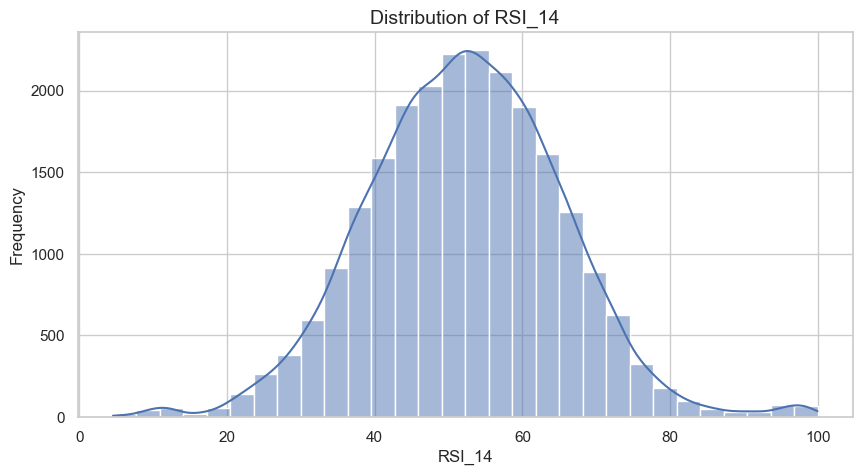

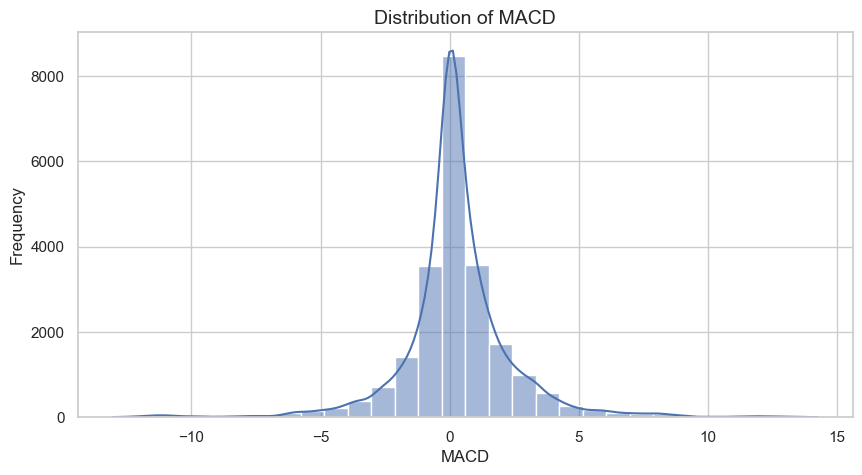

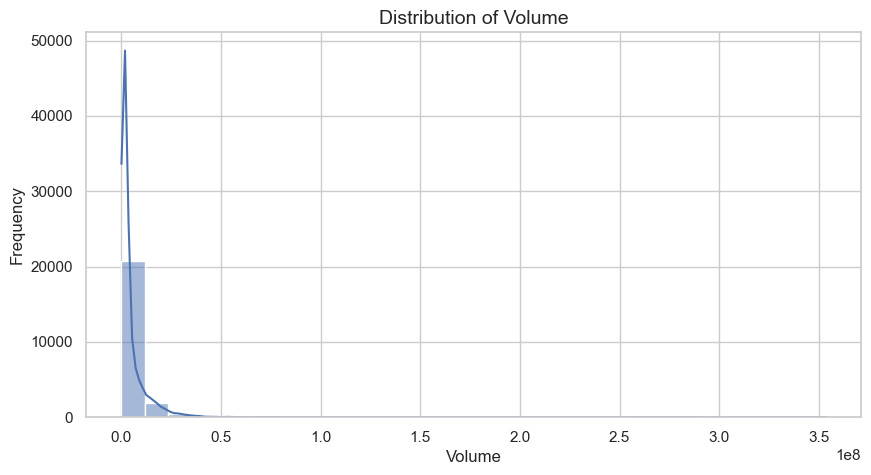

In [39]:
features = ['RSI_14', 'MACD', 'Volume']

for feature in features:
    plt.figure(figsize=(10, 5))
    
    sns.histplot(market_data[feature], kde=True, bins=30)
    
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#### 4) Generate a Correlation Heatmap to Spot Redundant Features
Highly correlated features can be redundant and may hurt certain models. Use a heatmap to visually inspect correlation between numerical features.
- **Resource**: [5 Minute EDA: Correlation Heatmap](https://medium.com/5-minute-eda/5-minute-eda-correlation-heatmap-b57bbb7bae14)

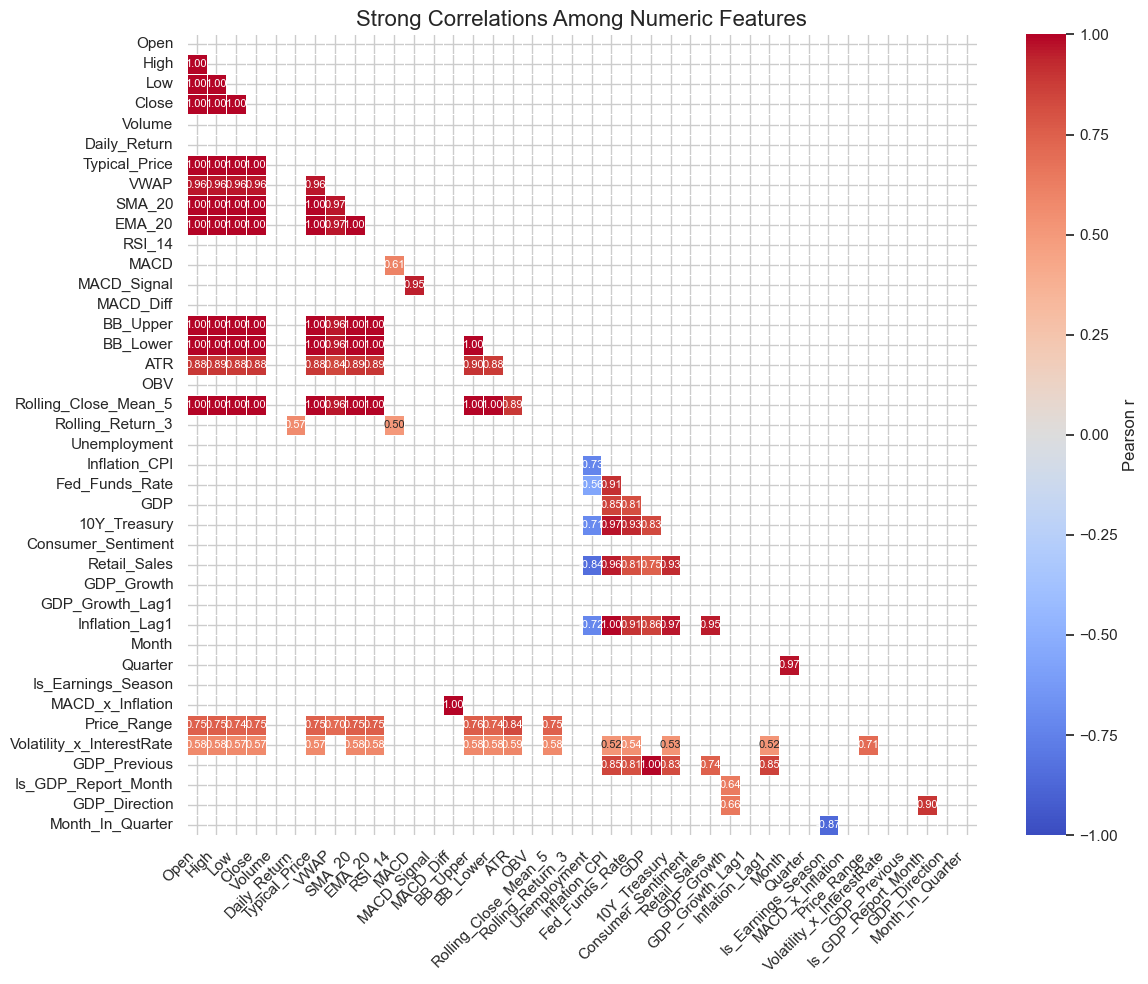

In [47]:
keep = market_data.select_dtypes(include=['number']).columns
cont = market_data[keep]

# 2. Compute correlation
corr = cont.corr(min_periods=200)

# 3. Create masks
mask_upper = np.triu(np.ones_like(corr, dtype=bool))  # Hide upper triangle
mask_low_corr = (abs(corr) < 0.5)  # Hide weak correlations

# Combine masks
full_mask = mask_upper | mask_low_corr

# 4. Plot
plt.figure(figsize=(12,10))
sns.heatmap(
    corr, mask=full_mask,
    cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5,
    cbar_kws={'label':'Pearson r'},
    vmin=-1, vmax=1,
    annot_kws={"size":8}
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Strong Correlations Among Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

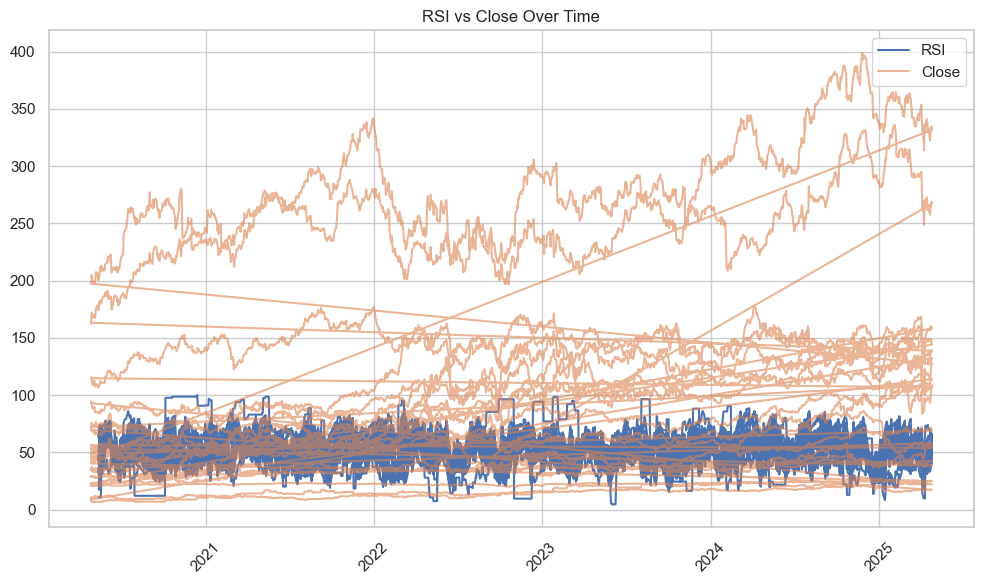

In [43]:
#How does RSI, MACD, or ATR behave before big price movements?
plt.plot(market_data['Date'], market_data['RSI_14'], label='RSI')
plt.plot(market_data['Date'], market_data['Close'], label='Close', alpha=0.6)
plt.legend()
plt.title("RSI vs Close Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 5) Check the Relationship Between Features and the Target
Explore how technical indicators relate to the target (next day’s close). Use scatter plots or group-by summaries to spot patterns.
- **Resource**: [Scatter plot with a grouping variable with Pandas](https://python-graph-gallery.com/537-scatter-plots-grouped-by-color-with-pandas/)

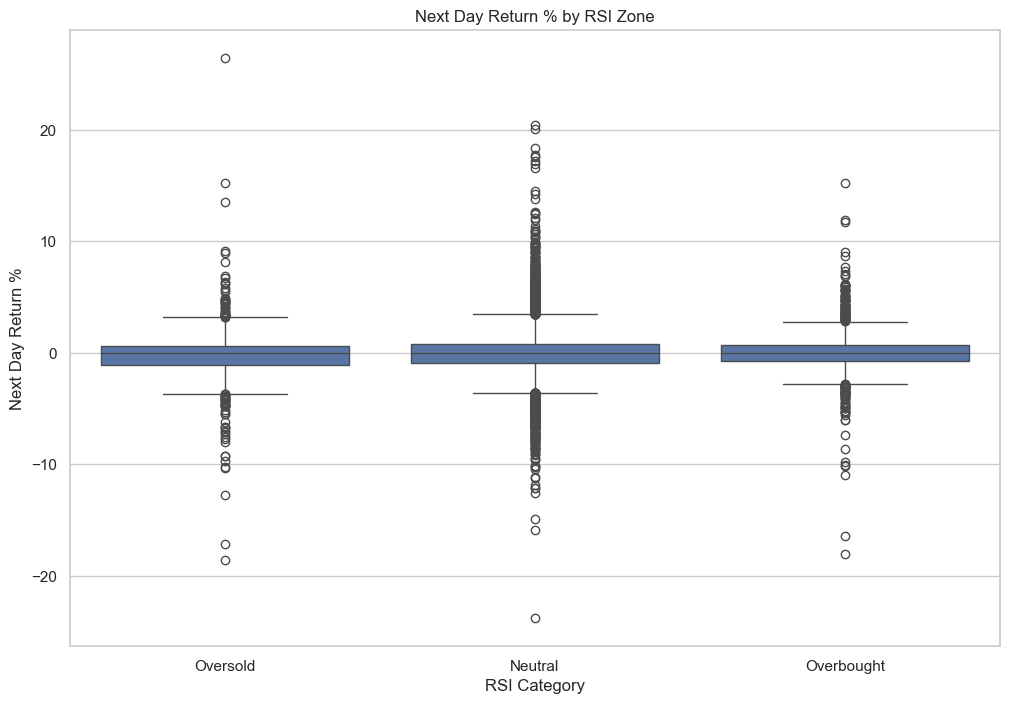

/var/folders/3l/hcxbvknx1hzcd67h9k9cssth0000gn/T/ipykernel_64548/3994603232.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_returns = valid_data.groupby('RSI_Binned')['Target_Return'].agg(['mean', 'median', 'std', 'count'])



Average Next Day Returns by RSI Zone:
                mean    median       std  count
RSI_Binned                                     
Oversold   -0.177714  0.000000  2.482038    971
Neutral    -0.034004 -0.036639  1.862981  20252
Overbought  0.050711  0.000000  1.872128   1790


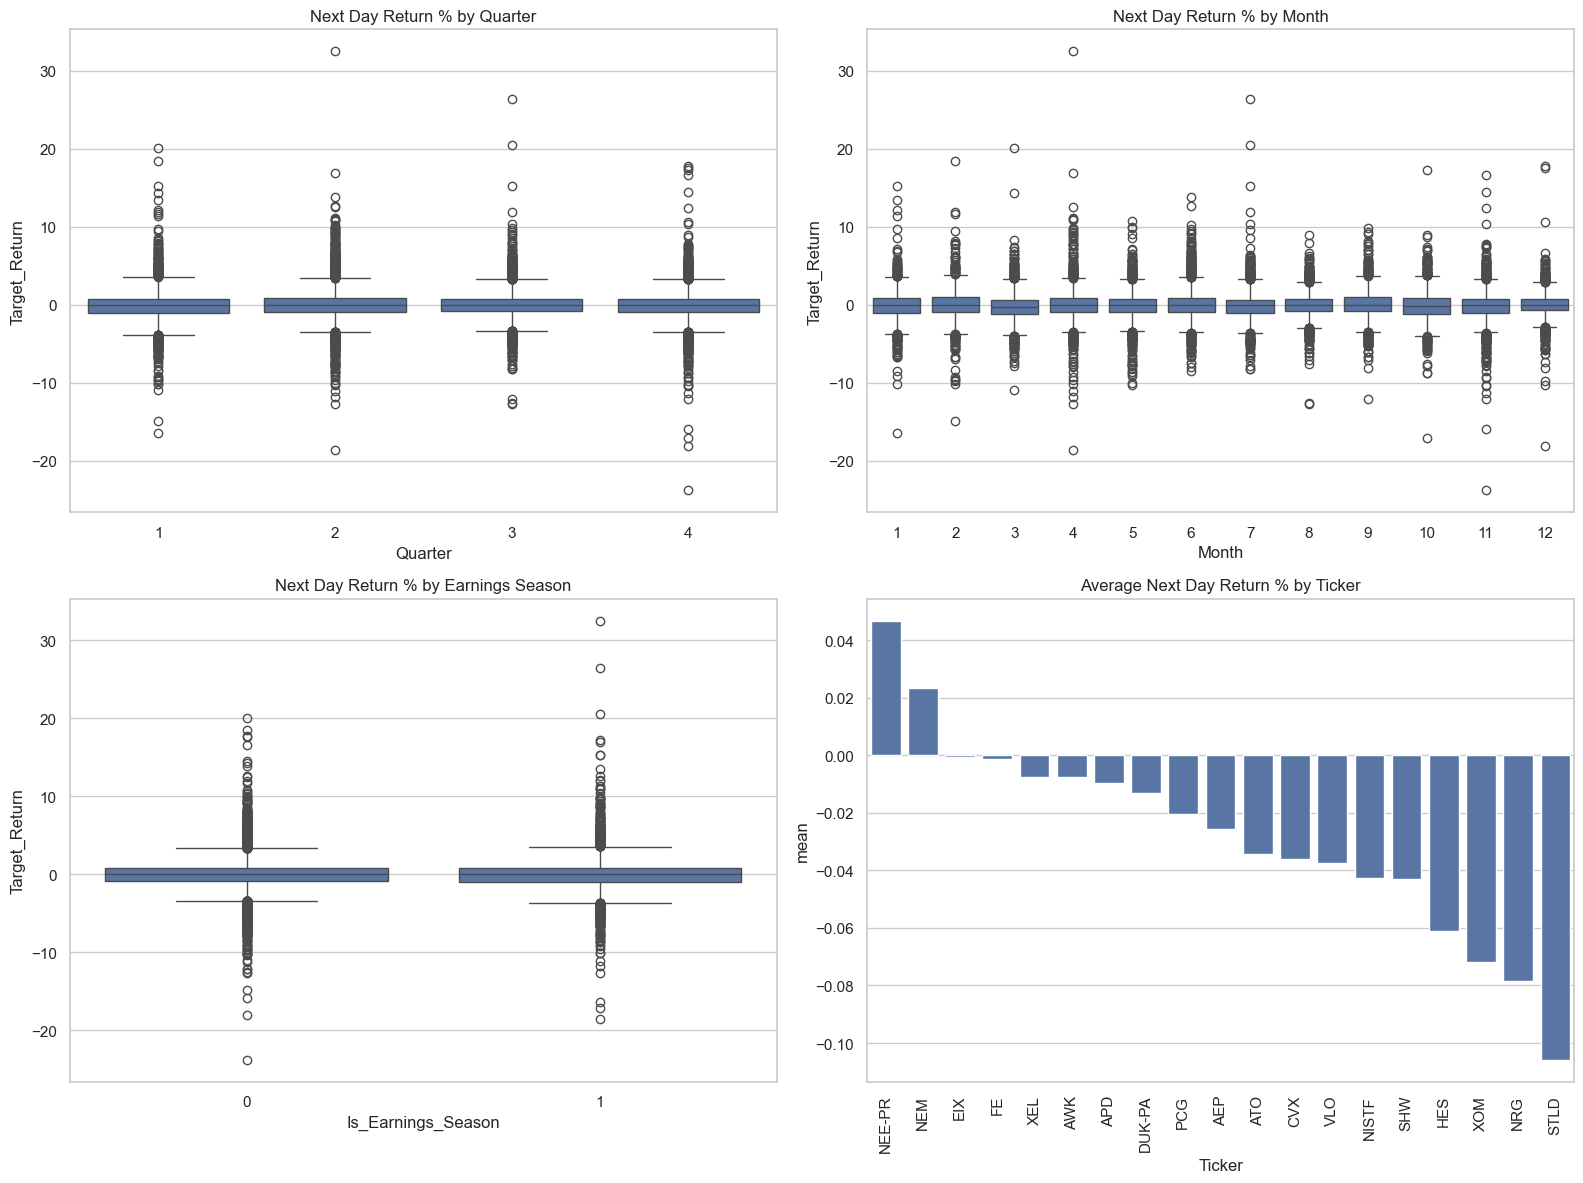

In [49]:

if 'RSI_14' not in market_data.columns:
    print("Warning: RSI_14 column not found in the dataset. Available columns are:")
    print(market_data.columns.tolist())
else:
    # Group by ticker to create the target variable correctly for each stock
    tickers = market_data['Ticker'].unique()
    result_frames = []

    for ticker in tickers:
        # Filter data for this ticker
        ticker_data = market_data[market_data['Ticker'] == ticker].copy()
        
        # Sort by date to ensure correct shifting
        ticker_data = ticker_data.sort_values('Date')
        
        # Create the target variable (next day's Close)
        ticker_data['Target'] = ticker_data['Close'].shift(-1)
        
        # Create the target return variable
        ticker_data['Target_Return'] = ticker_data['Close'].pct_change(periods=-1) * 100
        
        # Add to our results
        result_frames.append(ticker_data)

    # Combine all the data back together
    market_data_with_target = pd.concat(result_frames)
    
    # Now create RSI bins if possible
    if 'RSI_14' in market_data_with_target.columns:
        # Drop NaN values in RSI_14 before creating bins
        rsi_data = market_data_with_target.dropna(subset=['RSI_14'])
        
        # Check if we have any valid RSI data left
        if len(rsi_data) > 0:
            # Create RSI category bins
            market_data_with_target['RSI_Binned'] = pd.cut(
                market_data_with_target['RSI_14'],
                bins=[0, 30, 70, 100],
                labels=['Oversold', 'Neutral', 'Overbought']
            )
            
            # Create the plot with error handling
            plt.figure(figsize=(12, 8))
            valid_data = market_data_with_target.dropna(subset=['RSI_Binned', 'Target_Return'])
            
            if len(valid_data) > 0:
                sns.boxplot(x='RSI_Binned', y='Target_Return', data=valid_data)
                plt.title("Next Day Return % by RSI Zone")
                plt.xlabel("RSI Category")
                plt.ylabel("Next Day Return %")
                plt.show()
                
                # Calculate average returns by RSI zone across all tickers
                avg_returns = valid_data.groupby('RSI_Binned')['Target_Return'].agg(['mean', 'median', 'std', 'count'])
                print("\nAverage Next Day Returns by RSI Zone:")
                print(avg_returns)
            else:
                print("No valid data points with both RSI bins and Target Return")
        else:
            print("No valid RSI_14 data found (all values are NaN)")
    else:
        print("RSI_14 column not found in the processed data")
    
    # Let's try plotting returns by another feature that definitely exists
    plt.figure(figsize=(16, 12))
    
    # Plot returns by quarter
    plt.subplot(2, 2, 1)
    valid_data = market_data_with_target.dropna(subset=['Quarter', 'Target_Return'])
    if len(valid_data) > 0:
        sns.boxplot(x='Quarter', y='Target_Return', data=valid_data)
        plt.title("Next Day Return % by Quarter")
    else:
        plt.title("No valid data for Quarter analysis")
    
    # Plot returns by month
    plt.subplot(2, 2, 2)
    valid_data = market_data_with_target.dropna(subset=['Month', 'Target_Return'])
    if len(valid_data) > 0:
        sns.boxplot(x='Month', y='Target_Return', data=valid_data)
        plt.title("Next Day Return % by Month")
    else:
        plt.title("No valid data for Month analysis")
    
    # Plot returns by Is_Earnings_Season (if it exists)
    plt.subplot(2, 2, 3)
    if 'Is_Earnings_Season' in market_data_with_target.columns:
        valid_data = market_data_with_target.dropna(subset=['Is_Earnings_Season', 'Target_Return'])
        if len(valid_data) > 0:
            sns.boxplot(x='Is_Earnings_Season', y='Target_Return', data=valid_data)
            plt.title("Next Day Return % by Earnings Season")
        else:
            plt.title("No valid data for Earnings Season analysis")
    else:
        plt.title("Is_Earnings_Season column not found")
    
    # Show ticker performances for comparison
    plt.subplot(2, 2, 4)
    ticker_returns = market_data_with_target.groupby('Ticker')['Target_Return'].agg(['mean', 'std']).sort_values('mean', ascending=False)
    if len(ticker_returns) > 0:
        sns.barplot(x=ticker_returns.index, y=ticker_returns['mean'])
        plt.title("Average Next Day Return % by Ticker")
        plt.xticks(rotation=90)
    else:
        plt.title("No valid data for Ticker return analysis")
    
    plt.tight_layout()
    plt.show()

#### 6) Use Boxplots to Detect Outliers
- Boxplots are a great way to spot extreme values or outliers in numeric features. 
- Outliers can influence your model heavily — decide whether to keep, remove, or transform them.
- **Resource**: [How to detect outliers using IQR and Boxplots?](https://www.machinelearningplus.com/machine-learning/how-to-detect-outliers-using-iqr-and-boxplots/)

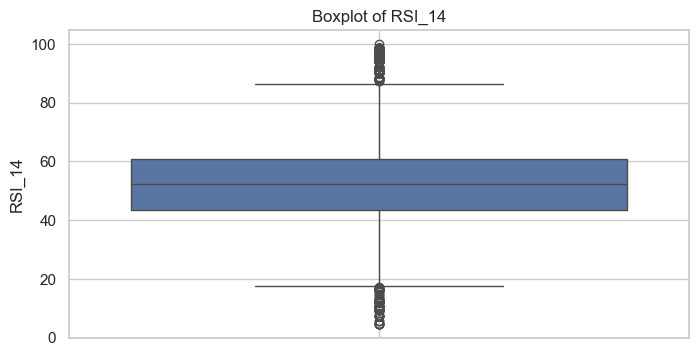

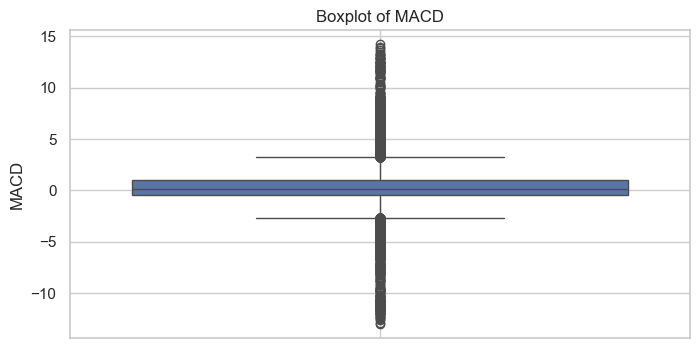

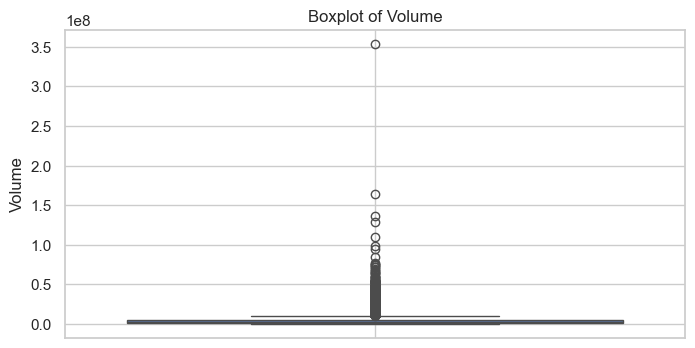

In [55]:
features_to_plot = ['RSI_14', 'MACD', 'Volume']

# Loop through each feature and plot a boxplot
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(y=market_data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.grid(True)
    plt.show()

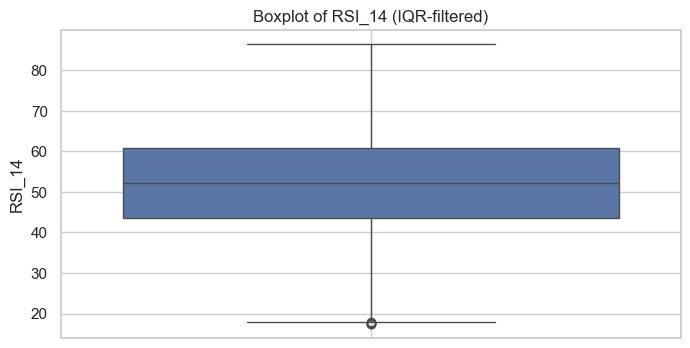

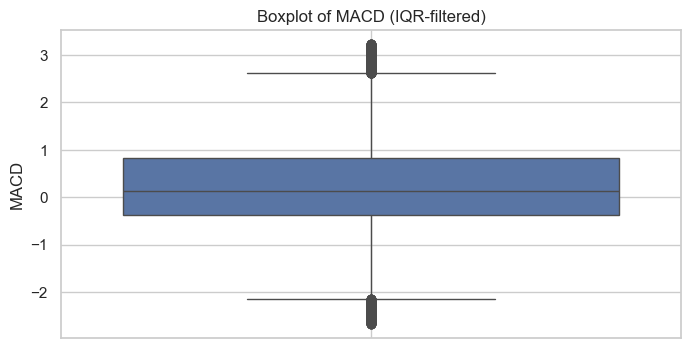

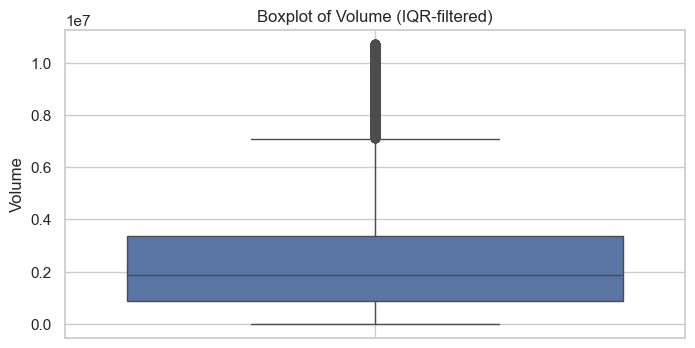

In [57]:
# Loop through each feature, filter using IQR, then plot
for feature in features_to_plot:
    Q1 = market_data[feature].quantile(0.25)
    Q3 = market_data[feature].quantile(0.75)
    IQR = Q3 - Q1

    # IQR filtering: keep only data within bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = market_data[(market_data[feature] >= lower_bound) & (market_data[feature] <= upper_bound)]

    # Plot boxplot of filtered data
    plt.figure(figsize=(8, 4))
    sns.boxplot(y=filtered_df[feature])
    plt.title(f'Boxplot of {feature} (IQR-filtered)')
    plt.grid(True)
    plt.show()


#### 7) Investigate Patterns Over Time or Between Groups (Sector, Ticker, etc.)
- Use time-based plots to see if the target or indicators change by day of the week or over time.
- Grouped boxplots can help reveal differences between companies or sectors.
- **Resource**: [Python Plotting for Exploratory Data Analysis](https://pythonplot.com/)

In [73]:
# 1) Compute next‐day target within each ticker
market_data["Target"] = (
    market_data
      .sort_values(["Ticker","Date"])
      .groupby("Ticker")["Close"]
      .shift(-1)
)

# 2) Ensure Date is a proper datetime and drop any bad rows
if not pd.api.types.is_datetime64_any_dtype(market_data["Date"]):
    market_data["Date"] = pd.to_datetime(market_data["Date"], errors="coerce")

market_data = market_data.dropna(subset=["Date","Target"])

/var/folders/3l/hcxbvknx1hzcd67h9k9cssth0000gn/T/ipykernel_64548/3509159857.py:18: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


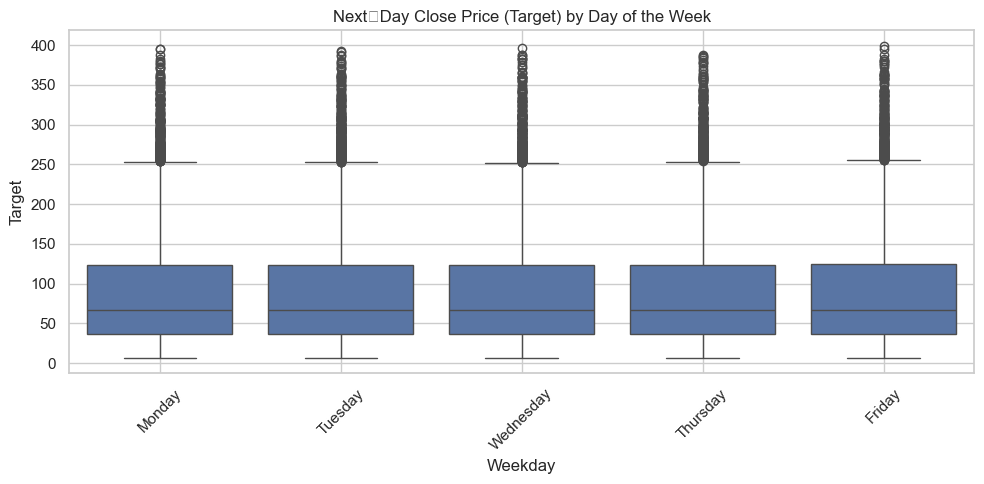

In [75]:
# 3) Extract weekday name
market_data["Weekday"] = market_data["Date"].dt.day_name()

# 4) Prepare dataframe for the boxplot
plot_df = market_data.dropna(subset=["Weekday","Target"])

# 5) Boxplot: Next‐Day Close by Day of the Week
plt.figure(figsize=(10,5))
sns.boxplot(
    data=plot_df,
    x="Weekday",
    y="Target",
    order=["Monday","Tuesday","Wednesday","Thursday","Friday"]
)
plt.title("Next‐Day Close Price (Target) by Day of the Week")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Available tickers: ['PCG' 'AEP' 'AWK' 'XOM' 'CVX' 'SHW' 'VLO' 'DUK-PA' 'HES' 'NISTF' 'ATO'
 'STLD' 'APD' 'NEE-PR' 'NEM' 'XEL' 'EIX' 'FE' 'NRG']


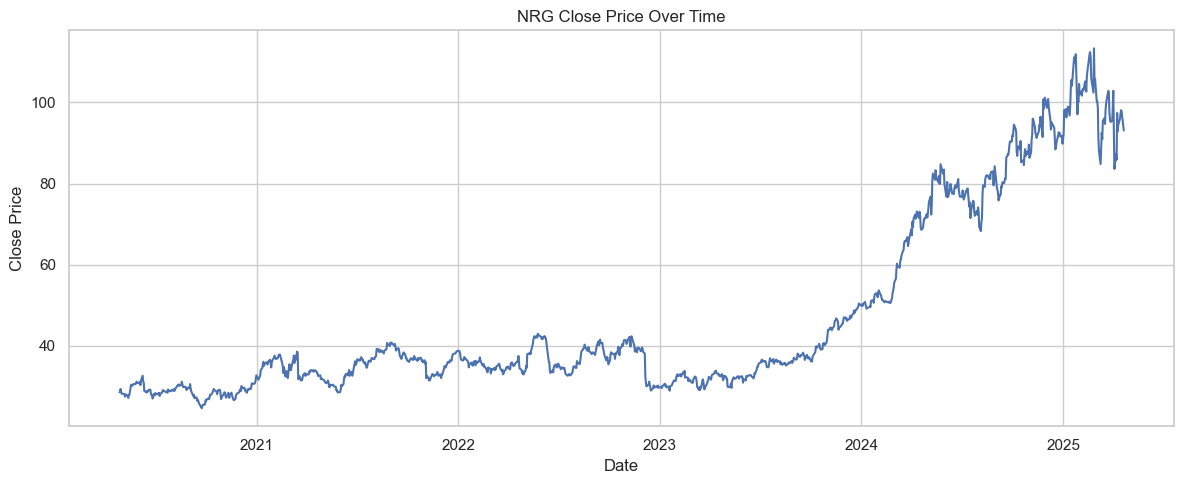

In [83]:
# 6) See which tickers you have
print("Available tickers:", market_data["Ticker"].unique())

# 7) Lineplot for one example ticker (e.g. 'YOU')
ticker = "NRG"
single_df = market_data[market_data["Ticker"] == ticker]

plt.figure(figsize=(12,5))
sns.lineplot(data=single_df, x="Date", y="Close")
plt.title(f"{ticker} Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
price_cols = ['Open','High','Low','Close','Volume']
tech_cols = ['SMA_20','EMA_20','RSI_14','MACD_Diff']
macro_cols = ['Unemployment','Inflation_CPI','Fed_Funds_Rate','GDP_Growth']

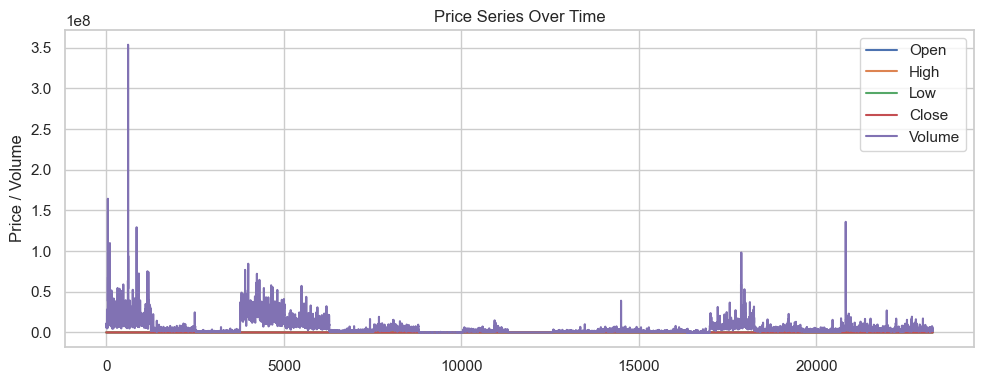

In [87]:
# --- Multi-line plot for prices ---
market_data[price_cols].plot(
    figsize=(10,4),
    title="Price Series Over Time"
)
plt.ylabel("Price / Volume")
plt.tight_layout()
plt.show()


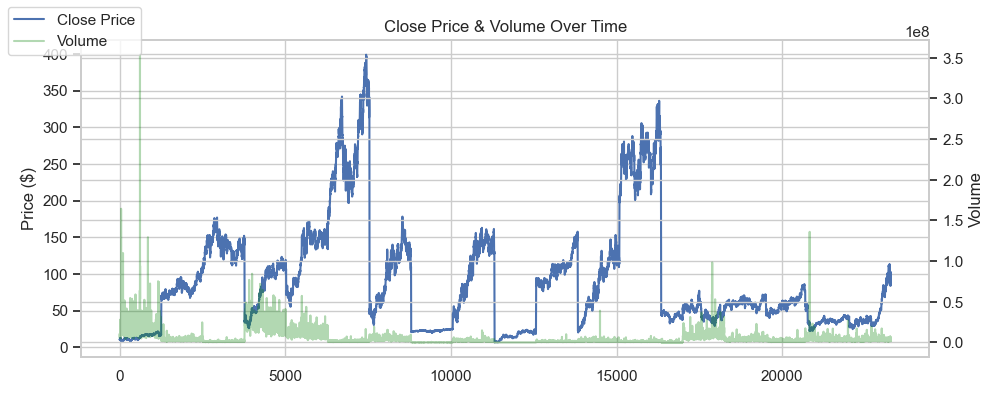

In [89]:
fig, ax1 = plt.subplots(figsize=(10,4))
# plot price on left axis
market_data['Close'].plot(ax=ax1, label='Close Price')
ax1.set_ylabel("Price ($)")
# plot volume on right axis
ax2 = ax1.twinx()
market_data['Volume'].plot(
    ax=ax2, 
    color='green', 
    alpha=0.3, 
    label='Volume'
)
ax2.set_ylabel("Volume")
fig.legend(loc='upper left')
plt.title("Close Price & Volume Over Time")
plt.tight_layout()
plt.show()

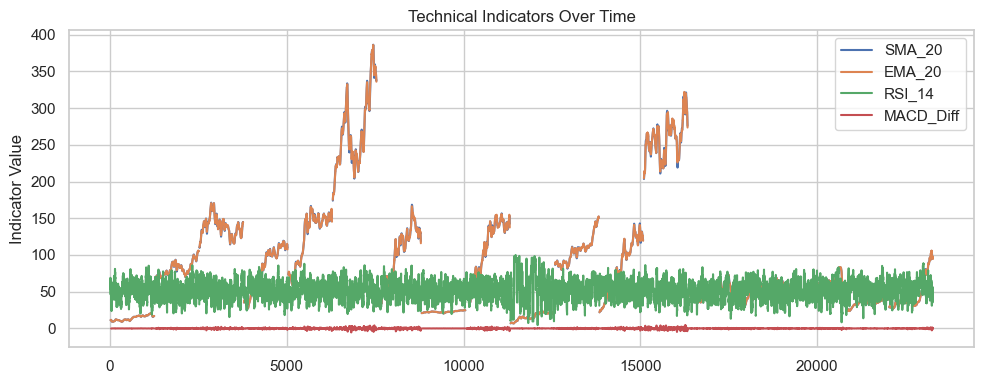

In [91]:

# --- Technical indicators ---
market_data[tech_cols].plot(
    figsize=(10,4),
    title="Technical Indicators Over Time"
)
plt.ylabel("Indicator Value")
plt.tight_layout()
plt.show()


In [93]:
print("Shape:", market_data.shape)
print("Columns:", market_data.columns.tolist())
print(market_data[macro_cols].head())
print(market_data[macro_cols].isna().sum())

Shape: (23203, 44)
Columns: ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'Typical_Price', 'VWAP', 'SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_Upper', 'BB_Lower', 'ATR', 'OBV', 'Rolling_Close_Mean_5', 'Rolling_Return_3', 'Unemployment', 'Inflation_CPI', 'Fed_Funds_Rate', 'GDP', '10Y_Treasury', 'Consumer_Sentiment', 'Retail_Sales', 'GDP_Growth', 'GDP_Growth_Lag1', 'Inflation_Lag1', 'Month', 'Quarter', 'Is_Earnings_Season', 'MACD_x_Inflation', 'Price_Range', 'Volatility_x_InterestRate', 'GDP_Previous', 'Is_GDP_Report_Month', 'GDP_Direction', 'Month_In_Quarter', 'Target', 'Weekday']
   Unemployment  Inflation_CPI  Fed_Funds_Rate  GDP_Growth
0          13.2        255.802            0.05         0.0
1          13.2        255.802            0.05         0.0
2          13.2        255.802            0.05         0.0
3          13.2        255.802            0.05         0.0
4          13.2        255.802            0.05         0.0
Un

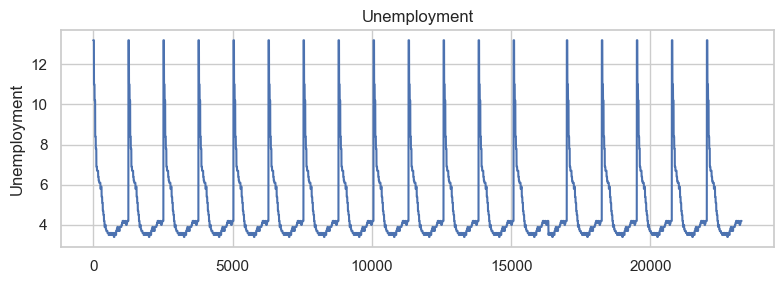

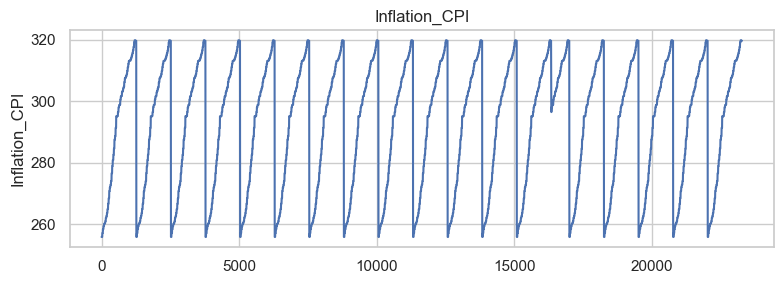

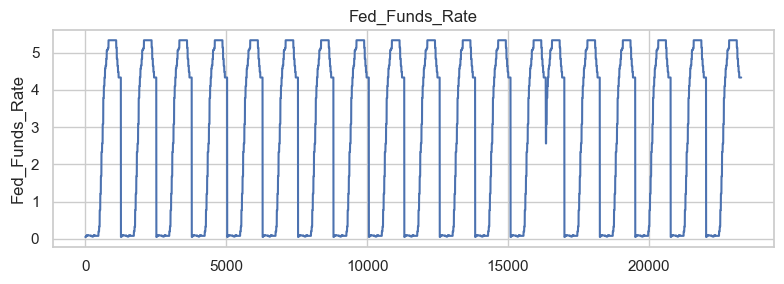

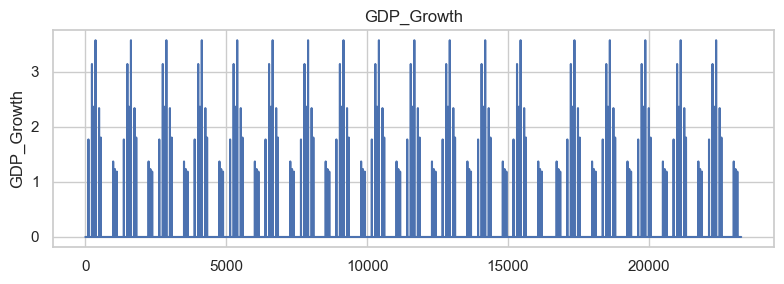

In [95]:
for col in macro_cols:
    plt.figure(figsize=(8,3))
    market_data[col].plot()
    plt.title(col)
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

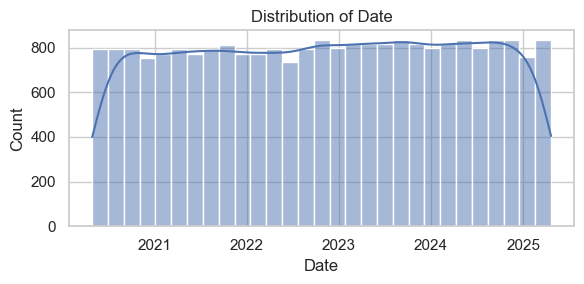

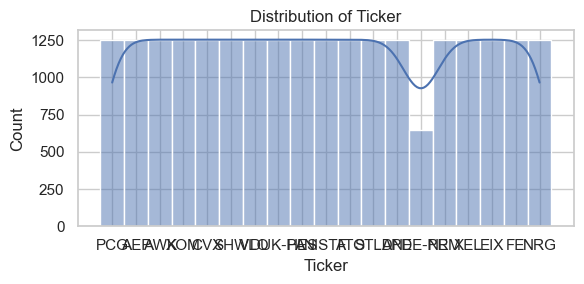

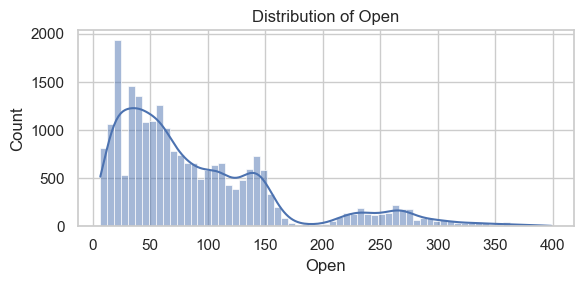

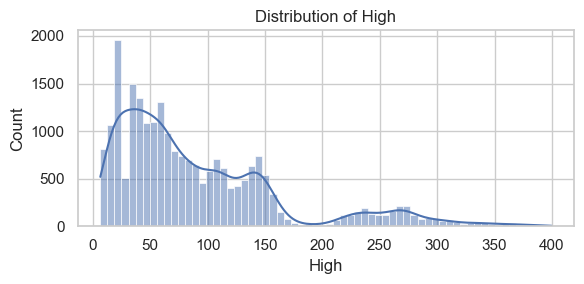

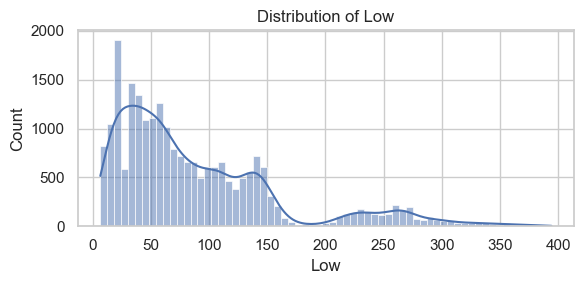

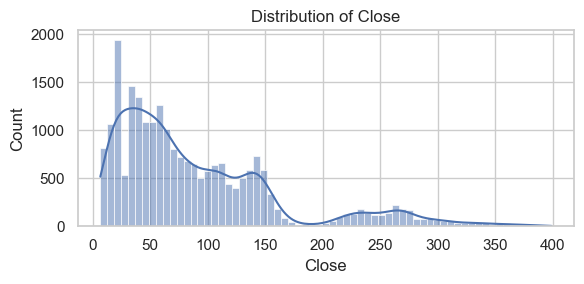

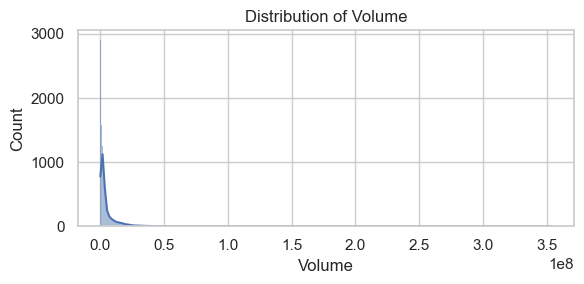

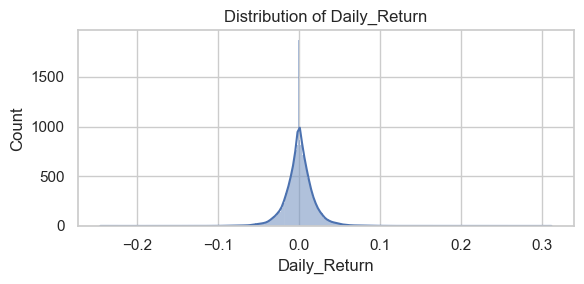

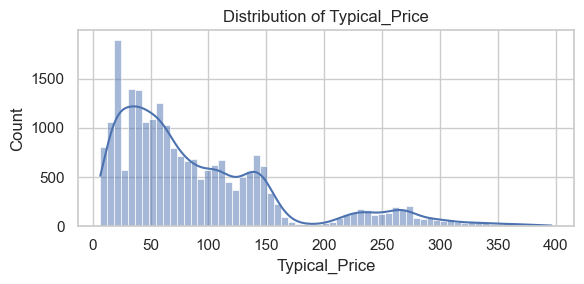

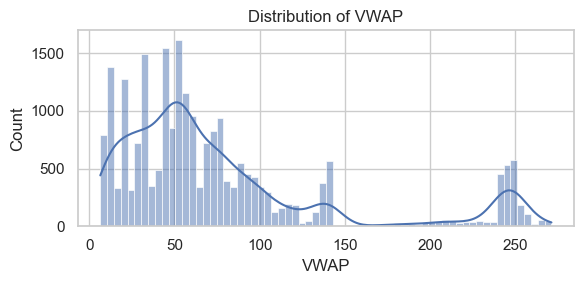

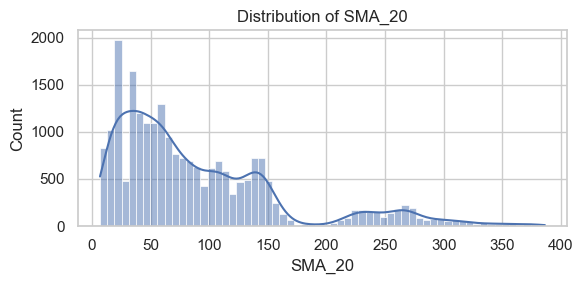

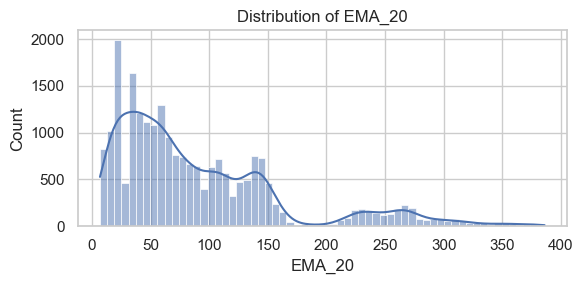

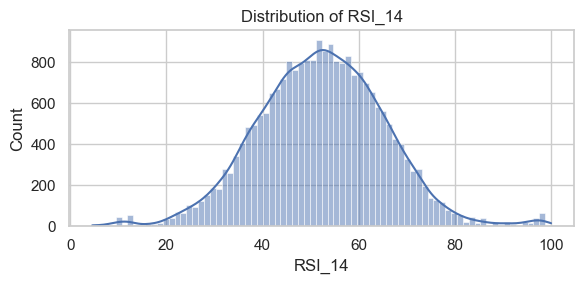

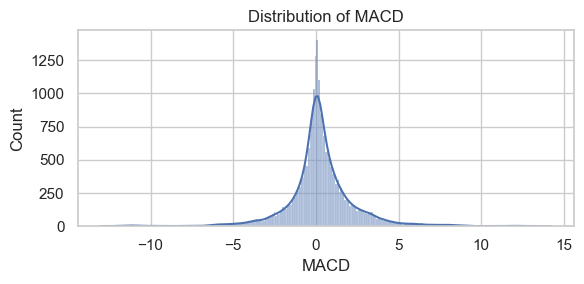

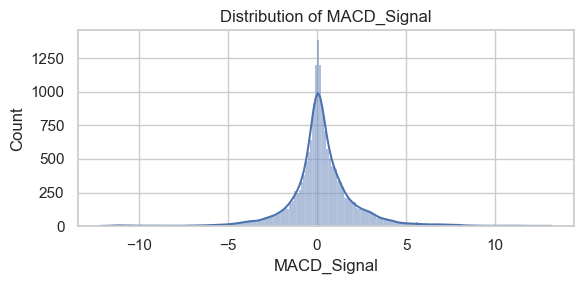

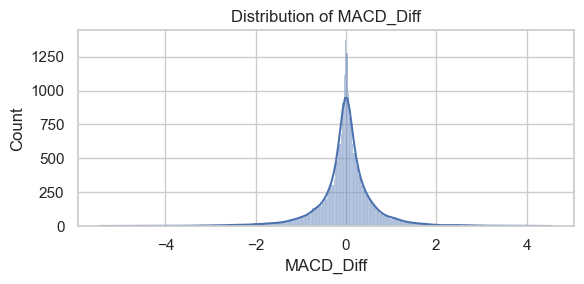

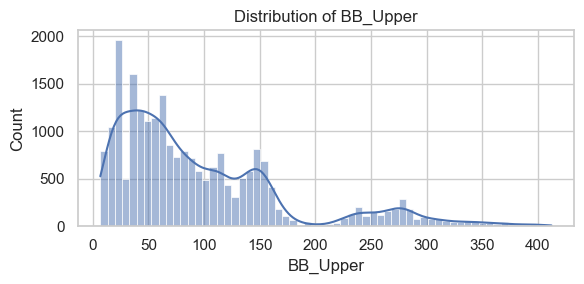

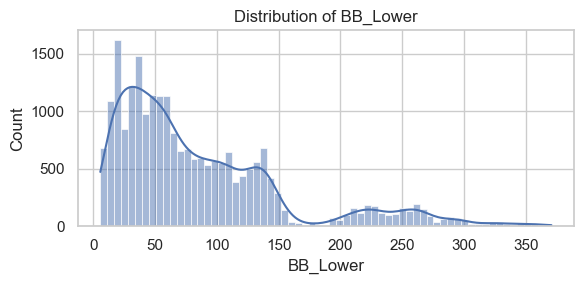

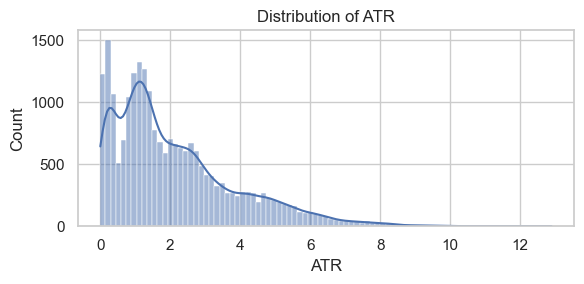

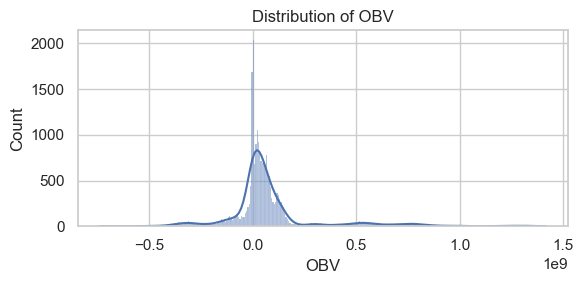

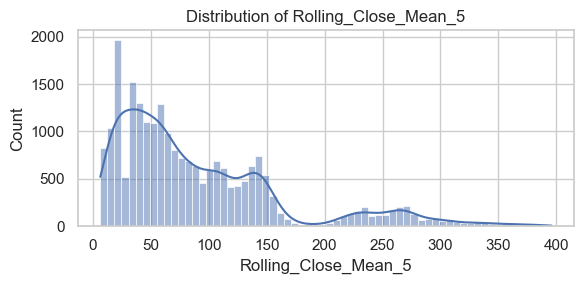

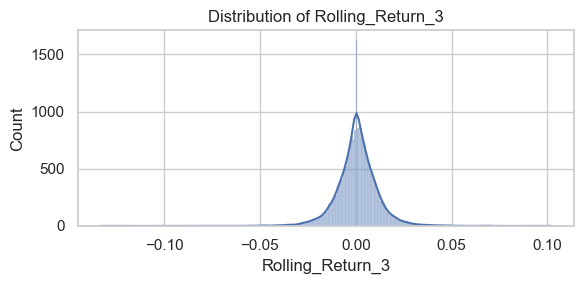

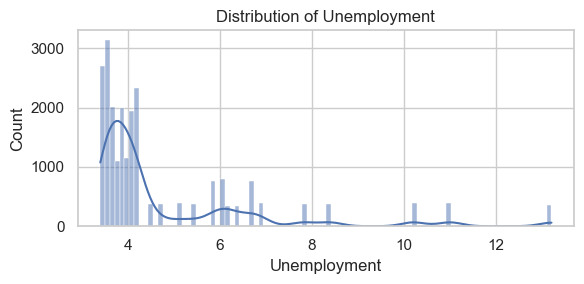

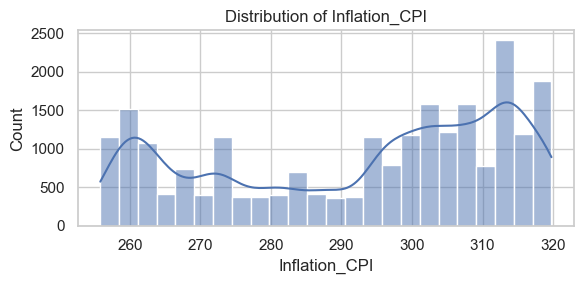

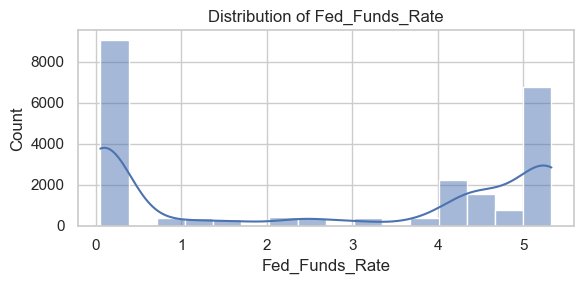

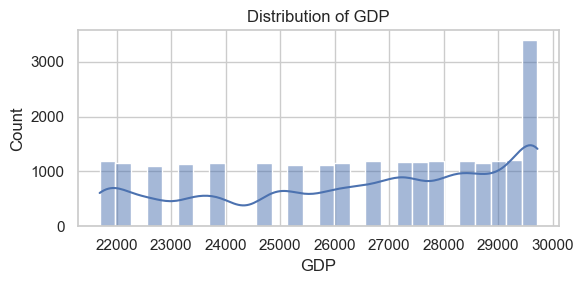

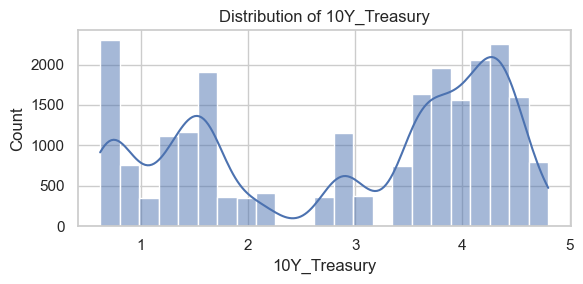

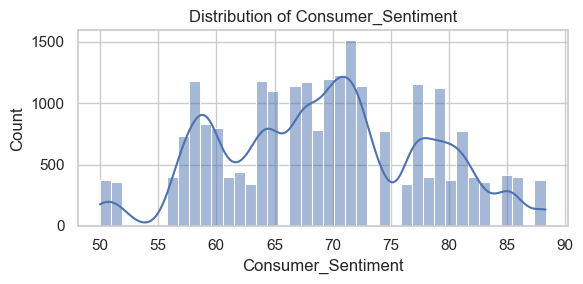

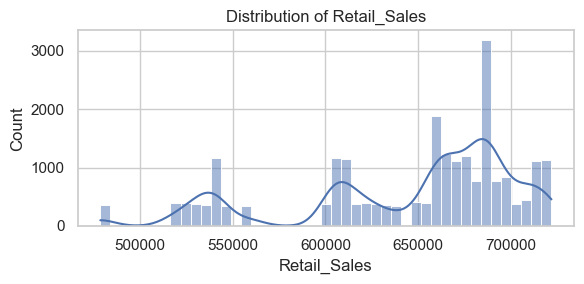

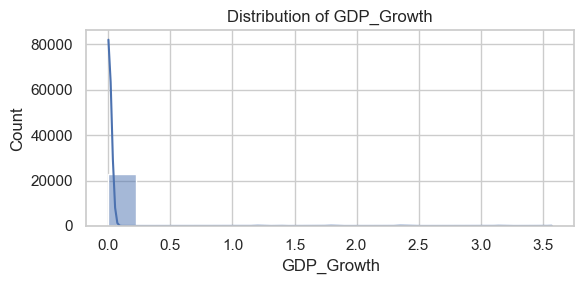

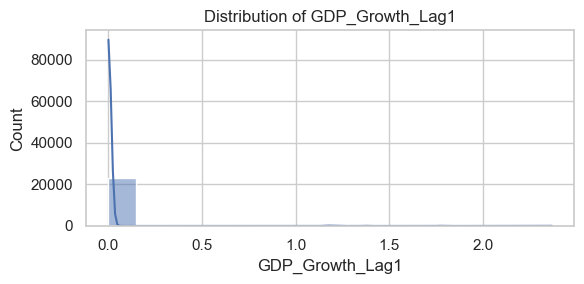

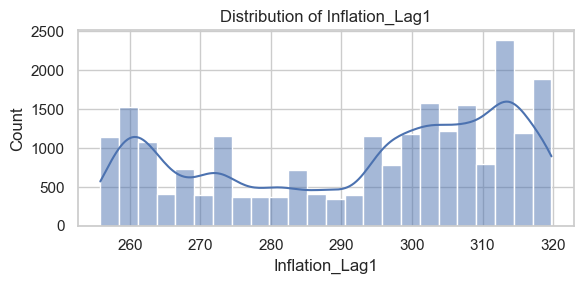

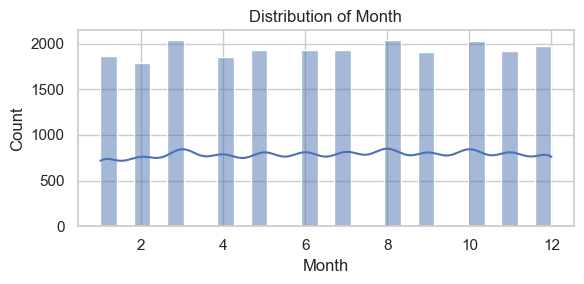

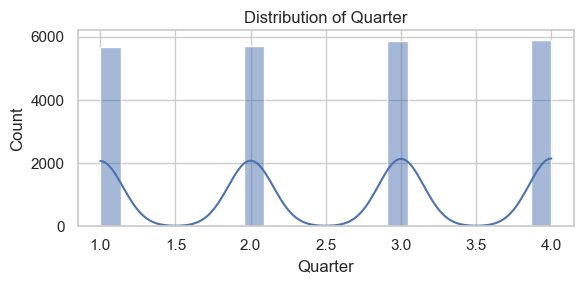

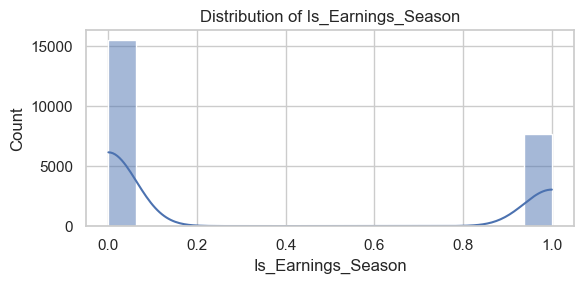

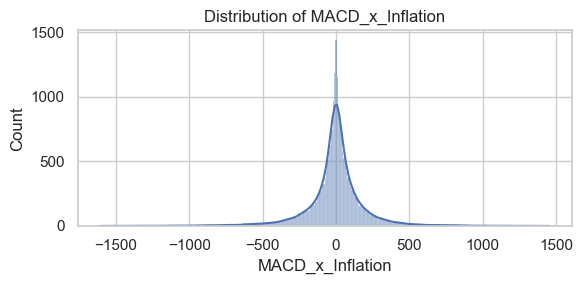

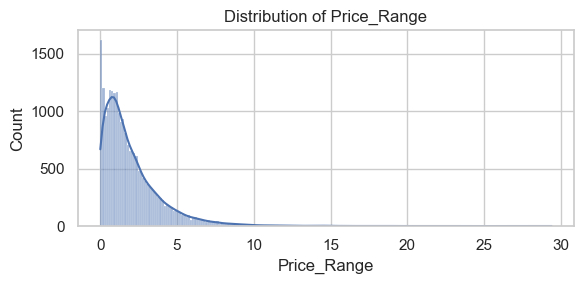

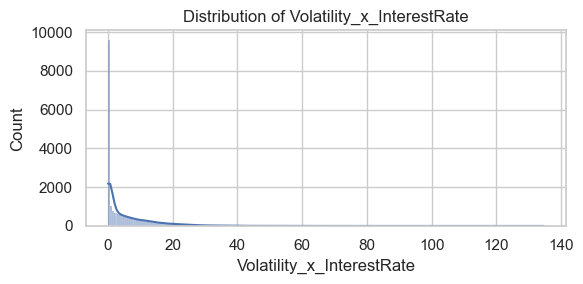

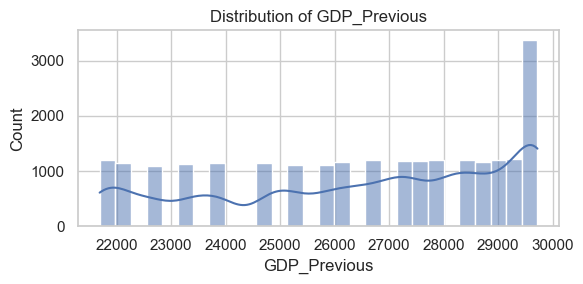

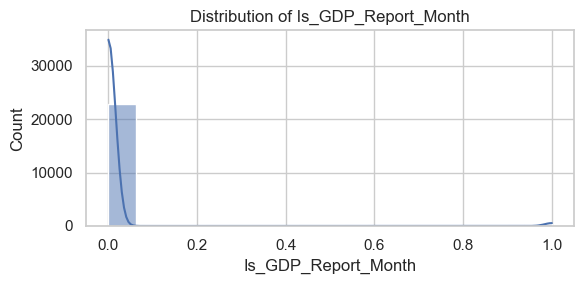

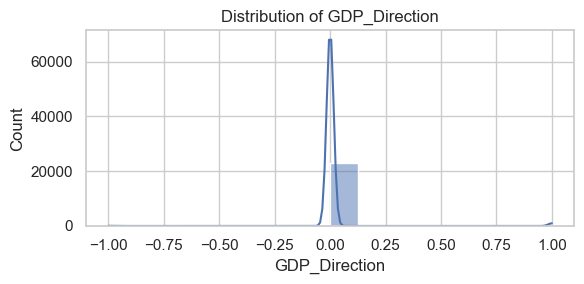

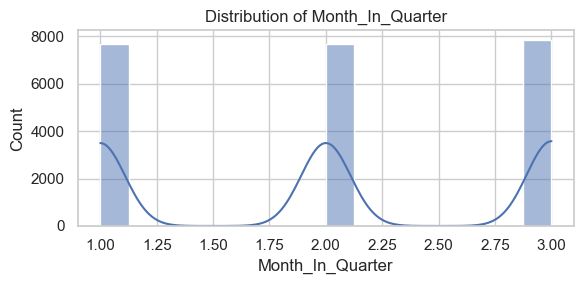

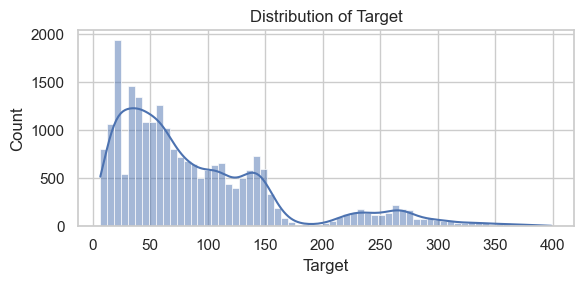

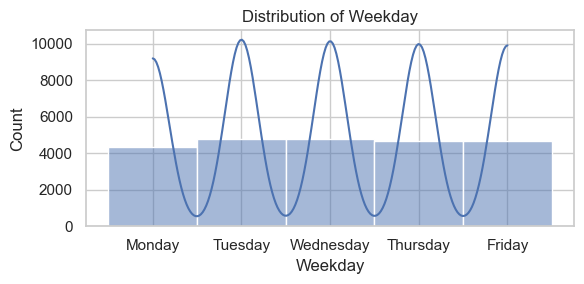

In [97]:
# --- Step E: Marginal distributions ---
for col in market_data.columns:
    plt.figure(figsize=(6, 3))
    sns.histplot(market_data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [99]:
# --- Step G: Quick sanity prints ---
print("Daily_Return head & missing count:")
print(market_data['Daily_Return'].head())
print("Missing Daily_Return:", market_data['Daily_Return'].isna().sum())

print("\nTicker frequency:")
print(market_data['Ticker'].value_counts())

Daily_Return head & missing count:
0         NaN
1    0.041985
2   -0.037546
3    0.012369
4   -0.046992
Name: Daily_Return, dtype: float64
Missing Daily_Return: 19

Ticker frequency:
Ticker
PCG       1253
AEP       1253
FE        1253
EIX       1253
XEL       1253
NEM       1253
APD       1253
STLD      1253
ATO       1253
NISTF     1253
HES       1253
DUK-PA    1253
VLO       1253
SHW       1253
CVX       1253
XOM       1253
AWK       1253
NRG       1253
NEE-PR     649
Name: count, dtype: int64


In [105]:
# --- 1) Build a mini econ-only DataFrame (one row per date) ---
econ = (
    market_data
      .loc[:, ['Date','Unemployment','Inflation_CPI','Fed_Funds_Rate','GDP']]
      .drop_duplicates('Date')   # one row per calendar day
      .sort_values('Date')
      .reset_index(drop=True)
)

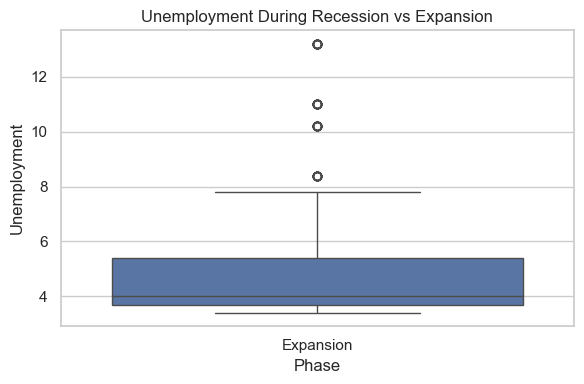

In [106]:
# GDP Growth & phase
econ['GDP_Growth'] = econ['GDP'].pct_change()
econ.dropna(subset=['GDP_Growth'], inplace=True)
econ['Phase'] = econ['GDP_Growth'].apply(lambda x: 'Recession' if x < 0 else 'Expansion')

# ---- Boxplot: Unemployment in Recession vs Expansion ----
plt.figure(figsize=(6,4))
sns.boxplot(data=econ, x='Phase', y='Unemployment')
plt.title("Unemployment During Recession vs Expansion")
plt.tight_layout()
plt.show()

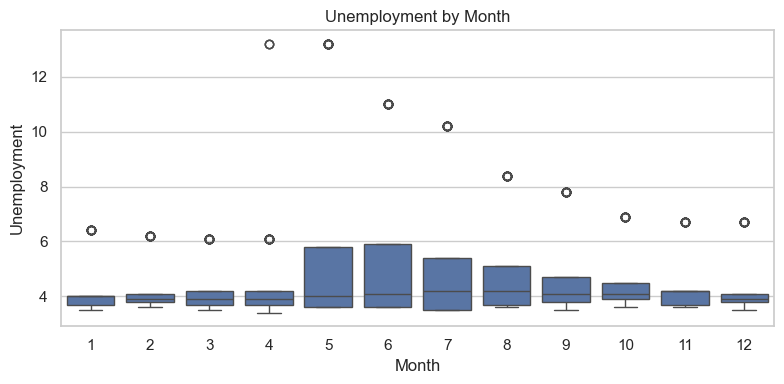

In [109]:
# Month of year
econ['Month'] = econ['Date'].dt.month

# ---- Boxplot: Unemployment by Month ----
plt.figure(figsize=(8,4))
sns.boxplot(data=econ, x='Month', y='Unemployment')
plt.title("Unemployment by Month")
plt.tight_layout()
plt.show()

#### 8) Brainstorm & Engineer New Features Based on Your Insights
- Consider creating features like price range, volatility, lagged prices, or differences from moving averages.
- These can help capture patterns not directly visible in raw features.
- **Resource**: [A Reference Guide to Feature Engineering](https://www.kaggle.com/code/prashant111/a-reference-guide-to-feature-engineering-methods)

In [113]:
# MACD diff & interaction with inflation
market_data['MACD_diff']         = market_data['MACD'] - market_data['MACD_Signal']
market_data['MACD_x_Inflation']  = market_data['MACD_diff'] * market_data['Inflation_CPI']

In [115]:
# Price range & interaction with Fed funds
market_data['Price_Range']               = market_data['High'] - market_data['Low']
market_data['Volatility_x_InterestRate'] = (
    market_data['Price_Range'] * market_data['Fed_Funds_Rate']
)

In [117]:
# Lagged macro features
market_data['Date_only'] = market_data['Date'].dt.date
market_data['Inflation_Lag1'] = market_data['Inflation_CPI'].shift(1)
market_data['GDP_Growth_Lag1'] = market_data['GDP_Growth'].shift(1)

In [119]:
market_data['Month'] = market_data['Date'].dt.month
market_data['Quarter'] = market_data['Date'].dt.quarter
market_data['Is_Earnings_Season'] = market_data['Month'].isin([1, 4, 7, 10]).astype(int)

# --- 3) Compute rolling features per Ticker ---
# 5-day rolling mean of Close
market_data['Rolling_Close_Mean_5'] = (
    market_data
      .sort_values(['Ticker','Date'])
      .groupby('Ticker')['Close']
      .rolling(window=5, min_periods=1)  # min_periods=1 if you want partial windows at start
      .mean()
      .reset_index(level=0, drop=True)
)

# 3-day rolling mean of 1-day pct_return
market_data['Rolling_Return_3'] = (
    market_data
      .sort_values(['Ticker','Date'])
      .groupby('Ticker')['Close']
      .pct_change()
      .rolling(window=3, min_periods=1)
      .mean()
      .reset_index(level=0, drop=True)
)

In [121]:
new_feats = [
    'MACD_diff', 'MACD_x_Inflation',
    'Price_Range', 'Volatility_x_InterestRate',
    'Inflation_Lag1', 'GDP_Growth_Lag1',
    'Month', 'Quarter', 'Is_Earnings_Season',
    'Rolling_Close_Mean_5', 'Rolling_Return_3'
]

# 2) Check that they’re all in your columns
missing = [f for f in new_feats if f not in market_data.columns]
if missing:
    print("❌ Missing these columns:", missing)
else:
    print("✅ All new features are present!")

# 3) Peek at their first few values
market_data[new_feats].head(10)

✅ All new features are present!


MACD_diff  MACD_x_Inflation  Price_Range  Volatility_x_InterestRate  \
0        NaN               NaN     0.358217                   0.017911   
1        NaN               NaN     0.457722                   0.022886   
2        NaN               NaN     0.746287                   0.037314   
3        NaN               NaN     0.398019                   0.019901   
4        NaN               NaN     0.686584                   0.034329   
5        NaN               NaN     0.895544                   0.044777   
6        NaN               NaN     0.567178                   0.028359   
7        NaN               NaN     0.776138                   0.038807   
8        NaN               NaN     0.706484                   0.035324   
9        NaN               NaN     0.527376                   0.026369   

   Inflation_Lag1  GDP_Growth_Lag1  Month  Quarter  Is_Earnings_Season  \
0             NaN              NaN      4        2                   1   
1         255.802              0.0      4        2                   1   
2         255.802              0.0      4        2                   1   
3         255.802              0.0      4        2                   1   
4         255.802              0.0      5        2                   0   
5         255.802              0.0      5        2                   0   
6         255.802              0.0      5        2                   0   
7         255.802              0.0      5        2                   0   
8         255.802              0.0      5        2                   0   
9         255.802              0.0      5        2                   0   

   Rolling_Close_Mean_5  Rolling_Return_3  
0             10.428111               NaN  
1             10.647021          0.012078  
2             10.584002         -0.002823  
3             10.584831         -0.001962  
4             10.485824         -0.012887  
5             10.589309         -0.000180  
6             10.766428          0.000944  
7             10.961457         -0.010123  
8             11.060962         -0.014873  
9             11.349526         -0.010573

In [123]:
market_data.columns

Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Daily_Return', 'Typical_Price', 'VWAP', 'SMA_20', 'EMA_20', 'RSI_14',
       'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_Upper', 'BB_Lower', 'ATR',
       'OBV', 'Rolling_Close_Mean_5', 'Rolling_Return_3', 'Unemployment',
       'Inflation_CPI', 'Fed_Funds_Rate', 'GDP', '10Y_Treasury',
       'Consumer_Sentiment', 'Retail_Sales', 'GDP_Growth', 'GDP_Growth_Lag1',
       'Inflation_Lag1', 'Month', 'Quarter', 'Is_Earnings_Season',
       'MACD_x_Inflation', 'Price_Range', 'Volatility_x_InterestRate',
       'GDP_Previous', 'Is_GDP_Report_Month', 'GDP_Direction',
       'Month_In_Quarter', 'Target', 'Weekday', 'MACD_diff', 'Date_only'],
      dtype='object')

In [125]:
market_data.head()

Date Ticker       Open       High        Low      Close   Volume  \
0 2020-04-27    PCG  10.666924  10.776379  10.418161  10.428111  9804800   
1 2020-04-28    PCG  10.597267  10.955485  10.497763  10.865931  6763500   
2 2020-04-29    PCG  11.124646  11.194299  10.448012  10.457963  6230500   
3 2020-04-30    PCG  10.348506  10.656972  10.258952  10.587318  5889400   
4 2020-05-01    PCG  10.298755  10.577369   9.890785  10.089795  7936100   

   Daily_Return  Typical_Price       VWAP  ...  Price_Range  \
0           NaN      10.540884  10.540884  ...     0.358217   
1      0.041985      10.773059  10.635662  ...     0.457722   
2     -0.037546      10.700091  10.653270  ...     0.746287   
3      0.012369      10.501081  10.622027  ...     0.398019   
4     -0.046992      10.185983  10.527541  ...     0.686584   

   Volatility_x_InterestRate  GDP_Previous  Is_GDP_Report_Month  \
0                   0.017911           NaN                    1   
1                   0.022886     21684.551                    0   
2                   0.037314     21684.551                    0   
3                   0.019901     21684.551                    0   
4                   0.034329     21684.551                    0   

   GDP_Direction  Month_In_Quarter     Target    Weekday  MACD_diff  \
0            NaN                 1  10.865931     Monday        NaN   
1            0.0                 1  10.457963    Tuesday        NaN   
2            0.0                 1  10.587318  Wednesday        NaN   
3            0.0                 1  10.089795   Thursday        NaN   
4            0.0                 2  10.945537     Friday        NaN   

    Date_only  
0  2020-04-27  
1  2020-04-28  
2  2020-04-29  
3  2020-04-30  
4  2020-05-01  

[5 rows x 46 columns]

### Modeling Instructions

#### LSTM Model
##### Understanding LSTM (Long Short-Term Memory)
**Long Short-Term Memory (LSTM)** networks are a special type of Recurrent Neural Network (RNN) designed to learn from sequential or time-series data. What sets LSTMs apart is their ability to retain information over long periods, making them powerful for understanding patterns that unfold over time.
- They are particularly effective for time series forecasting because they:
- Remember past values across long sequences (even hundreds of time steps)
- Can detect patterns in how values evolve over time
- Learn temporal dependencies that traditional models may miss

##### Why LSTM Is Applicable to Our Stock Model
Stock prices are naturally time-dependent; today's price is influenced by the prices of the last few days, weeks, or even months. But the market is also affected by:
- Momentum indicators (like MACD, RSI)
- Macroeconomic shifts (like inflation or interest rates)
- Recurring cycles (e.g., earnings seasons, market open/close trends)
  
LSTMs can capture all of these by:
- Learning how patterns in historical stock prices and technical indicators impact future prices
- Taking in multiple features (multivariate inputs), such as economic indicators, volume, and volatility
- Understanding nonlinear relationships and subtle dependencies that traditional models like ARIMA or Prophet might miss

##### 1. Import Necessary Libraries

**scikit-learn:** A go-to library for classic Machine Learning in Python. We’ll rely on it for:
Data preprocessing
- Scaling our inputs (e.g. MinMaxScaler) so every feature lives on the same 0→1 range before feeding into the LSTM.
- Train/test splitting (train_test_split) or simple cross-validation if we want quick baselines.

Baseline models & utilities
- We can spin up a quick regression (e.g. linear, random forest) to compare against our LSTM.
- Metrics such as RMSE, R², classification accuracy, etc., via sklearn.metrics.

Pipeline tools
- If we want to chain scaling, feature-selection, and a model into a single reusable object, the Pipeline abstraction makes that easy.

*In short:* scikit-learn handles all of the “standard ML” chores—cleaning, splitting, evaluating—and lets us focus TensorFlow on the deep-learning side.

**TensorFlow (with Keras):** Google’s end-to-end platform for building and training neural networks. In our project we’ll use it to:

Define our LSTM architecture
- Stack one or more LSTM layers to learn temporal patterns in stock prices plus technical/macro indicators.
- Add final Dense layers to regress on next-day price.

Efficient training
- Take advantage of GPU acceleration (if available) to quickly run back-prop through hundreds of thousands of time-steps.
- Monitor training/validation loss, checkpoint models, and adjust hyperparameters on the fly.

*In short:* TensorFlow is our workhorse for any deep-learning component—here, the LSTM—that goes beyond what classical scikit-learn models can capture.

In [127]:
!pip install scikit-learn
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 22.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 17.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.6/393.6 kB 8.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 9.4 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 639.5/639.5 kB 17.4 MB/s eta 0

In [129]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense   # ← add Dropout here
from tensorflow.keras.callbacks import EarlyStopping

2025-04-26 00:33:36.933694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### 2. Choose Your Input Features
You have ~46 columns in market_data, but LSTMs work best when you feed them only the signals that matter. My recommendation:
- Always include your “target” — e.g. next-day Close (or Target if you shifted it).
- Price features: Close, maybe Volume (if you think volume drives momentum), and one or two moving averages or momentum indicators like MACD_diff or RSI_14.
- Macro features: if you want multivariate forecasting, include the daily‐forward‐filled series for Inflation_CPI, Fed_Funds_Rate, and GDP_Growth.
- Cyclical flags: Is_Earnings_Season or one-hot encode Month if you think seasonality helps.

In [131]:
features = [
  'Close',
  'Volume',          
  'Rolling_Close_Mean_5', 
  'MACD_diff', 
  'RSI_14', 
  'Inflation_CPI', 
  'Fed_Funds_Rate', 
  'GDP_Growth', 
  'Is_Earnings_Season'
]
target = 'Target'    # Next-day's close

##### 3. Extract & Scale Your Data

In [134]:
from sklearn.preprocessing import MinMaxScaler

# 1) Subset to your features + target, sort by date
df = market_data.sort_values('Date').reset_index(drop=True)
data = df[features + [target]].dropna()

# 2) Scale into [0,1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data.values)  
# shape = (n_samples, len(features)+1)

# 3) Split back into X and y
X_all = scaled[:, :-1]     # every column except last
y_all = scaled[:, -1]      # the last column is the target


##### 4. Create Sequences

In [137]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 60  # e.g. 60 trading days (≈3mo)
X, y = create_sequences(X_all, y_all, seq_length)

##### 5. Train and Test Split

In [140]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


##### 6. Build the LSTM Model

In [143]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

# number of features in your X (e.g. the width of each time step)
n_features = X_train.shape[2]  
# length of each sequence
seq_length = X_train.shape[1]   

model = Sequential()
# 1) Input layer
model.add(Input(shape=(seq_length, n_features)))

# 2) Stacked LSTM layers
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))

# 3) Final regression output
model.add(Dense(1))

# 4) Compile
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,251 (125.98 KB)

 Trainable params: 32,251 (125.98 KB)

 Non-trainable params: 0 (0.00 B)

##### 7. Train the Model

In [146]:
# --- Step 7: Train the Model ---
history = model.fit(
    X_train, 
    y_train,
    epochs=50,           # you can bump this up or down
    batch_size=32,
    validation_split=0.1,
    verbose=2
)

Epoch 1/50
507/507 - 29s - 56ms/step - loss: 0.0321 - val_loss: 0.0368
Epoch 2/50
507/507 - 25s - 50ms/step - loss: 0.0312 - val_loss: 0.0368
Epoch 3/50
507/507 - 24s - 48ms/step - loss: 0.0310 - val_loss: 0.0368
Epoch 4/50
507/507 - 25s - 49ms/step - loss: 0.0309 - val_loss: 0.0362
Epoch 5/50
507/507 - 24s - 48ms/step - loss: 0.0307 - val_loss: 0.0359
Epoch 6/50
507/507 - 41s - 81ms/step - loss: 0.0307 - val_loss: 0.0361
Epoch 7/50
507/507 - 24s - 47ms/step - loss: 0.0307 - val_loss: 0.0359
Epoch 8/50
507/507 - 24s - 48ms/step - loss: 0.0306 - val_loss: 0.0358
Epoch 9/50
507/507 - 25s - 50ms/step - loss: 0.0306 - val_loss: 0.0359
Epoch 10/50
507/507 - 24s - 48ms/step - loss: 0.0306 - val_loss: 0.0359
Epoch 11/50
507/507 - 41s - 81ms/step - loss: 0.0306 - val_loss: 0.0361
Epoch 12/50
507/507 - 25s - 49ms/step - loss: 0.0304 - val_loss: 0.0360
Epoch 13/50
507/507 - 26s - 52ms/step - loss: 0.0304 - val_loss: 0.0367
Epoch 14/50
507/507 - 41s - 80ms/step - loss: 0.0304 - val_loss: 0.0359
E

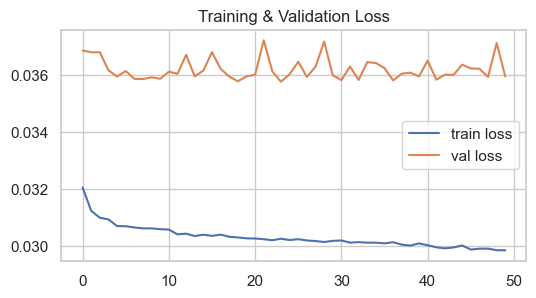

In [148]:
# (Optional) plot the loss curve
plt.figure(figsize=(6,3))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

##### 8. Make Predictions & Inverse‐Transform

In [150]:
# --- Step 8: Make Predictions & Inverse‐Transform ---
#  8a) predict (scaled)
y_pred_scaled = model.predict(X_test)

#  8b) reconstruct a dummy matrix to call scaler.inverse_transform()
n_feats = len(features)  # number of input columns you used
dummy_preds = np.zeros((len(y_pred_scaled), n_feats))
recombined_pred = np.hstack([dummy_preds, y_pred_scaled])  # last col is your target
y_pred = scaler.inverse_transform(recombined_pred)[:, -1]  # pull out the last column

#  8c) same for y_test
dummy_true = np.zeros((len(y_test), n_feats))
recombined_true = np.hstack([dummy_true, y_test.reshape(-1,1)])
y_true = scaler.inverse_transform(recombined_true)[:, -1]

141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step


##### 9. Evaluate the Model

In [152]:
# --- Step 9: Evaluate the Model ---
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 86.60


##### 10. Plot the Results

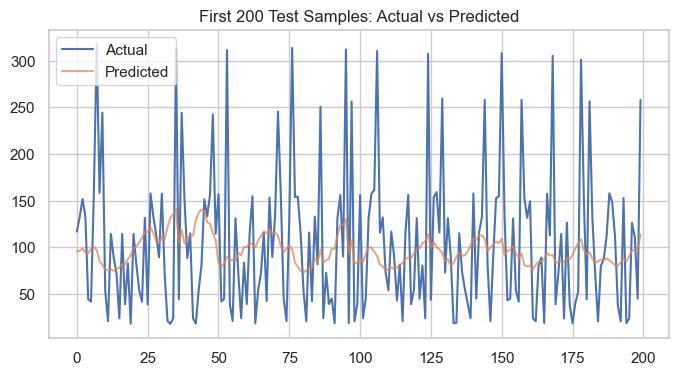

In [154]:
# (Optional) Plot a few predictions vs actuals
plt.figure(figsize=(8,4))
plt.plot(y_true[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted', alpha=0.7)
plt.legend()
plt.title("First 200 Test Samples: Actual vs Predicted")
plt.show()

#### LSTM Modeling - Better Approach

#### LSTM Stock-Prediction Pipeline Explained

#### 1) Configuration

```python
features = [
    'Close', 'Volume',
    'Rolling_Close_Mean_5', 'MACD_diff', 'RSI_14',
    'Inflation_CPI', 'Fed_Funds_Rate', 'GDP_Growth',
    'Is_Earnings_Season'
]
target = 'Target'
seq_length = 60
test_split = 0.2
```

- **`features`**: a list of the columns we’ll feed into the LSTM as inputs at each time step.  
  - Price data (`Close`, `Volume`), technical indicators (`MACD_diff`, `RSI_14`), and macro series (`Inflation_CPI`, etc.).  
- **`target`**: the column we’re trying to predict one day ahead. We built this earlier via  
  ```python
  market_data['Target'] = market_data.groupby('Ticker')['Close'].shift(-1)
  ```  
- **`seq_length`**: how many past days we pass into the LSTM to predict the next day. Here we use 60 (≈3 months of trading).  
- **`test_split`**: fraction of our sequences held out as a test set (20%).

---

#### 2) `run_lstm_for_ticker(df, ticker)`

A **helper function** that encapsulates all the steps—from raw data to final prediction—for a **single ticker**.

```python
def run_lstm_for_ticker(df, ticker):
```

---

##### Step 2a: Subset & Sort

```python
sub = df[df['Ticker']==ticker].sort_values('Date')
```

- **Filter** `df` down to only the rows for our chosen ticker (e.g. “YOU”).  
- **Sort** by date so our time series runs in chronological order.

---

##### Step 2b: Drop Missing Values

```python
sub = sub[features + [target]].dropna()
```

- Keep only the columns listed in `features` plus the `target`.  
- Remove any rows with missing values—this ensures our sequences are fully populated.

---

##### Step 2c: Scale to [0,1]

```python
scaler = MinMaxScaler()
arr = scaler.fit_transform(sub.values)
```

- Neural nets train more stably when inputs live in a small range.  
- We scale **all** columns together so we can later invert the scaling on our predictions.

---

##### Step 2d: Build Sequences

```python
X, y = [], []
for i in range(len(arr) - seq_length):
    X.append(arr[i:i+seq_length, :-1])   # the past seq_length rows of features
    y.append(arr[i+seq_length, -1])      # the next-day target
X = np.array(X)
y = np.array(y)
```

- We slide a window of length `seq_length` over our data.  
- **`X`** is a 3D array of shape `(n_samples, seq_length, n_features)`.  
- **`y`** is a 1D array of the corresponding next-day target values.

---

##### Step 2e: Train/Test Split

```python
split_idx = int((1-test_split) * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
```

- We allocate the first 80% of sequences to **training**, and the last 20% to **testing**.  
- This mimics “future” data the model has never seen.

---

##### Step 2.5: Simple Baselines

Before building the LSTM, we check two naive forecasts on the **test** set:

1. **Naïve “last value”**: predict tomorrow = today.  
2. **Simple Moving Average (SMA)**: 20-day rolling mean of the true prices.

```python
# a) Naïve
close_idx = features.index('Close')
naive_scaled = X_test[:, -1, close_idx]

# b) SMA(20)
true_prices = sub['Close'].values
sma = pd.Series(true_prices).rolling(20).mean().shift(1).values
sma_test = sma[seq_length+split_idx : seq_length+split_idx+len(y_test)]

# Inverse‐scale and compute RMSE
...
print(f"{ticker} baselines → Naive RMSE: {rmse_naive:.2f}, SMA(20) RMSE: {rmse_sma:.2f}")
```

- These give us **benchmarks** to beat. If our LSTM can’t outperform these, we need to rethink.

---

#### 3) Build the LSTM Model

```python
n_feats = X.shape[2]
model = Sequential([
    Input(shape=(seq_length, n_feats)),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
```

- **`Input`** layer declares our `(timesteps, features)` shape.  
- Two stacked **LSTM** layers (50 units each) learn temporal patterns.  
- **Dropout** layers guard against overfitting.  
- A final **Dense(1)** outputs our predicted next-day close.  
- We use **MSE** as our loss and **Adam** for optimization.

---

#### 4) Train with Early Stopping

```python
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=2
)
```

- We hold out 10% of the training data for **validation**.  
- **EarlyStopping** stops training when validation loss hasn’t improved for 5 epochs, and restores the best weights.

---

#### 5) Plot the Loss Curve

```python
plt.figure(figsize=(6,3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title(f"{ticker} Loss Curve")
plt.legend()
plt.show()
```

- This visualizes how training and validation loss evolve.
- A small gap with flat curves usually means you’ve converged.

---

#### 6) Predict & Inverse‐Scale

```python
y_pred_scaled = model.predict(X_test)
zeros = np.zeros((len(y_pred_scaled), n_feats))
inv_pred = scaler.inverse_transform(np.hstack([zeros, y_pred_scaled]))[:, -1]
inv_true = scaler.inverse_transform(np.hstack([zeros, y_test.reshape(-1,1)]))[:, -1]
```

- We **predict** on the test set (still in scaled form).  
- We recreate dummy feature columns of zeros so we can call `scaler.inverse_transform()` on the combined array.  
- The **last column** of the inverse‐transformed array is our real-dollar prediction and true price.

---

#### 7) Evaluate & Plot Actual vs Predicted

```python
rmse = np.sqrt(mean_squared_error(inv_true, inv_pred))
print(f"{ticker} → Test RMSE: {rmse:.2f}")

plt.figure(figsize=(10,4))
plt.plot(inv_true, label='Actual', alpha=0.6)
plt.plot(inv_pred, label='Predicted', alpha=0.8)
plt.title(f"{ticker}: Actual vs Predicted")
plt.legend()
plt.show()
```

- **RMSE** tells us the average dollar-error of our one-day-ahead forecast.  
- The plot shows how closely (or not) our orange line (prediction) tracks the blue line (actual).

---

#### 8) Running it

```python
# For one ticker:
model, scaler = run_lstm_for_ticker(market_data, ticker='YOU')

# Or loop over all tickers:
# models = {}
# for tk in market_data['Ticker'].unique():
#     print("===", tk, "===")
#     models[tk] = run_lstm_for_ticker(market_data, tk)[0]
```

- Call `run_lstm_for_ticker` with your `market_data` and a ticker symbol.  
- It prints baselines, trains the LSTM, and shows you RMSE + plots in one go.  
- You can easily extend this to train separate models for each ticker in your universe.

---

#### Final Thoughts  
- You can tweak for better results:
  - **Feature list** (`features`)  
  - **Sequence length** (`seq_length`)  
  - LSTM **units**, **dropout**, and **architecture**  
  - **Baselines** (e.g. include exponential moving averages)  
- Always compare your LSTM’s RMSE against the simple **naïve** and **SMA** baselines to ensure you’re adding real predictive power.

In [157]:
# --- 1) Configuration: features, target, sequence length ---
features = [
    'Close', 'Volume',
    'Rolling_Close_Mean_5', 'MACD_diff', 'RSI_14',
    'Inflation_CPI', 'Fed_Funds_Rate', 'GDP_Growth',
    'Is_Earnings_Season'
]
target = 'Target'           
seq_length = 60             # how many past days per sample
test_split = 0.2            # fraction of data to hold out

NRG baselines → Naive RMSE: 3.81, SMA(20) RMSE: 5.53
Epoch 1/50
27/27 - 7s - 252ms/step - loss: 0.0037 - val_loss: 0.0476
Epoch 2/50
27/27 - 2s - 58ms/step - loss: 0.0015 - val_loss: 0.0229
Epoch 3/50
27/27 - 2s - 83ms/step - loss: 0.0012 - val_loss: 0.0216
Epoch 4/50
27/27 - 2s - 86ms/step - loss: 9.1921e-04 - val_loss: 0.0127
Epoch 5/50
27/27 - 2s - 85ms/step - loss: 9.6972e-04 - val_loss: 0.0092
Epoch 6/50
27/27 - 3s - 93ms/step - loss: 9.7387e-04 - val_loss: 0.0160
Epoch 7/50
27/27 - 2s - 89ms/step - loss: 7.8049e-04 - val_loss: 0.0091
Epoch 8/50
27/27 - 3s - 121ms/step - loss: 6.9209e-04 - val_loss: 0.0117
Epoch 9/50
27/27 - 5s - 203ms/step - loss: 6.0300e-04 - val_loss: 0.0064
Epoch 10/50
27/27 - 3s - 100ms/step - loss: 5.4770e-04 - val_loss: 0.0066
Epoch 11/50
27/27 - 2s - 68ms/step - loss: 5.4525e-04 - val_loss: 0.0029
Epoch 12/50
27/27 - 2s - 60ms/step - loss: 5.2365e-04 - val_loss: 0.0033
Epoch 13/50
27/27 - 2s - 69ms/step - loss: 5.0026e-04 - val_loss: 0.0053
Epoch 14/50
27/

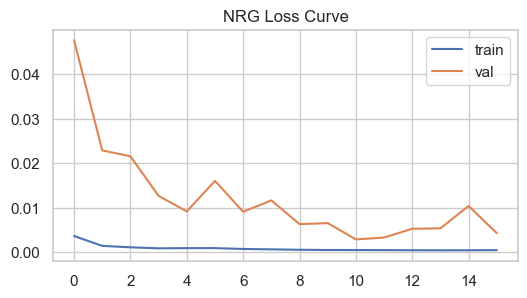

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step
NRG → Test RMSE: 15.98


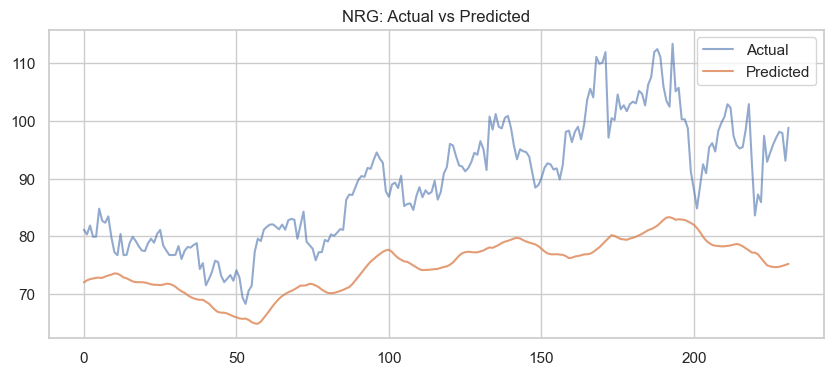

In [163]:
# --- 2) Helper to run pipeline for one ticker ---
def run_lstm_for_ticker(df, ticker):
    # a) subset and sort
    sub = df[df['Ticker']==ticker].sort_values('Date')
    
    # b) drop any rows missing features/target
    sub = sub[features + [target]].dropna()
    
    # c) scale
    scaler = MinMaxScaler()
    arr = scaler.fit_transform(sub.values)   # shape = (n_samples, n_feats+1)
    
    # d) build sequences
    X, y = [], []
    for i in range(len(arr)-seq_length):
        X.append(arr[i:i+seq_length, :-1])   # all features
        y.append(arr[i+seq_length, -1])      # target
    X = np.array(X)
    y = np.array(y)
    
    # e) train/test split
    split_idx = int((1-test_split)*len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # --- 2.5) Compute simple baselines on the *test* set -------------
    # a) Naive last-value forecast
    #    we know that y[i] is the scaled price at step i+seq_length,
    #    so naive_pred_scaled = X_test[:, -1, feature_idx_of_Close]
    #    but if 'Close' was column 0 in features:
    close_idx = features.index('Close')
    naive_scaled = X_test[:, -1, close_idx]
    
    # b) SMA(20) baseline: rolling average of the *true* unscaled prices
    true_prices = sub['Close'].values  # unscaled
    # align to the test target positions:
    sma_window = 20
    sma = pd.Series(true_prices).rolling(sma_window).mean().shift(1).values
    sma_test = sma[seq_length + split_idx : seq_length + split_idx + len(y_test)]
    
    # inverse-scale the naive
    zeros = np.zeros((len(naive_scaled), len(features)))
    pred_naive = scaler.inverse_transform(np.hstack([zeros, naive_scaled.reshape(-1,1)]))[:, -1]
    true_test = scaler.inverse_transform(np.hstack([zeros, y_test.reshape(-1,1)]))[:, -1]
    
    # compute MSEs
    mse_naive = mean_squared_error(true_test, pred_naive)
    mse_sma   = mean_squared_error(true_test, sma_test)
    print(f"{ticker} baselines → Naive RMSE: {np.sqrt(mse_naive):.2f}, SMA({sma_window}) RMSE: {np.sqrt(mse_sma):.2f}")
    # ----------------------------------------------------------------
    
    # --- 3) Build the model ---
    n_feats = X.shape[2]
    model = Sequential([
        Input(shape=(seq_length, n_feats)),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # --- 4) Train with early stopping ---
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=2
    )
    
    # Plot loss curve
    plt.figure(figsize=(6,3))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f"{ticker} Loss Curve")
    plt.legend()
    plt.show()
    
    # --- 5) Predict & inverse‐scale ---
    y_pred_scaled = model.predict(X_test)
    # reconstruct full array to inverse‐transform
    zeros = np.zeros((len(y_pred_scaled), n_feats))
    inv_pred = scaler.inverse_transform(np.hstack([zeros, y_pred_scaled]))[:, -1]
    inv_true = scaler.inverse_transform(np.hstack([zeros, y_test.reshape(-1,1)]))[:, -1]
    
    # --- 6) Evaluate & plot ---
    rmse = np.sqrt(mean_squared_error(inv_true, inv_pred))
    print(f"{ticker} → Test RMSE: {rmse:.2f}")
    
    plt.figure(figsize=(10,4))
    plt.plot(inv_true, label='Actual', alpha=0.6)
    plt.plot(inv_pred, label='Predicted', alpha=0.8)
    plt.title(f"{ticker}: Actual vs Predicted")
    plt.legend()
    plt.show()
    
    return model, scaler

# --- 7) Run it for one ticker ---
model, scaler = run_lstm_for_ticker(market_data, ticker='NRG')

# --- 8) (Optional) Loop over all tickers ---
# models = {}
# for tk in market_data['Ticker'].unique():
#     print("=== Training on", tk, "===")
#     m, s = run_lstm_for_ticker(market_data, tk)
#     models[tk] = m


Using features: ['Close', 'Volume', 'SMA_20', 'EMA_20', 'Volatility_14', 'RSI_14']
NRG baselines → Naive RMSE: 25.38, SMA(20) RMSE: 40.17
Epoch 1/100
26/26 - 11s - 421ms/step - loss: 0.2200 - val_loss: 0.2609 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 103ms/step - loss: 0.1748 - val_loss: 0.1532 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 105ms/step - loss: 0.1610 - val_loss: 0.1306 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 99ms/step - loss: 0.1532 - val_loss: 0.1713 - learning_rate: 0.0010
Epoch 5/100
26/26 - 5s - 199ms/step - loss: 0.1401 - val_loss: 0.1325 - learning_rate: 0.0010
Epoch 6/100
26/26 - 5s - 193ms/step - loss: 0.1258 - val_loss: 0.1448 - learning_rate: 5.0000e-04


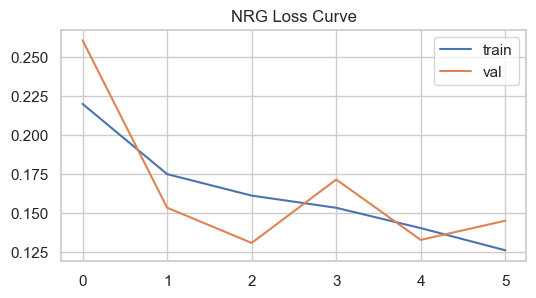

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step
NRG → Test RMSE: 14.20


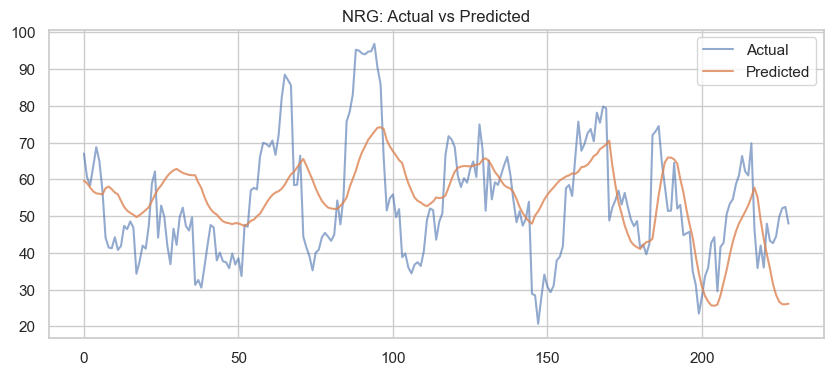

In [183]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

# --- Feature Engineering ---
def add_technical_indicators(df):
    df = df.copy()
    df = df.sort_values(["Ticker", "Date"])

    window = 14

    df["SMA_20"] = df.groupby('Ticker')["Close"].transform(lambda x: x.rolling(20).mean())
    df["EMA_20"] = df.groupby('Ticker')["Close"].transform(lambda x: x.ewm(span=20, adjust=False).mean())
    df["Volatility_14"] = df.groupby('Ticker')["Close"].transform(lambda x: x.pct_change().rolling(window).std())

    def compute_rsi(series, window=14):
        delta = series.diff()
        up = delta.clip(lower=0)
        down = -delta.clip(upper=0)
        ma_up = up.rolling(window).mean()
        ma_down = down.rolling(window).mean()
        rsi = 100 - (100 / (1 + ma_up / ma_down))
        return rsi

    df["RSI_14"] = df.groupby('Ticker')["Close"].transform(lambda x: compute_rsi(x, window))
    
    df = df.dropna(subset=["SMA_20", "EMA_20", "Volatility_14", "RSI_14"])

    return df

# --- Set your features ---
default_features = ["Close", "Volume", "SMA_20", "EMA_20", "Volatility_14", "RSI_14"]
target = "Close"
seq_length = 90
test_split = 0.2

# --- Main LSTM Training Pipeline ---
def run_lstm_for_ticker(df, ticker):
    sub = df[df['Ticker'] == ticker].sort_values('Date')
    
    # Filter features that actually exist
    features = [feat for feat in default_features if feat in sub.columns]
    if target not in features:
        features.append(target)

    print(f"Using features: {features}")

    sub = sub[features].dropna()

    if len(sub) == 0:
        print(f"[Warning] No data available for {ticker}. Skipping.")
        return None, None

    scaler = MinMaxScaler()
    arr = scaler.fit_transform(sub.values)

    X, y = [], []
    for i in range(len(arr) - seq_length):
        X.append(arr[i:i+seq_length, :-1])
        y.append(arr[i+seq_length, -1])
    X = np.array(X)
    y = np.array(y)

    if len(X) == 0:
        print(f"[Warning] Not enough data after sequence building for {ticker}. Skipping.")
        return None, None

    split_idx = int((1-test_split) * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    close_idx = features.index('Close')
    naive_scaled = X_test[:, -1, close_idx]
    true_prices = sub['Close'].values
    sma_window = 20
    sma = pd.Series(true_prices).rolling(sma_window).mean().shift(1).values
    sma_test = sma[seq_length + split_idx : seq_length + split_idx + len(y_test)]

    # Naive baseline prediction
    zeros = np.zeros((len(naive_scaled), len(features) - 1))
    pred_naive = scaler.inverse_transform(np.hstack([zeros, naive_scaled.reshape(-1,1)]))[:, -1]
    true_test = scaler.inverse_transform(np.hstack([zeros, y_test.reshape(-1,1)]))[:, -1]

    mse_naive = mean_squared_error(true_test, pred_naive)
    mse_sma = mean_squared_error(true_test, sma_test)
    print(f"{ticker} baselines → Naive RMSE: {np.sqrt(mse_naive):.2f}, SMA({sma_window}) RMSE: {np.sqrt(mse_sma):.2f}")

    n_feats = X.shape[2]
    n_total_cols = n_feats + 1  # Features + Target

    model = Sequential([
        Input(shape=(seq_length, n_feats)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')

    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=32,
        callbacks=[es, reduce_lr],
        verbose=2
    )

    # --- Loss Curve ---
    plt.figure(figsize=(6,3))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f"{ticker} Loss Curve")
    plt.legend()
    plt.show()

    # --- Predict with fixed batch_size ---
    y_pred_scaled = model.predict(X_test, batch_size=32)

    # Correct dummy padding for inverse scaling
    zeros_pred = np.zeros((len(y_pred_scaled), n_total_cols - 1))
    inv_pred = scaler.inverse_transform(np.hstack([zeros_pred, y_pred_scaled]))[:, -1]

    zeros_true = np.zeros((len(y_test), n_total_cols - 1))
    inv_true = scaler.inverse_transform(np.hstack([zeros_true, y_test.reshape(-1,1)]))[:, -1]

    rmse = np.sqrt(mean_squared_error(inv_true, inv_pred))
    print(f"{ticker} → Test RMSE: {rmse:.2f}")

    # --- Plot Actual vs Predicted ---
    plt.figure(figsize=(10,4))
    plt.plot(inv_true, label='Actual', alpha=0.6)
    plt.plot(inv_pred, label='Predicted', alpha=0.8)
    plt.title(f"{ticker}: Actual vs Predicted")
    plt.legend()
    plt.show()

    return model, scaler

# --- 7) Run it for one ticker ---
# First create your processed dataframe
df = add_technical_indicators(market_data)

# Then run your model
model, scaler = run_lstm_for_ticker(df, ticker='NRG')



Found 19 tickers: ['AEP' 'APD' 'ATO' 'AWK' 'CVX' 'DUK-PA' 'EIX' 'FE' 'HES' 'NEE-PR' 'NEM'
 'NISTF' 'NRG' 'PCG' 'SHW' 'STLD' 'VLO' 'XEL' 'XOM']
Training LSTM for AEP
Using features: ['Close', 'Volume', 'SMA_20', 'EMA_20', 'Volatility_14', 'RSI_14']
AEP baselines → Naive RMSE: 22.61, SMA(20) RMSE: 45.35
Epoch 1/100
26/26 - 11s - 428ms/step - loss: 0.2379 - val_loss: 0.1432 - learning_rate: 0.0010
Epoch 2/100
26/26 - 4s - 150ms/step - loss: 0.1457 - val_loss: 0.1367 - learning_rate: 0.0010
Epoch 3/100
26/26 - 4s - 172ms/step - loss: 0.1198 - val_loss: 0.1382 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 97ms/step - loss: 0.1179 - val_loss: 0.1201 - learning_rate: 0.0010
Epoch 5/100
26/26 - 4s - 138ms/step - loss: 0.1021 - val_loss: 0.1088 - learning_rate: 0.0010
Epoch 6/100
26/26 - 5s - 181ms/step - loss: 0.1012 - val_loss: 0.0964 - learning_rate: 0.0010
Epoch 7/100
26/26 - 3s - 100ms/step - loss: 0.0948 - val_loss: 0.1043 - learning_rate: 0.0010
Epoch 8/100
26/26 - 3s - 102ms/step - l

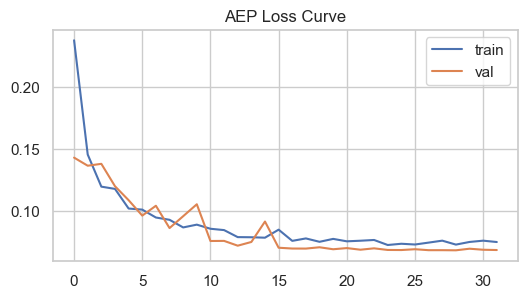

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
AEP → Test RMSE: 10.18


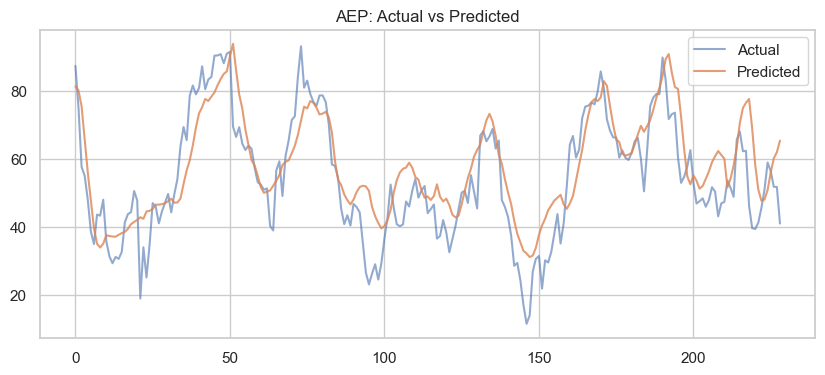

Training LSTM for APD
Using features: ['Close', 'Volume', 'SMA_20', 'EMA_20', 'Volatility_14', 'RSI_14']
APD baselines → Naive RMSE: 29.54, SMA(20) RMSE: 239.52
Epoch 1/100
26/26 - 11s - 428ms/step - loss: 0.2192 - val_loss: 0.2005 - learning_rate: 0.0010
Epoch 2/100
26/26 - 4s - 156ms/step - loss: 0.1515 - val_loss: 0.1562 - learning_rate: 0.0010
Epoch 3/100
26/26 - 4s - 136ms/step - loss: 0.1300 - val_loss: 0.1189 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 133ms/step - loss: 0.1100 - val_loss: 0.1236 - learning_rate: 0.0010
Epoch 5/100
26/26 - 4s - 142ms/step - loss: 0.1034 - val_loss: 0.0981 - learning_rate: 0.0010
Epoch 6/100
26/26 - 2s - 96ms/step - loss: 0.0921 - val_loss: 0.1093 - learning_rate: 0.0010
Epoch 7/100
26/26 - 3s - 110ms/step - loss: 0.0900 - val_loss: 0.0945 - learning_rate: 0.0010
Epoch 8/100
26/26 - 3s - 125ms/step - loss: 0.0889 - val_loss: 0.0830 - learning_rate: 0.0010
Epoch 9/100
26/26 - 3s - 134ms/step - loss: 0.0839 - val_loss: 0.0866 - learning_rate: 

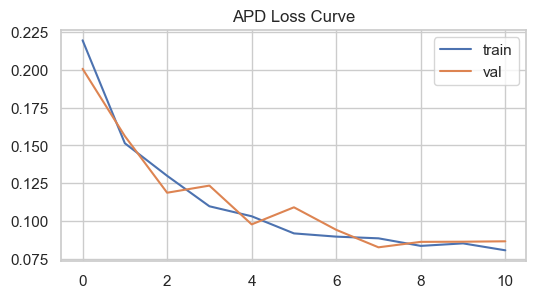

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
APD → Test RMSE: 10.85


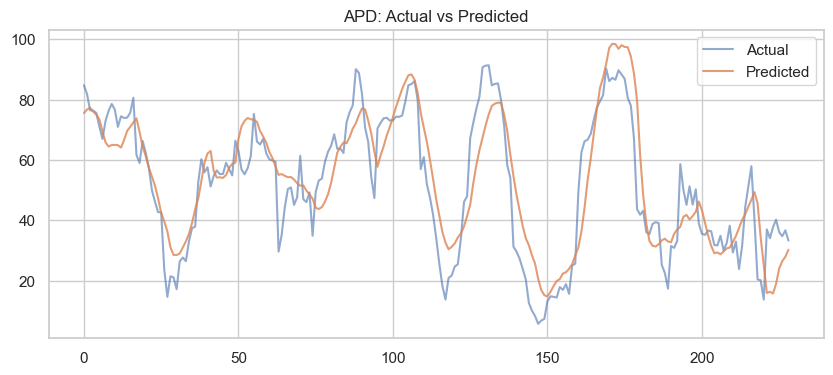

Training LSTM for ATO
Using features: ['Close', 'Volume', 'SMA_20', 'EMA_20', 'Volatility_14', 'RSI_14']
ATO baselines → Naive RMSE: 20.48, SMA(20) RMSE: 78.79
Epoch 1/100
26/26 - 12s - 447ms/step - loss: 0.2290 - val_loss: 0.1261 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 113ms/step - loss: 0.1599 - val_loss: 0.1326 - learning_rate: 0.0010
Epoch 3/100
26/26 - 4s - 138ms/step - loss: 0.1488 - val_loss: 0.1112 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 96ms/step - loss: 0.1452 - val_loss: 0.1071 - learning_rate: 0.0010
Epoch 5/100
26/26 - 3s - 103ms/step - loss: 0.1353 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 6/100
26/26 - 5s - 191ms/step - loss: 0.1280 - val_loss: 0.1479 - learning_rate: 0.0010
Epoch 7/100
26/26 - 3s - 100ms/step - loss: 0.1179 - val_loss: 0.1147 - learning_rate: 5.0000e-04


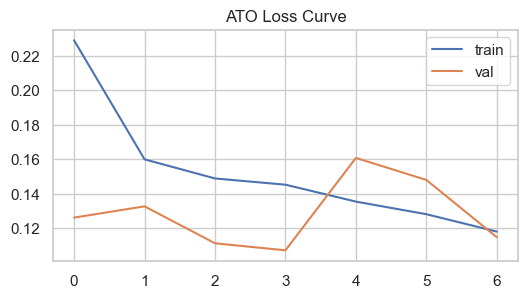

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
ATO → Test RMSE: 16.10


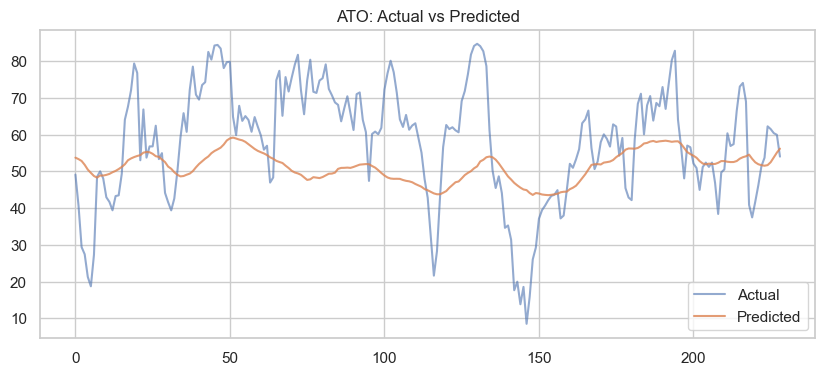

Training LSTM for AWK
Using features: ['Close', 'Volume', 'SMA_20', 'EMA_20', 'Volatility_14', 'RSI_14']
AWK baselines → Naive RMSE: 19.21, SMA(20) RMSE: 84.62
Epoch 1/100
26/26 - 13s - 484ms/step - loss: 0.2141 - val_loss: 0.1546 - learning_rate: 0.0010
Epoch 2/100
26/26 - 6s - 215ms/step - loss: 0.1583 - val_loss: 0.1210 - learning_rate: 0.0010
Epoch 3/100
26/26 - 8s - 314ms/step - loss: 0.1319 - val_loss: 0.1088 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 130ms/step - loss: 0.1153 - val_loss: 0.0981 - learning_rate: 0.0010
Epoch 5/100
26/26 - 4s - 168ms/step - loss: 0.1006 - val_loss: 0.0919 - learning_rate: 0.0010
Epoch 6/100
26/26 - 4s - 170ms/step - loss: 0.1079 - val_loss: 0.0865 - learning_rate: 0.0010
Epoch 7/100
26/26 - 6s - 226ms/step - loss: 0.0942 - val_loss: 0.0844 - learning_rate: 0.0010
Epoch 8/100
26/26 - 5s - 211ms/step - loss: 0.0946 - val_loss: 0.0813 - learning_rate: 0.0010
Epoch 9/100
26/26 - 8s - 327ms/step - loss: 0.0939 - val_loss: 0.0777 - learning_rate: 

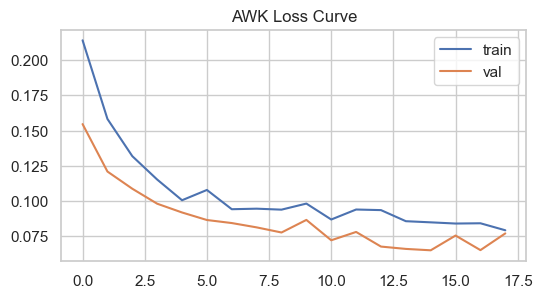

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
AWK → Test RMSE: 9.35


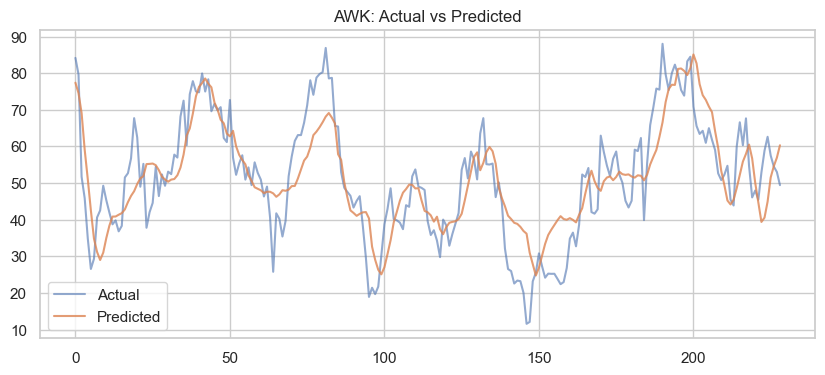

Training LSTM for CVX
Using features: ['Close', 'Volume', 'SMA_20', 'EMA_20', 'Volatility_14', 'RSI_14']
CVX baselines → Naive RMSE: 31.72, SMA(20) RMSE: 101.49
Epoch 1/100
26/26 - 9s - 337ms/step - loss: 0.2235 - val_loss: 0.2026 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 111ms/step - loss: 0.1694 - val_loss: 0.1414 - learning_rate: 0.0010
Epoch 3/100
26/26 - 6s - 243ms/step - loss: 0.1687 - val_loss: 0.1694 - learning_rate: 0.0010
Epoch 4/100
26/26 - 5s - 187ms/step - loss: 0.1551 - val_loss: 0.2011 - learning_rate: 0.0010
Epoch 5/100
26/26 - 4s - 150ms/step - loss: 0.1488 - val_loss: 0.1405 - learning_rate: 5.0000e-04
Epoch 6/100
26/26 - 4s - 161ms/step - loss: 0.1441 - val_loss: 0.1667 - learning_rate: 5.0000e-04
Epoch 7/100
26/26 - 3s - 99ms/step - loss: 0.1401 - val_loss: 0.1501 - learning_rate: 5.0000e-04
Epoch 8/100
26/26 - 3s - 103ms/step - loss: 0.1350 - val_loss: 0.1313 - learning_rate: 2.5000e-04
Epoch 9/100
26/26 - 5s - 196ms/step - loss: 0.1250 - val_loss: 0.1373 - 

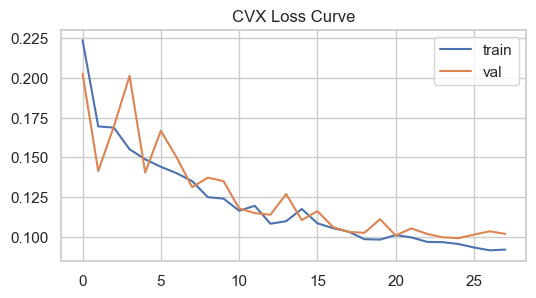

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step
CVX → Test RMSE: 10.36


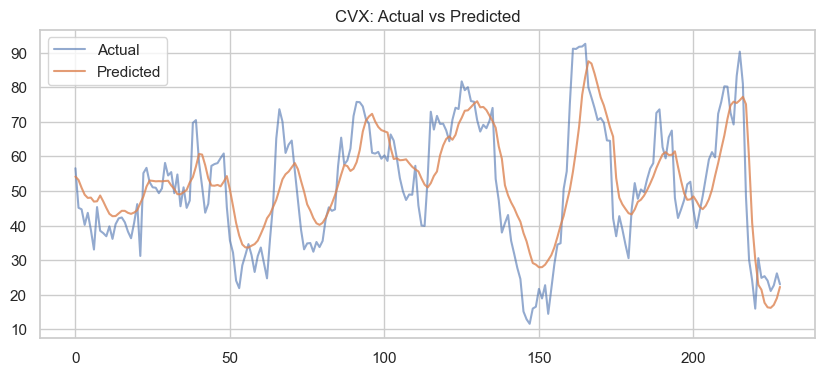

Training LSTM for DUK-PA
Using features: ['Close', 'Volume', 'SMA_20', 'EMA_20', 'Volatility_14', 'RSI_14']
DUK-PA baselines → Naive RMSE: 37.22, SMA(20) RMSE: 30.43
Epoch 1/100
26/26 - 12s - 446ms/step - loss: 0.1663 - val_loss: 0.0996 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 102ms/step - loss: 0.1414 - val_loss: 0.1499 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 110ms/step - loss: 0.1319 - val_loss: 0.0933 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 128ms/step - loss: 0.1195 - val_loss: 0.0754 - learning_rate: 0.0010
Epoch 5/100
26/26 - 5s - 196ms/step - loss: 0.1079 - val_loss: 0.0749 - learning_rate: 0.0010
Epoch 6/100
26/26 - 6s - 214ms/step - loss: 0.0991 - val_loss: 0.0973 - learning_rate: 0.0010
Epoch 7/100


KeyboardInterrupt: 

In [185]:
# --- Train and evaluate LSTM for all tickers ---
def run_lstm_across_tickers(df, ticker_list):
    results = {}  # store RMSEs
    models = {}   # optionally store trained models if you want

    for ticker in ticker_list:
        print("="*40)
        print(f"Training LSTM for {ticker}")
        print("="*40)
        try:
            model, scaler = run_lstm_for_ticker(df, ticker)
            if model is not None:
                models[ticker] = model  # if you want to save models
                results[ticker] = model.history.history  # store history if you want
        except Exception as e:
            print(f"Error training {ticker}: {e}")

    return models, results

# --- Leaderboard creation ---
def leaderboard(models, results):
    # We'll store final test RMSEs
    leaderboard = {}

    for ticker, history in results.items():
        try:
            final_val_loss = history['val_loss'][-1]
            leaderboard[ticker] = np.sqrt(final_val_loss)
        except:
            continue

    leaderboard = pd.DataFrame.from_dict(leaderboard, orient='index', columns=['Test_RMSE'])
    leaderboard = leaderboard.sort_values('Test_RMSE')
    
    # Show
    print("\n🏆 Leaderboard (lower RMSE = better):\n")
    print(leaderboard)

    # Plot
    plt.figure(figsize=(12,6))
    leaderboard['Test_RMSE'].plot(kind='bar')
    plt.title("Ticker Prediction Leaderboard")
    plt.ylabel("Test RMSE")
    plt.grid(True)
    plt.show()

    return leaderboard

# --- Example usage ---
# Step 1: Add indicators
df = add_technical_indicators(market_data)

# Step 2: Get all tickers
tickers = df['Ticker'].unique()
print(f"Found {len(tickers)} tickers: {tickers}")

# Step 3: Train all
models, results = run_lstm_across_tickers(df, tickers)

# Step 4: Show leaderboard
lb = leaderboard(models, results)


20:03:31 - cmdstanpy - INFO - Chain [1] start processing
20:03:33 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
24/24 - 9s - 377ms/step - loss: 0.0490 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 2/100
24/24 - 4s - 187ms/step - loss: 0.0257 - val_loss: 0.0469 - learning_rate: 0.0010
Epoch 3/100
24/24 - 3s - 109ms/step - loss: 0.0207 - val_loss: 0.0342 - learning_rate: 0.0010
Epoch 4/100
24/24 - 3s - 110ms/step - loss: 0.0199 - val_loss: 0.0353 - learning_rate: 5.0000e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step
NRG → Improved Hybrid Prophet+LSTM Test RMSE: 12.81


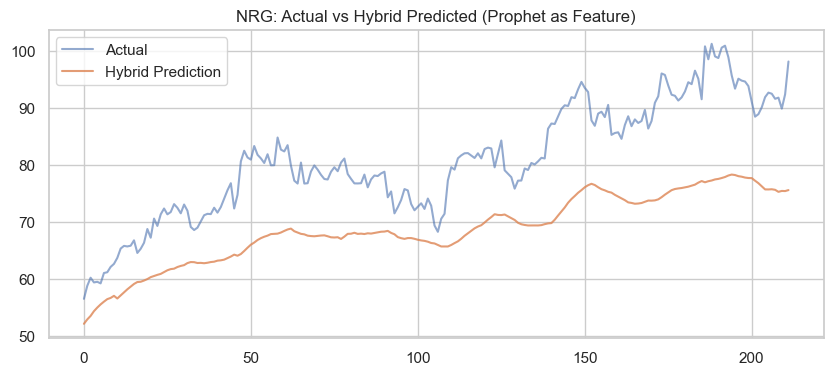

In [189]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from prophet import Prophet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# --- Feature Engineering ---
def add_technical_indicators(df):
    df = df.copy()
    df = df.sort_values(["Ticker", "Date"])
    window = 14
    df["SMA_20"] = df.groupby('Ticker')["Close"].transform(lambda x: x.rolling(20).mean())
    df["EMA_20"] = df.groupby('Ticker')["Close"].transform(lambda x: x.ewm(span=20, adjust=False).mean())
    df["Volatility_14"] = df.groupby('Ticker')["Close"].transform(lambda x: x.pct_change().rolling(window).std())
    def compute_rsi(series, window=14):
        delta = series.diff()
        up = delta.clip(lower=0)
        down = -delta.clip(upper=0)
        ma_up = up.rolling(window).mean()
        ma_down = down.rolling(window).mean()
        rsi = 100 - (100 / (1 + ma_up / ma_down))
        return rsi
    df["RSI_14"] = df.groupby('Ticker')["Close"].transform(lambda x: compute_rsi(x, window))
    df = df.dropna(subset=["SMA_20", "EMA_20", "Volatility_14", "RSI_14"])
    return df

# --- Improved Prophet+LSTM Pipeline ---
def run_prophet_as_feature_lstm(df, ticker, seq_length=90, test_split=0.2):
    sub = df[df['Ticker'] == ticker].sort_values('Date')
    sub = sub.dropna()

    if len(sub) < seq_length + 30:
        print(f"[Warning] Not enough data for {ticker}. Skipping.")
        return None, None

    # --- Step 1: Prophet trend modeling ---
    prophet_df = sub[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    prophet = Prophet(daily_seasonality=True)
    prophet.fit(prophet_df)

    future = prophet.make_future_dataframe(periods=0)
    forecast = prophet.predict(future)
    prophet_trend = forecast['yhat'].values  # the forecasted trend

    # --- Step 2: Add Prophet trend as a new feature ---
    sub['Prophet_Trend'] = prophet_trend

    # --- Step 3: Prepare Features ---
    features = ["Close", "Volume", "SMA_20", "EMA_20", "Volatility_14", "RSI_14", "Prophet_Trend"]
    features = [feat for feat in features if feat in sub.columns]

    X_features = sub[features].values
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_features)

    scaler_y = MinMaxScaler()
    y_target = sub['Close'].values.reshape(-1,1)
    y_scaled = scaler_y.fit_transform(y_target)

    # --- Step 4: Build sequences ---
    X, y = [], []
    for i in range(len(X_scaled) - seq_length):
        X.append(X_scaled[i:i+seq_length])
        y.append(y_scaled[i+seq_length])
    X = np.array(X)
    y = np.array(y)

    if len(X) == 0:
        print(f"[Warning] Not enough sequence data for {ticker}. Skipping.")
        return None, None

    split_idx = int((1-test_split) * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # --- Step 5: Build and train LSTM ---
    n_feats = X.shape[2]
    model = Sequential([
        Input(shape=(seq_length, n_feats)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')

    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=32,
        callbacks=[es, reduce_lr],
        verbose=2
    )

    # --- Step 6: Predict and evaluate ---
    y_pred_scaled = model.predict(X_test, batch_size=32)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
    y_true = scaler_y.inverse_transform(y_test).flatten()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{ticker} → Improved Hybrid Prophet+LSTM Test RMSE: {rmse:.2f}")

    # --- Plot ---
    plt.figure(figsize=(10,4))
    plt.plot(y_true, label='Actual', alpha=0.6)
    plt.plot(y_pred, label='Hybrid Prediction', alpha=0.8)
    plt.title(f"{ticker}: Actual vs Hybrid Predicted (Prophet as Feature)")
    plt.legend()
    plt.show()

    return model, prophet

# --- 7) Run it ---
# Assume you already have market_data
df = add_technical_indicators(market_data)

# Pick a stock
model, prophet = run_prophet_as_feature_lstm(df, ticker='NRG')


20:08:08 - cmdstanpy - INFO - Chain [1] start processing


Tickers found: ['AEP' 'APD' 'ATO' 'AWK' 'CVX' 'DUK-PA' 'EIX' 'FE' 'HES' 'NEE-PR' 'NEM'
 'NISTF' 'NRG' 'PCG' 'SHW' 'STLD' 'VLO' 'XEL' 'XOM']
Training Prophet+LSTM for AEP


20:08:09 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 10s - 379ms/step - loss: 0.0810 - val_loss: 0.0378 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 124ms/step - loss: 0.0493 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 3/100
26/26 - 5s - 177ms/step - loss: 0.0477 - val_loss: 0.0313 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 123ms/step - loss: 0.0515 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 5/100
26/26 - 3s - 120ms/step - loss: 0.0415 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 6/100
26/26 - 3s - 101ms/step - loss: 0.0430 - val_loss: 0.0300 - learning_rate: 0.0010
Epoch 7/100
26/26 - 6s - 223ms/step - loss: 0.0417 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 8/100
26/26 - 3s - 105ms/step - loss: 0.0388 - val_loss: 0.0279 - learning_rate: 5.0000e-04
Epoch 9/100
26/26 - 3s - 109ms/step - loss: 0.0375 - val_loss: 0.0274 - learning_rate: 5.0000e-04
Epoch 10/100
26/26 - 3s - 126ms/step - loss: 0.0399 - val_loss: 0.0290 - learning_rate: 5.0000e-04
Epoch 11/100
26/26 - 3s - 123ms/step - loss: 0

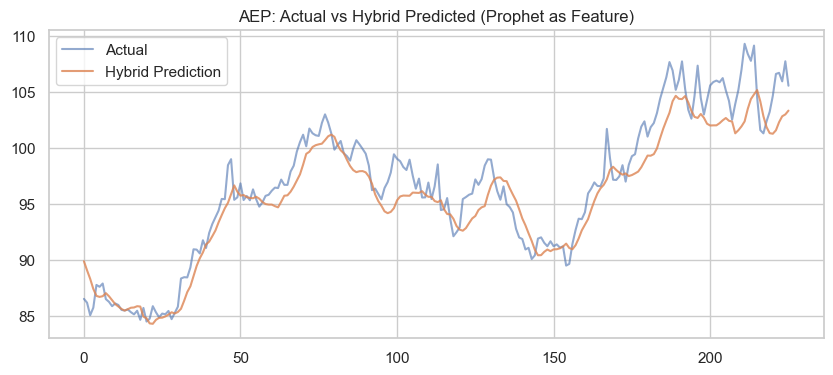

20:09:46 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for APD


20:09:47 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 11s - 417ms/step - loss: 0.1172 - val_loss: 0.0442 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 130ms/step - loss: 0.0631 - val_loss: 0.0469 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 127ms/step - loss: 0.0572 - val_loss: 0.0372 - learning_rate: 0.0010
Epoch 4/100
26/26 - 5s - 174ms/step - loss: 0.0528 - val_loss: 0.0454 - learning_rate: 0.0010
Epoch 5/100
26/26 - 5s - 196ms/step - loss: 0.0537 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 6/100
26/26 - 3s - 106ms/step - loss: 0.0490 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 7/100
26/26 - 3s - 106ms/step - loss: 0.0520 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 8/100
26/26 - 4s - 144ms/step - loss: 0.0474 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 9/100
26/26 - 3s - 100ms/step - loss: 0.0496 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 10/100
26/26 - 3s - 108ms/step - loss: 0.0470 - val_loss: 0.0401 - learning_rate: 0.0010
Epoch 11/100
26/26 - 5s - 193ms/step - loss: 0.0462 - val_

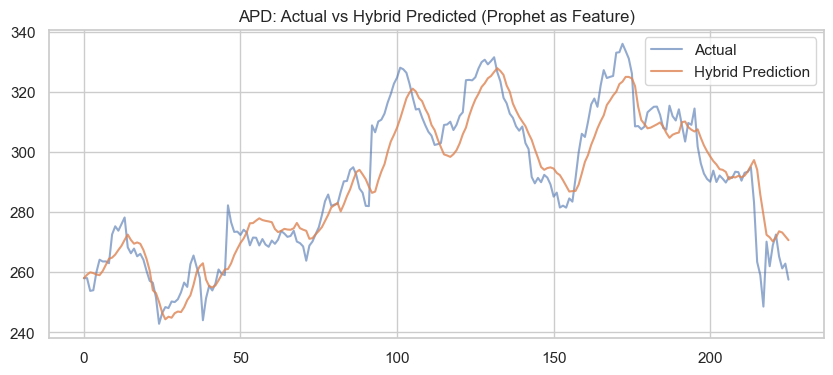

20:10:40 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for ATO


20:10:41 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 14s - 523ms/step - loss: 0.0880 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 117ms/step - loss: 0.0413 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 3/100
26/26 - 5s - 183ms/step - loss: 0.0377 - val_loss: 0.0372 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 98ms/step - loss: 0.0346 - val_loss: 0.0178 - learning_rate: 5.0000e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
ATO → Improved Hybrid Prophet+LSTM Test RMSE: 4.27


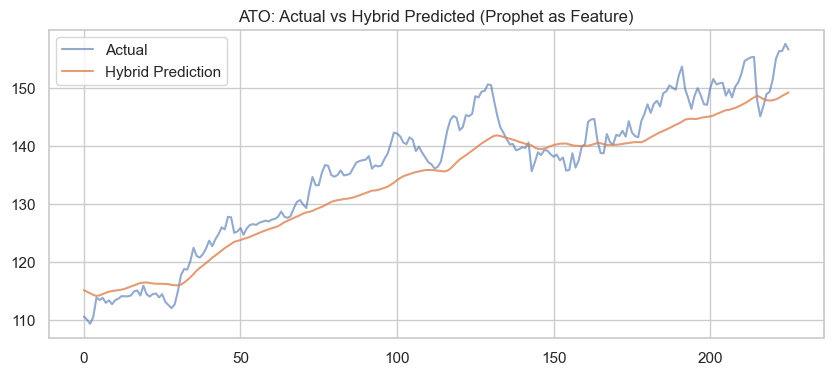

20:11:07 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for AWK


20:11:08 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 9s - 345ms/step - loss: 0.1161 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 111ms/step - loss: 0.0718 - val_loss: 0.0406 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 128ms/step - loss: 0.0638 - val_loss: 0.0313 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 117ms/step - loss: 0.0620 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 5/100
26/26 - 3s - 103ms/step - loss: 0.0629 - val_loss: 0.0249 - learning_rate: 0.0010
Epoch 6/100
26/26 - 5s - 198ms/step - loss: 0.0583 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 7/100
26/26 - 3s - 100ms/step - loss: 0.0640 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 8/100
26/26 - 3s - 101ms/step - loss: 0.0592 - val_loss: 0.0266 - learning_rate: 5.0000e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
AWK → Improved Hybrid Prophet+LSTM Test RMSE: 3.77


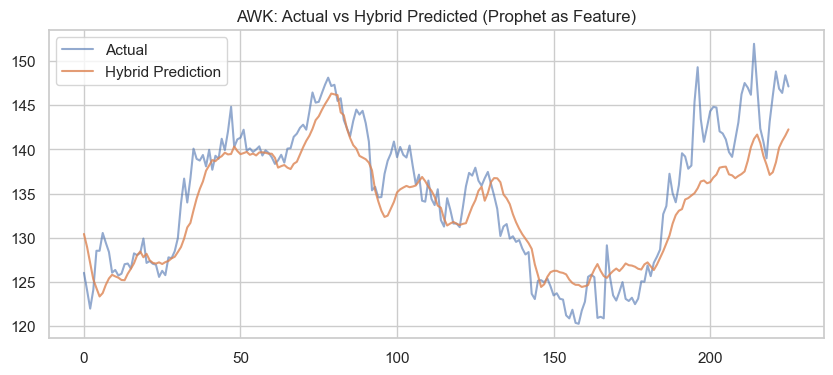

20:11:44 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for CVX


20:11:45 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 9s - 359ms/step - loss: 0.1647 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 102ms/step - loss: 0.0757 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 103ms/step - loss: 0.0673 - val_loss: 0.0366 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 101ms/step - loss: 0.0618 - val_loss: 0.0281 - learning_rate: 0.0010
Epoch 5/100
26/26 - 3s - 98ms/step - loss: 0.0562 - val_loss: 0.0260 - learning_rate: 5.0000e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
CVX → Improved Hybrid Prophet+LSTM Test RMSE: 5.81


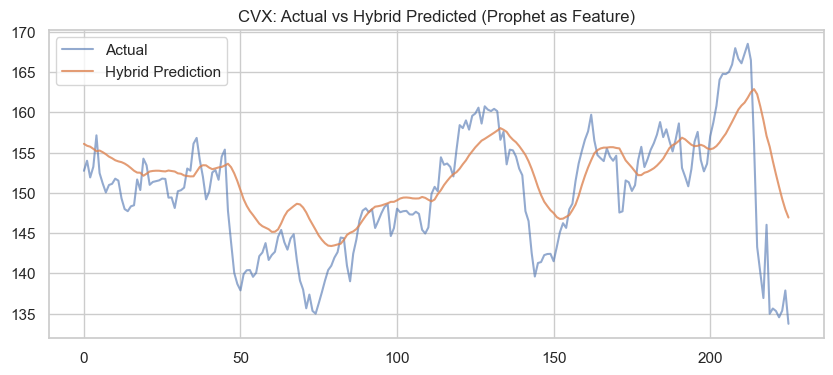

20:12:07 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for DUK-PA


20:12:08 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 9s - 356ms/step - loss: 0.1260 - val_loss: 0.1253 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 98ms/step - loss: 0.0611 - val_loss: 0.0563 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 107ms/step - loss: 0.0579 - val_loss: 0.0230 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 98ms/step - loss: 0.0563 - val_loss: 0.0598 - learning_rate: 0.0010
Epoch 5/100
26/26 - 3s - 97ms/step - loss: 0.0494 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 6/100
26/26 - 3s - 99ms/step - loss: 0.0487 - val_loss: 0.0591 - learning_rate: 5.0000e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step
DUK-PA → Improved Hybrid Prophet+LSTM Test RMSE: 0.19


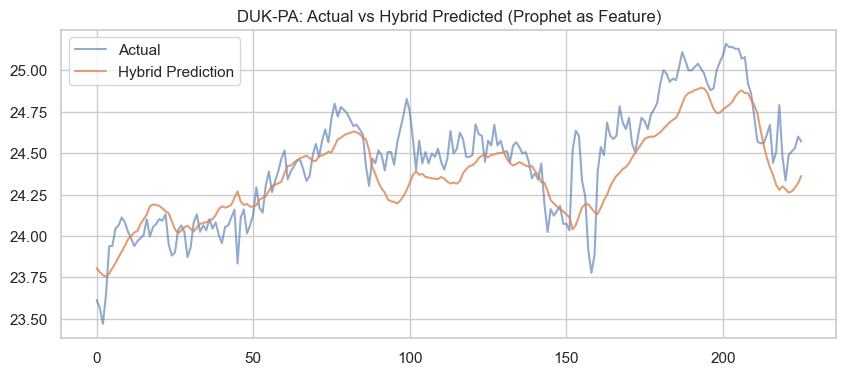

20:12:33 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for EIX


20:12:33 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 12s - 457ms/step - loss: 0.0994 - val_loss: 0.0555 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 134ms/step - loss: 0.0499 - val_loss: 0.0286 - learning_rate: 0.0010
Epoch 3/100
26/26 - 6s - 242ms/step - loss: 0.0452 - val_loss: 0.0248 - learning_rate: 0.0010
Epoch 4/100
26/26 - 4s - 162ms/step - loss: 0.0442 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 5/100
26/26 - 4s - 166ms/step - loss: 0.0395 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 6/100
26/26 - 3s - 107ms/step - loss: 0.0393 - val_loss: 0.0231 - learning_rate: 5.0000e-04
Epoch 7/100
26/26 - 3s - 101ms/step - loss: 0.0388 - val_loss: 0.0199 - learning_rate: 5.0000e-04
Epoch 8/100
26/26 - 3s - 100ms/step - loss: 0.0373 - val_loss: 0.0202 - learning_rate: 5.0000e-04
Epoch 9/100
26/26 - 3s - 124ms/step - loss: 0.0363 - val_loss: 0.0230 - learning_rate: 5.0000e-04
Epoch 10/100
26/26 - 3s - 106ms/step - loss: 0.0354 - val_loss: 0.0201 - learning_rate: 2.5000e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step

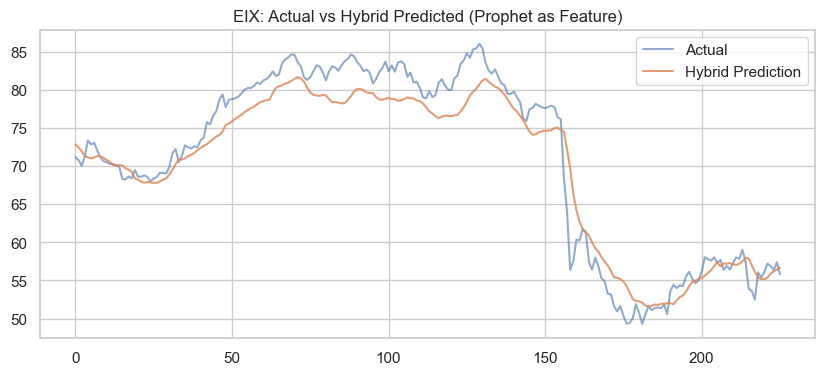

20:13:20 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for FE


20:13:20 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 10s - 384ms/step - loss: 0.1305 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 2/100
26/26 - 4s - 141ms/step - loss: 0.0658 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 100ms/step - loss: 0.0665 - val_loss: 0.0244 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 102ms/step - loss: 0.0606 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 5/100
26/26 - 3s - 103ms/step - loss: 0.0579 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 6/100
26/26 - 3s - 102ms/step - loss: 0.0584 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 7/100
26/26 - 3s - 100ms/step - loss: 0.0583 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 8/100
26/26 - 3s - 110ms/step - loss: 0.0531 - val_loss: 0.0264 - learning_rate: 0.0010
Epoch 9/100
26/26 - 3s - 124ms/step - loss: 0.0529 - val_loss: 0.0199 - learning_rate: 0.0010
Epoch 10/100
26/26 - 3s - 105ms/step - loss: 0.0588 - val_loss: 0.0216 - learning_rate: 0.0010
Epoch 11/100
26/26 - 3s - 99ms/step - loss: 0.0553 - val_l

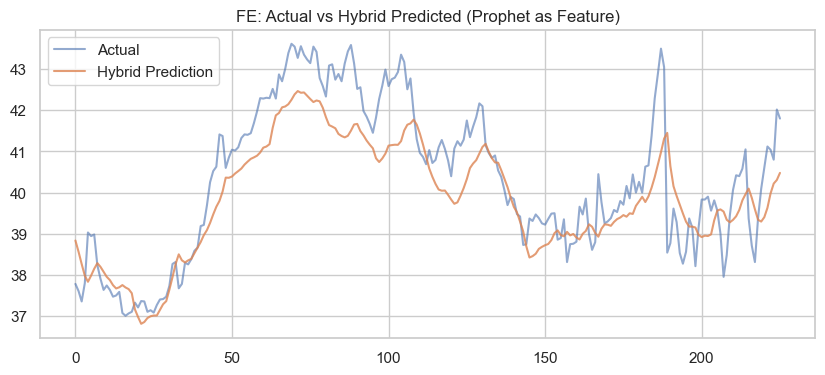

20:14:16 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for HES


20:14:17 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 11s - 430ms/step - loss: 0.1175 - val_loss: 0.0426 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 103ms/step - loss: 0.0687 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 103ms/step - loss: 0.0662 - val_loss: 0.0504 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 122ms/step - loss: 0.0590 - val_loss: 0.0589 - learning_rate: 0.0010
Epoch 5/100
26/26 - 3s - 111ms/step - loss: 0.0582 - val_loss: 0.0212 - learning_rate: 5.0000e-04
Epoch 6/100
26/26 - 3s - 102ms/step - loss: 0.0566 - val_loss: 0.0240 - learning_rate: 5.0000e-04
Epoch 7/100
26/26 - 3s - 102ms/step - loss: 0.0524 - val_loss: 0.0179 - learning_rate: 5.0000e-04
Epoch 8/100
26/26 - 3s - 117ms/step - loss: 0.0525 - val_loss: 0.0414 - learning_rate: 5.0000e-04
Epoch 9/100
26/26 - 3s - 98ms/step - loss: 0.0565 - val_loss: 0.0189 - learning_rate: 5.0000e-04
Epoch 10/100
26/26 - 3s - 106ms/step - loss: 0.0527 - val_loss: 0.0175 - learning_rate: 2.5000e-04
Epoch 11/100
26/26 - 3s - 104ms/ste

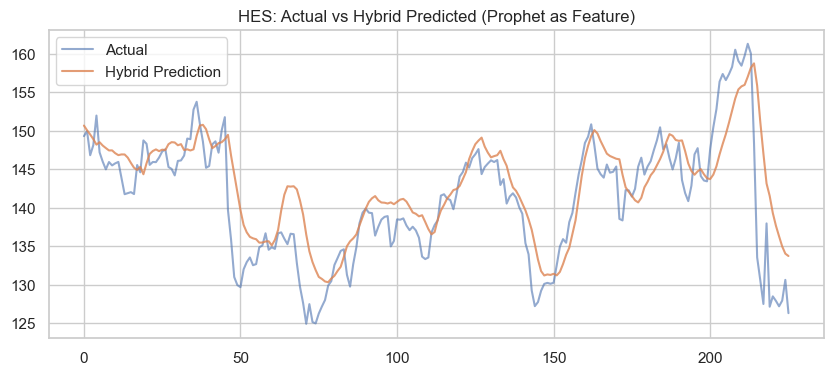

20:15:09 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for NEE-PR


20:15:09 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
12/12 - 11s - 926ms/step - loss: 0.1605 - val_loss: 0.0688 - learning_rate: 0.0010
Epoch 2/100
12/12 - 2s - 180ms/step - loss: 0.0888 - val_loss: 0.0703 - learning_rate: 0.0010
Epoch 3/100
12/12 - 1s - 105ms/step - loss: 0.0681 - val_loss: 0.0636 - learning_rate: 0.0010
Epoch 4/100
12/12 - 2s - 153ms/step - loss: 0.0667 - val_loss: 0.0474 - learning_rate: 0.0010
Epoch 5/100
12/12 - 2s - 182ms/step - loss: 0.0636 - val_loss: 0.0649 - learning_rate: 0.0010
Epoch 6/100
12/12 - 2s - 169ms/step - loss: 0.0649 - val_loss: 0.0962 - learning_rate: 0.0010
Epoch 7/100
12/12 - 2s - 187ms/step - loss: 0.0634 - val_loss: 0.0468 - learning_rate: 5.0000e-04
Epoch 8/100
12/12 - 5s - 431ms/step - loss: 0.0597 - val_loss: 0.0505 - learning_rate: 5.0000e-04
Epoch 9/100
12/12 - 1s - 120ms/step - loss: 0.0587 - val_loss: 0.0461 - learning_rate: 5.0000e-04
Epoch 10/100
12/12 - 1s - 102ms/step - loss: 0.0574 - val_loss: 0.0562 - learning_rate: 5.0000e-04
Epoch 11/100
12/12 - 1s - 108ms/step - los

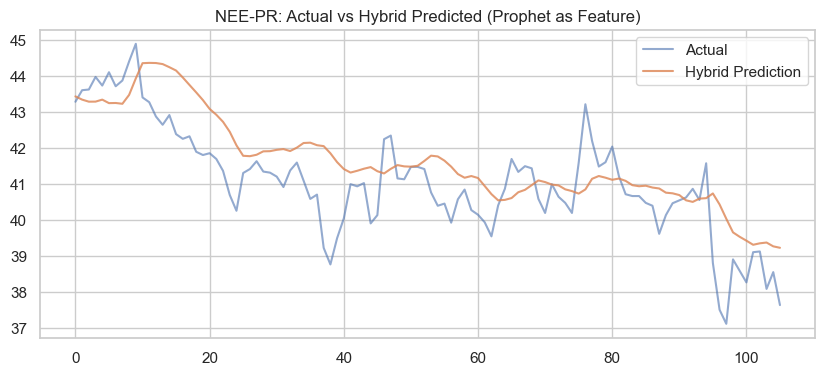

20:15:46 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for NEM


20:15:47 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 10s - 369ms/step - loss: 0.1304 - val_loss: 0.0300 - learning_rate: 0.0010
Epoch 2/100
26/26 - 4s - 151ms/step - loss: 0.0609 - val_loss: 0.0265 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 99ms/step - loss: 0.0521 - val_loss: 0.0263 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 99ms/step - loss: 0.0521 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 5/100
26/26 - 3s - 97ms/step - loss: 0.0469 - val_loss: 0.0383 - learning_rate: 0.0010
Epoch 6/100
26/26 - 3s - 124ms/step - loss: 0.0523 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 7/100
26/26 - 3s - 96ms/step - loss: 0.0455 - val_loss: 0.0216 - learning_rate: 5.0000e-04
Epoch 8/100
26/26 - 3s - 103ms/step - loss: 0.0424 - val_loss: 0.0243 - learning_rate: 5.0000e-04
Epoch 9/100
26/26 - 3s - 115ms/step - loss: 0.0436 - val_loss: 0.0224 - learning_rate: 5.0000e-04
Epoch 10/100
26/26 - 3s - 110ms/step - loss: 0.0438 - val_loss: 0.0226 - learning_rate: 2.5000e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
NEM → I

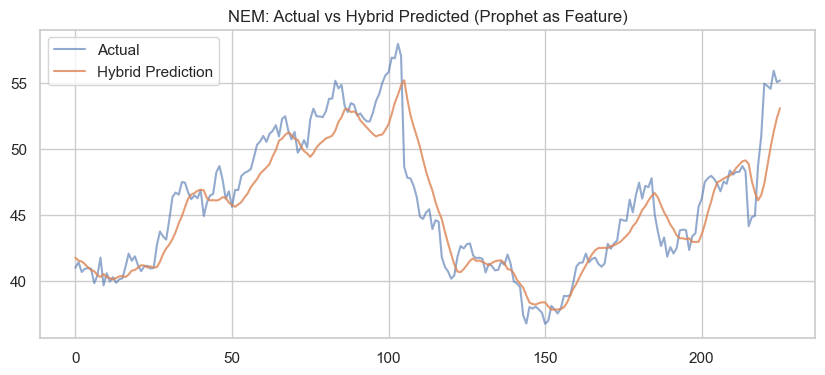

20:16:24 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for NISTF


20:16:25 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
22/22 - 10s - 436ms/step - loss: 0.1342 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 2/100
22/22 - 3s - 129ms/step - loss: 0.0709 - val_loss: 0.0567 - learning_rate: 0.0010
Epoch 3/100
22/22 - 3s - 127ms/step - loss: 0.0641 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 4/100
22/22 - 3s - 121ms/step - loss: 0.0573 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 5/100
22/22 - 3s - 132ms/step - loss: 0.0564 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 6/100
22/22 - 2s - 103ms/step - loss: 0.0550 - val_loss: 0.0280 - learning_rate: 0.0010
Epoch 7/100
22/22 - 2s - 96ms/step - loss: 0.0558 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 8/100
22/22 - 2s - 95ms/step - loss: 0.0616 - val_loss: 0.0393 - learning_rate: 0.0010
Epoch 9/100
22/22 - 2s - 98ms/step - loss: 0.0556 - val_loss: 0.0266 - learning_rate: 5.0000e-04
Epoch 10/100
22/22 - 2s - 105ms/step - loss: 0.0463 - val_loss: 0.0268 - learning_rate: 5.0000e-04
Epoch 11/100
22/22 - 2s - 86ms/step - loss: 0.0498 - 

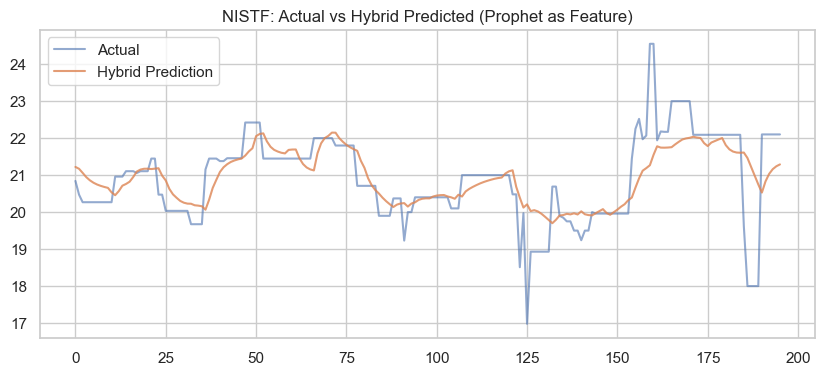

20:17:02 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for NRG


20:17:03 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
24/24 - 9s - 392ms/step - loss: 0.0430 - val_loss: 0.0264 - learning_rate: 0.0010
Epoch 2/100
24/24 - 3s - 140ms/step - loss: 0.0252 - val_loss: 0.0533 - learning_rate: 0.0010
Epoch 3/100
24/24 - 3s - 115ms/step - loss: 0.0239 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 4/100
24/24 - 3s - 131ms/step - loss: 0.0212 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 5/100
24/24 - 2s - 104ms/step - loss: 0.0195 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 6/100
24/24 - 3s - 141ms/step - loss: 0.0186 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 7/100
24/24 - 3s - 112ms/step - loss: 0.0180 - val_loss: 0.0207 - learning_rate: 5.0000e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step
NRG → Improved Hybrid Prophet+LSTM Test RMSE: 8.63


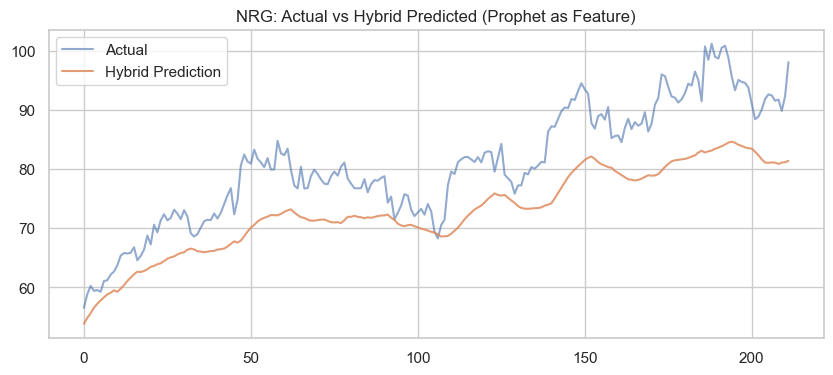

20:17:33 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for PCG


20:17:34 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 9s - 345ms/step - loss: 0.1143 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 99ms/step - loss: 0.0582 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 128ms/step - loss: 0.0470 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 133ms/step - loss: 0.0459 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 5/100
26/26 - 6s - 240ms/step - loss: 0.0423 - val_loss: 0.0168 - learning_rate: 5.0000e-04
Epoch 6/100
26/26 - 5s - 200ms/step - loss: 0.0410 - val_loss: 0.0310 - learning_rate: 5.0000e-04
Epoch 7/100
26/26 - 4s - 152ms/step - loss: 0.0423 - val_loss: 0.0165 - learning_rate: 5.0000e-04
Epoch 8/100
26/26 - 6s - 225ms/step - loss: 0.0387 - val_loss: 0.0164 - learning_rate: 5.0000e-04
Epoch 9/100
26/26 - 5s - 175ms/step - loss: 0.0405 - val_loss: 0.0181 - learning_rate: 5.0000e-04
Epoch 10/100
26/26 - 3s - 105ms/step - loss: 0.0401 - val_loss: 0.0192 - learning_rate: 5.0000e-04
Epoch 11/100
26/26 - 3s - 111ms/step

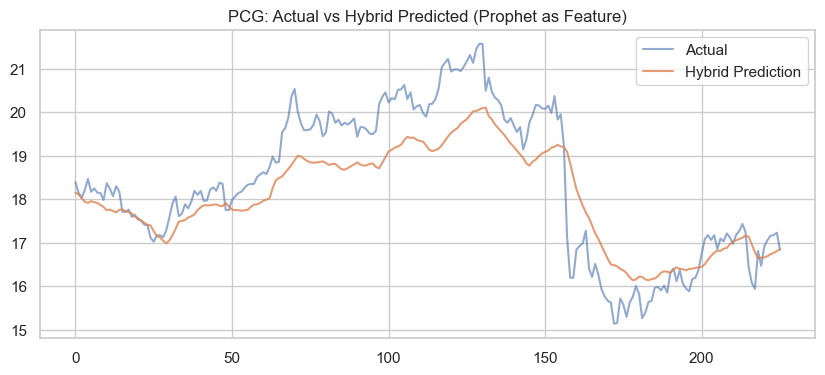

20:18:26 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for SHW


20:18:27 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 9s - 359ms/step - loss: 0.0827 - val_loss: 0.0486 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 103ms/step - loss: 0.0511 - val_loss: 0.0446 - learning_rate: 0.0010
Epoch 3/100
26/26 - 4s - 156ms/step - loss: 0.0423 - val_loss: 0.0315 - learning_rate: 0.0010
Epoch 4/100
26/26 - 4s - 159ms/step - loss: 0.0442 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 5/100
26/26 - 3s - 114ms/step - loss: 0.0440 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 6/100
26/26 - 3s - 126ms/step - loss: 0.0392 - val_loss: 0.0524 - learning_rate: 5.0000e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step
SHW → Improved Hybrid Prophet+LSTM Test RMSE: 13.90


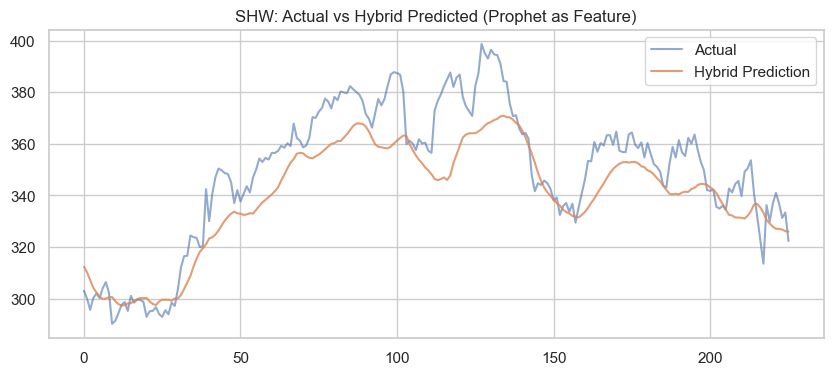

20:18:56 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for STLD


20:18:56 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 10s - 392ms/step - loss: 0.1441 - val_loss: 0.1355 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 108ms/step - loss: 0.0574 - val_loss: 0.0278 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 102ms/step - loss: 0.0463 - val_loss: 0.0628 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 100ms/step - loss: 0.0439 - val_loss: 0.0370 - learning_rate: 0.0010
Epoch 5/100
26/26 - 3s - 102ms/step - loss: 0.0428 - val_loss: 0.0269 - learning_rate: 5.0000e-04
Epoch 6/100
26/26 - 3s - 101ms/step - loss: 0.0389 - val_loss: 0.0578 - learning_rate: 5.0000e-04
Epoch 7/100
26/26 - 3s - 113ms/step - loss: 0.0404 - val_loss: 0.0768 - learning_rate: 5.0000e-04
Epoch 8/100
26/26 - 3s - 106ms/step - loss: 0.0407 - val_loss: 0.0190 - learning_rate: 2.5000e-04
Epoch 9/100
26/26 - 4s - 140ms/step - loss: 0.0411 - val_loss: 0.0414 - learning_rate: 2.5000e-04
Epoch 10/100
26/26 - 3s - 99ms/step - loss: 0.0371 - val_loss: 0.0364 - learning_rate: 2.5000e-04
Epoch 11/100
26/26 - 6s - 213ms/ste

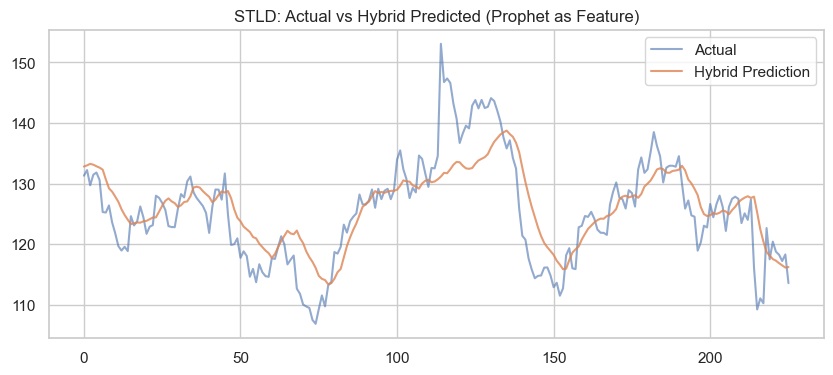

20:19:42 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for VLO


20:19:42 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 9s - 345ms/step - loss: 0.0908 - val_loss: 0.0709 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 101ms/step - loss: 0.0494 - val_loss: 0.0972 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 104ms/step - loss: 0.0508 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 127ms/step - loss: 0.0473 - val_loss: 0.0480 - learning_rate: 0.0010
Epoch 5/100
26/26 - 5s - 196ms/step - loss: 0.0433 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 6/100
26/26 - 5s - 181ms/step - loss: 0.0425 - val_loss: 0.0509 - learning_rate: 5.0000e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step
VLO → Improved Hybrid Prophet+LSTM Test RMSE: 6.81


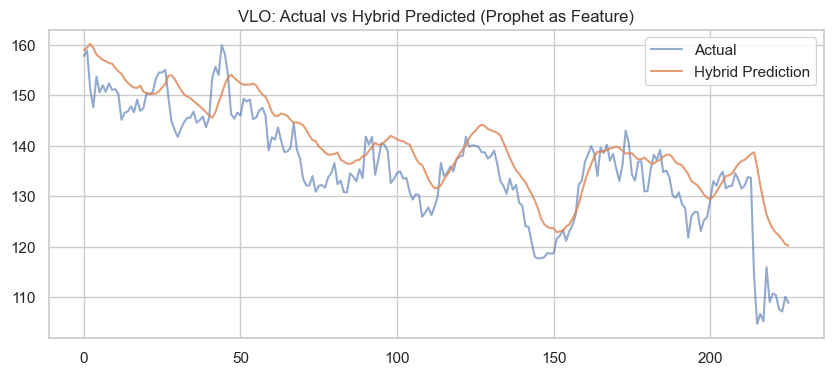

20:20:13 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for XEL


20:20:13 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 15s - 564ms/step - loss: 0.1446 - val_loss: 0.0511 - learning_rate: 0.0010
Epoch 2/100
26/26 - 4s - 162ms/step - loss: 0.0699 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 114ms/step - loss: 0.0635 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 4/100
26/26 - 3s - 102ms/step - loss: 0.0664 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 5/100
26/26 - 5s - 196ms/step - loss: 0.0651 - val_loss: 0.0435 - learning_rate: 5.0000e-04
Epoch 6/100
26/26 - 4s - 145ms/step - loss: 0.0566 - val_loss: 0.0432 - learning_rate: 5.0000e-04
Epoch 7/100
26/26 - 3s - 102ms/step - loss: 0.0578 - val_loss: 0.0463 - learning_rate: 5.0000e-04
Epoch 8/100
26/26 - 3s - 119ms/step - loss: 0.0605 - val_loss: 0.0439 - learning_rate: 5.0000e-04
Epoch 9/100
26/26 - 3s - 130ms/step - loss: 0.0556 - val_loss: 0.0396 - learning_rate: 2.5000e-04
Epoch 10/100
26/26 - 3s - 127ms/step - loss: 0.0543 - val_loss: 0.0388 - learning_rate: 2.5000e-04
Epoch 11/100
26/26 - 3s - 99ms/ste

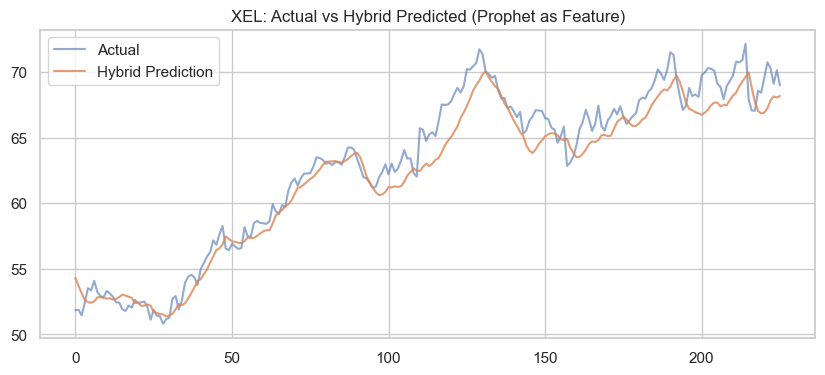

20:21:09 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet+LSTM for XOM


20:21:10 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 9s - 346ms/step - loss: 0.1334 - val_loss: 0.1190 - learning_rate: 0.0010
Epoch 2/100
26/26 - 3s - 118ms/step - loss: 0.0623 - val_loss: 0.0348 - learning_rate: 0.0010
Epoch 3/100
26/26 - 3s - 112ms/step - loss: 0.0551 - val_loss: 0.0299 - learning_rate: 0.0010
Epoch 4/100
26/26 - 5s - 193ms/step - loss: 0.0500 - val_loss: 0.0199 - learning_rate: 0.0010
Epoch 5/100
26/26 - 3s - 115ms/step - loss: 0.0556 - val_loss: 0.0936 - learning_rate: 0.0010
Epoch 6/100
26/26 - 3s - 125ms/step - loss: 0.0510 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 7/100
26/26 - 3s - 98ms/step - loss: 0.0475 - val_loss: 0.0187 - learning_rate: 5.0000e-04
Epoch 8/100
26/26 - 3s - 98ms/step - loss: 0.0459 - val_loss: 0.0416 - learning_rate: 5.0000e-04
Epoch 9/100
26/26 - 3s - 102ms/step - loss: 0.0459 - val_loss: 0.0181 - learning_rate: 5.0000e-04
Epoch 10/100
26/26 - 3s - 115ms/step - loss: 0.0438 - val_loss: 0.0231 - learning_rate: 5.0000e-04
Epoch 11/100
26/26 - 3s - 120ms/step - loss: 

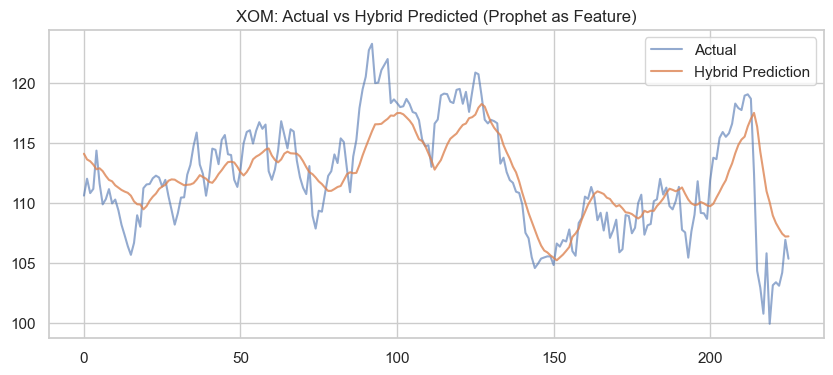


🏆 Prophet+LSTM Leaderboard:

        Estimated_RMSE
PCG           0.130796
ATO           0.133522
HES           0.137517
EIX           0.141940
NRG           0.143796
FE            0.144557
NEM           0.150231
CVX           0.161385
AWK           0.163026
AEP           0.163922
XOM           0.165506
APD           0.188619
NISTF         0.197570
XEL           0.198186
STLD          0.224507
VLO           0.225524
SHW           0.228871
DUK-PA        0.243073
NEE-PR        0.258279


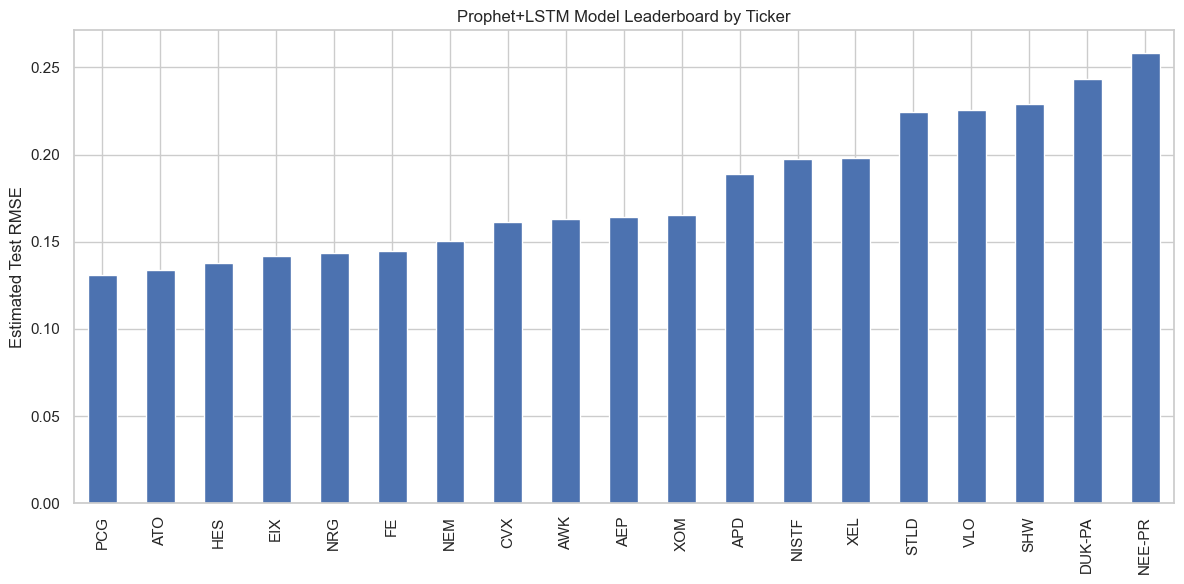

In [191]:
# --- 1) Batch Runner Function ---
def run_prophet_lstm_batch(df, ticker_list, seq_length=90, test_split=0.2):
    rmse_results = {}
    models = {}
    prophets = {}

    for ticker in ticker_list:
        print("="*50)
        print(f"Training Prophet+LSTM for {ticker}")
        print("="*50)
        try:
            model, prophet = run_prophet_as_feature_lstm(df, ticker, seq_length=seq_length, test_split=test_split)
            if model is not None:
                models[ticker] = model
                prophets[ticker] = prophet
        except Exception as e:
            print(f"[Warning] Skipped {ticker} due to error: {e}")
            continue

    return models, prophets

# --- 2) Leaderboard Creation ---
def create_leaderboard(models):
    leaderboard = {}

    for ticker, model in models.items():
        try:
            val_losses = model.history.history['val_loss']
            final_val_loss = val_losses[-1]  # final validation loss
            rmse_estimate = np.sqrt(final_val_loss)
            leaderboard[ticker] = rmse_estimate
        except Exception as e:
            print(f"Error evaluating {ticker}: {e}")

    leaderboard_df = pd.DataFrame.from_dict(leaderboard, orient='index', columns=['Estimated_RMSE'])
    leaderboard_df = leaderboard_df.sort_values('Estimated_RMSE')

    return leaderboard_df

# --- 3) (Optional) Leaderboard Plotting ---
def plot_leaderboard(leaderboard_df):
    plt.figure(figsize=(12,6))
    leaderboard_df['Estimated_RMSE'].plot(kind='bar')
    plt.ylabel("Estimated Test RMSE")
    plt.title("Prophet+LSTM Model Leaderboard by Ticker")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 4) Run Everything ---

# Step 1: Add indicators
df = add_technical_indicators(market_data)

# Step 2: Get list of all tickers
tickers = df['Ticker'].unique()
print(f"Tickers found: {tickers}")

# Step 3: Train on all tickers
models, prophets = run_prophet_lstm_batch(df, tickers)

# Step 4: Create Leaderboard
leaderboard_df = create_leaderboard(models)

# Step 5: View and Plot
print("\n🏆 Prophet+LSTM Leaderboard:\n")
print(leaderboard_df)
plot_leaderboard(leaderboard_df)


20:29:39 - cmdstanpy - INFO - Chain [1] start processing


Tickers found: ['AEP' 'APD' 'ATO' 'AWK' 'CVX' 'DUK-PA' 'EIX' 'FE' 'HES' 'NEE-PR' 'NEM'
 'NISTF' 'NRG' 'PCG' 'SHW' 'STLD' 'VLO' 'XEL' 'XOM']
Training Prophet+LSTM for AEP


20:29:40 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step


20:30:29 - cmdstanpy - INFO - Chain [1] start processing


[Done] AEP → True Test RMSE: 2.36
Training Prophet+LSTM for APD


20:30:30 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


20:31:01 - cmdstanpy - INFO - Chain [1] start processing


[Done] APD → True Test RMSE: 12.13
Training Prophet+LSTM for ATO


20:31:02 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step


20:31:48 - cmdstanpy - INFO - Chain [1] start processing


[Done] ATO → True Test RMSE: 7.38
Training Prophet+LSTM for AWK


20:31:49 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


20:32:49 - cmdstanpy - INFO - Chain [1] start processing


[Done] AWK → True Test RMSE: 3.45
Training Prophet+LSTM for CVX


20:32:50 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step


20:33:16 - cmdstanpy - INFO - Chain [1] start processing


[Done] CVX → True Test RMSE: 4.77
Training Prophet+LSTM for DUK-PA


20:33:18 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 428ms/step
[Done] DUK-PA → True Test RMSE: 0.24
Training Prophet+LSTM for EIX


20:34:13 - cmdstanpy - INFO - Chain [1] start processing
20:34:14 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step


20:34:39 - cmdstanpy - INFO - Chain [1] start processing


[Done] EIX → True Test RMSE: 3.90
Training Prophet+LSTM for FE


20:34:40 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step


20:35:10 - cmdstanpy - INFO - Chain [1] start processing


[Done] FE → True Test RMSE: 1.49
Training Prophet+LSTM for HES


20:35:11 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step


20:36:00 - cmdstanpy - INFO - Chain [1] start processing


[Done] HES → True Test RMSE: 4.88
Training Prophet+LSTM for NEE-PR


20:36:00 - cmdstanpy - INFO - Chain [1] done processing


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step


20:36:18 - cmdstanpy - INFO - Chain [1] start processing


[Done] NEE-PR → True Test RMSE: 1.01
Training Prophet+LSTM for NEM


20:36:19 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


20:37:21 - cmdstanpy - INFO - Chain [1] start processing


[Done] NEM → True Test RMSE: 1.86
Training Prophet+LSTM for NISTF


20:37:22 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


20:38:06 - cmdstanpy - INFO - Chain [1] start processing


[Done] NISTF → True Test RMSE: 0.81
Training Prophet+LSTM for NRG


20:38:07 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


20:38:27 - cmdstanpy - INFO - Chain [1] start processing


[Done] NRG → True Test RMSE: 12.91
Training Prophet+LSTM for PCG


20:38:28 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


20:38:53 - cmdstanpy - INFO - Chain [1] start processing


[Done] PCG → True Test RMSE: 0.85
Training Prophet+LSTM for SHW


20:38:54 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step


20:39:27 - cmdstanpy - INFO - Chain [1] start processing


[Done] SHW → True Test RMSE: 9.97
Training Prophet+LSTM for STLD


20:39:28 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step


20:40:20 - cmdstanpy - INFO - Chain [1] start processing


[Done] STLD → True Test RMSE: 5.10
Training Prophet+LSTM for VLO


20:40:20 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


20:40:44 - cmdstanpy - INFO - Chain [1] start processing


[Done] VLO → True Test RMSE: 5.09
Training Prophet+LSTM for XEL


20:40:44 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


20:41:03 - cmdstanpy - INFO - Chain [1] start processing


[Done] XEL → True Test RMSE: 2.79
Training Prophet+LSTM for XOM


20:41:04 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
[Done] XOM → True Test RMSE: 4.19

🏆 True Prophet+LSTM Test RMSE Leaderboard:

        True_Test_RMSE
DUK-PA        0.242907
NISTF         0.805591
PCG           0.845170
NEE-PR        1.014370
FE            1.485202
NEM           1.859203
AEP           2.360424
XEL           2.790967
AWK           3.449447
EIX           3.903025
XOM           4.190905
CVX           4.770617
HES           4.882906
VLO           5.091072
STLD          5.101425
ATO           7.382938
SHW           9.970101
APD          12.125751
NRG          12.910281


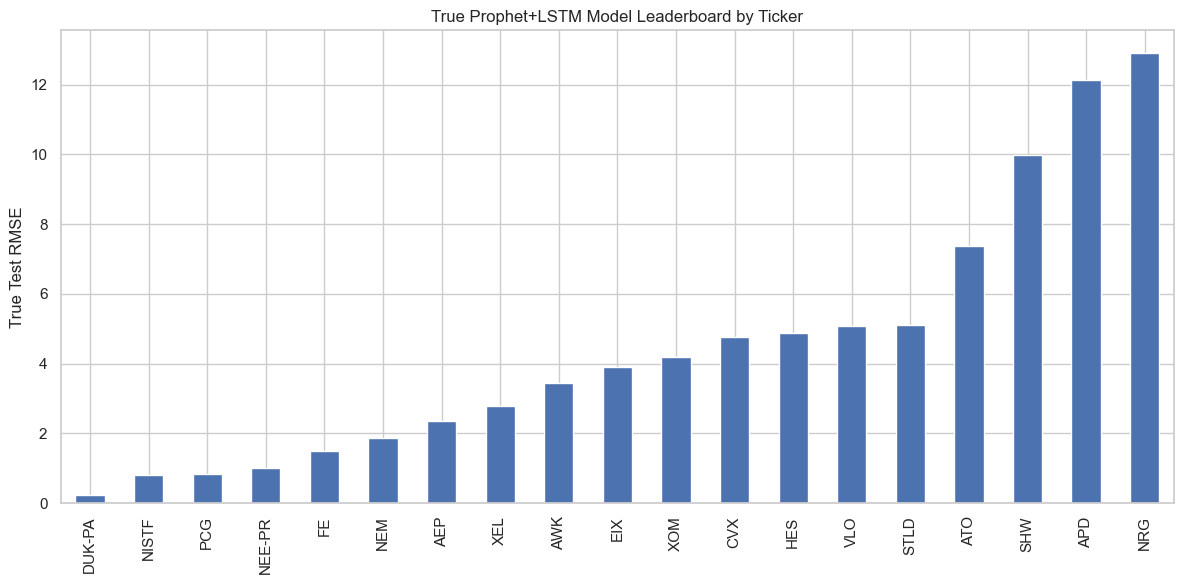

In [193]:
# --- 1) True Batch Runner ---
def run_prophet_lstm_batch_true_rmse(df, ticker_list, seq_length=90, test_split=0.2):
    test_rmse_results = {}
    models = {}
    prophets = {}

    for ticker in ticker_list:
        print("="*50)
        print(f"Training Prophet+LSTM for {ticker}")
        print("="*50)
        try:
            sub = df[df['Ticker'] == ticker].sort_values('Date')
            sub = sub.dropna()

            if len(sub) < seq_length + 30:
                print(f"[Warning] Not enough data for {ticker}. Skipping.")
                continue

            # --- Prophet Model ---
            prophet_df = sub[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
            prophet = Prophet(daily_seasonality=True)
            prophet.fit(prophet_df)

            future = prophet.make_future_dataframe(periods=0)
            forecast = prophet.predict(future)
            prophet_trend = forecast['yhat'].values

            sub['Prophet_Trend'] = prophet_trend

            features = ["Close", "Volume", "SMA_20", "EMA_20", "Volatility_14", "RSI_14", "Prophet_Trend"]
            features = [feat for feat in features if feat in sub.columns]

            X_features = sub[features].values
            scaler_X = MinMaxScaler()
            X_scaled = scaler_X.fit_transform(X_features)

            scaler_y = MinMaxScaler()
            y_target = sub['Close'].values.reshape(-1,1)
            y_scaled = scaler_y.fit_transform(y_target)

            # Build sequences
            X, y = [], []
            for i in range(len(X_scaled) - seq_length):
                X.append(X_scaled[i:i+seq_length])
                y.append(y_scaled[i+seq_length])
            X = np.array(X)
            y = np.array(y)

            if len(X) == 0:
                print(f"[Warning] Not enough sequence data for {ticker}. Skipping.")
                continue

            split_idx = int((1-test_split) * len(X))
            X_train, X_test = X[:split_idx], X[split_idx:]
            y_train, y_test = y[:split_idx], y[split_idx:]

            n_feats = X.shape[2]
            model = Sequential([
                Input(shape=(seq_length, n_feats)),
                Bidirectional(LSTM(64, return_sequences=True)),
                Dropout(0.3),
                LSTM(64),
                Dropout(0.3),
                Dense(1)
            ])
            model.compile(optimizer='adam', loss='mean_absolute_error')

            es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

            model.fit(
                X_train, y_train,
                validation_split=0.1,
                epochs=100,
                batch_size=32,
                callbacks=[es, reduce_lr],
                verbose=0  # hide per-epoch training logs
            )

            # --- Predict on true unseen test set ---
            y_pred_scaled = model.predict(X_test, batch_size=32)
            y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
            y_true = scaler_y.inverse_transform(y_test).flatten()

            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            test_rmse_results[ticker] = rmse

            models[ticker] = model
            prophets[ticker] = prophet

            print(f"[Done] {ticker} → True Test RMSE: {rmse:.2f}")

        except Exception as e:
            print(f"[Error] Skipped {ticker} due to error: {e}")
            continue

    return models, prophets, test_rmse_results

# --- 2) Leaderboard Creation ---
def create_true_leaderboard(test_rmse_results):
    leaderboard_df = pd.DataFrame.from_dict(test_rmse_results, orient='index', columns=['True_Test_RMSE'])
    leaderboard_df = leaderboard_df.sort_values('True_Test_RMSE')
    return leaderboard_df

# --- 3) Plotting Leaderboard ---
def plot_true_leaderboard(leaderboard_df):
    plt.figure(figsize=(12,6))
    leaderboard_df['True_Test_RMSE'].plot(kind='bar')
    plt.ylabel("True Test RMSE")
    plt.title("True Prophet+LSTM Model Leaderboard by Ticker")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 4) Run Everything ---

# Step 1: Add indicators
df = add_technical_indicators(market_data)

# Step 2: Get list of all tickers
tickers = df['Ticker'].unique()
print(f"Tickers found: {tickers}")

# Step 3: Train and collect True Test RMSE
models, prophets, test_rmse_results = run_prophet_lstm_batch_true_rmse(df, tickers)

# Step 4: Build Leaderboard
leaderboard_df = create_true_leaderboard(test_rmse_results)

# Step 5: View and Plot
print("\n🏆 True Prophet+LSTM Test RMSE Leaderboard:\n")
print(leaderboard_df)
plot_true_leaderboard(leaderboard_df)


Auto-tuning sequence length for AEP
Trying sequence length 60...


20:43:57 - cmdstanpy - INFO - Chain [1] start processing
20:43:57 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step


20:44:31 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 2.28
Trying sequence length 90...


20:44:31 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step


20:45:05 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 4.57
Trying sequence length 120...


20:45:05 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step


20:46:00 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 2.14
✅ Best for AEP: seq=120, RMSE=2.14
Auto-tuning sequence length for APD
Trying sequence length 60...


20:46:01 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step


20:46:39 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 9.23
Trying sequence length 90...


20:46:40 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step


20:47:20 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 9.92
Trying sequence length 120...


20:47:21 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step


20:48:01 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 11.29
✅ Best for APD: seq=60, RMSE=9.23
Auto-tuning sequence length for ATO
Trying sequence length 60...


20:48:02 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


20:48:19 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 8.04
Trying sequence length 90...


20:48:20 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step


20:49:04 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 6.06
Trying sequence length 120...


20:49:05 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step


20:50:00 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 6.56
✅ Best for ATO: seq=90, RMSE=6.06
Auto-tuning sequence length for AWK
Trying sequence length 60...


20:50:01 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step


20:50:32 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 3.80
Trying sequence length 90...


20:50:32 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step


20:51:23 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 3.17
Trying sequence length 120...


20:51:24 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step


20:53:56 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 2.72
✅ Best for AWK: seq=120, RMSE=2.72
Auto-tuning sequence length for CVX
Trying sequence length 60...


20:53:57 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step


20:54:36 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 4.57
Trying sequence length 90...


20:54:36 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step


20:55:07 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 4.67
Trying sequence length 120...


20:55:07 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step


20:56:00 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 5.28
✅ Best for CVX: seq=60, RMSE=4.57
Auto-tuning sequence length for DUK-PA
Trying sequence length 60...


20:56:01 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step


20:56:26 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 0.27
Trying sequence length 90...


20:56:28 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


20:57:07 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 0.22
Trying sequence length 120...


20:57:08 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms/step
Sequence 120 → Test RMSE: 0.24
✅ Best for DUK-PA: seq=90, RMSE=0.22
Auto-tuning sequence length for EIX
Trying sequence length 60...


20:57:52 - cmdstanpy - INFO - Chain [1] start processing
20:57:53 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


20:58:27 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 3.03
Trying sequence length 90...


20:58:28 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step


20:58:55 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 4.08
Trying sequence length 120...


20:58:56 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step


20:59:23 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 4.60
✅ Best for EIX: seq=60, RMSE=3.03
Auto-tuning sequence length for FE
Trying sequence length 60...


20:59:24 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


21:00:00 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 1.12
Trying sequence length 90...


21:00:01 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


21:00:49 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 0.90
Trying sequence length 120...


21:00:50 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step


21:01:17 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 1.65
✅ Best for FE: seq=90, RMSE=0.90
Auto-tuning sequence length for HES
Trying sequence length 60...


21:01:18 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


21:01:41 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 6.01
Trying sequence length 90...


21:01:41 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step


21:02:15 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 5.38
Trying sequence length 120...


21:02:15 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step


21:03:14 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 5.20
✅ Best for HES: seq=120, RMSE=5.20
Auto-tuning sequence length for NEE-PR
Trying sequence length 60...


21:03:14 - cmdstanpy - INFO - Chain [1] done processing


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


21:03:36 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 1.10
Trying sequence length 90...


21:03:36 - cmdstanpy - INFO - Chain [1] done processing


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step


21:03:58 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 1.19
Trying sequence length 120...


21:03:58 - cmdstanpy - INFO - Chain [1] done processing


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step


21:04:18 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 1.28
✅ Best for NEE-PR: seq=60, RMSE=1.10
Auto-tuning sequence length for NEM
Trying sequence length 60...


21:04:19 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


21:04:36 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 3.92
Trying sequence length 90...


21:04:36 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


21:05:07 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 2.06
Trying sequence length 120...


21:05:08 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step


21:06:13 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 1.96
✅ Best for NEM: seq=120, RMSE=1.96
Auto-tuning sequence length for NISTF
Trying sequence length 60...


21:06:13 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step


21:06:51 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 0.86
Trying sequence length 90...


21:06:51 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step


21:07:32 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 0.82
Trying sequence length 120...


21:07:32 - cmdstanpy - INFO - Chain [1] done processing


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step


21:08:22 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 0.87
✅ Best for NISTF: seq=90, RMSE=0.82
Auto-tuning sequence length for NRG
Trying sequence length 60...


21:08:23 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


21:08:49 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 10.26
Trying sequence length 90...


21:08:49 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step


21:09:28 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 8.87
Trying sequence length 120...


21:09:29 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step


21:10:30 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 11.40
✅ Best for NRG: seq=90, RMSE=8.87
Auto-tuning sequence length for PCG
Trying sequence length 60...


21:10:31 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step


21:10:51 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 0.95
Trying sequence length 90...


21:10:52 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step


21:11:42 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 0.85
Trying sequence length 120...


21:11:43 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step


21:12:11 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 1.02
✅ Best for PCG: seq=90, RMSE=0.85
Auto-tuning sequence length for SHW
Trying sequence length 60...


21:12:12 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step


21:12:39 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 9.84
Trying sequence length 90...


21:12:40 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


21:13:18 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 9.78
Trying sequence length 120...


21:13:19 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step
Sequence 120 → Test RMSE: 8.72
✅ Best for SHW: seq=120, RMSE=8.72
Auto-tuning sequence length for STLD
Trying sequence length 60...


21:14:16 - cmdstanpy - INFO - Chain [1] start processing
21:14:17 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step


21:14:36 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 6.89
Trying sequence length 90...


21:14:37 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step


21:15:17 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 6.72
Trying sequence length 120...


21:15:18 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step


21:15:58 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 6.96
✅ Best for STLD: seq=90, RMSE=6.72
Auto-tuning sequence length for VLO
Trying sequence length 60...


21:15:58 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step


21:16:24 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 5.64
Trying sequence length 90...


21:16:24 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step


21:17:19 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 6.03
Trying sequence length 120...


21:17:19 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step


21:17:57 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 5.39
✅ Best for VLO: seq=120, RMSE=5.39
Auto-tuning sequence length for XEL
Trying sequence length 60...


21:17:57 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


21:18:30 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 1.14
Trying sequence length 90...


21:18:31 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step


21:19:08 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 1.74
Trying sequence length 120...


21:19:09 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step


21:20:19 - cmdstanpy - INFO - Chain [1] start processing


Sequence 120 → Test RMSE: 1.26
✅ Best for XEL: seq=60, RMSE=1.14
Auto-tuning sequence length for XOM
Trying sequence length 60...


21:20:20 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step


21:20:47 - cmdstanpy - INFO - Chain [1] start processing


Sequence 60 → Test RMSE: 3.67
Trying sequence length 90...


21:20:48 - cmdstanpy - INFO - Chain [1] done processing


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step


21:21:25 - cmdstanpy - INFO - Chain [1] start processing


Sequence 90 → Test RMSE: 3.90
Trying sequence length 120...


21:21:27 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step
Sequence 120 → Test RMSE: 3.03
✅ Best for XOM: seq=120, RMSE=3.03

🏆 Final Optimized Prophet+LSTM Leaderboard:

        Best_Seq_Length  True_Test_RMSE
DUK-PA               90        0.221863
NISTF                90        0.817519
PCG                  90        0.852908
FE                   90        0.897160
NEE-PR               60        1.102042
XEL                  60        1.139273
NEM                 120        1.960200
AEP                 120        2.143470
AWK                 120        2.722493
XOM                 120        3.027781
EIX                  60        3.033577
CVX                  60        4.572717
HES                 120        5.197620
VLO                 120        5.386929
ATO                  90        6.063621
STLD                 90        6.721674
SHW                 120        8.721814
NRG                  90        8.865311
APD                  60        9.226663


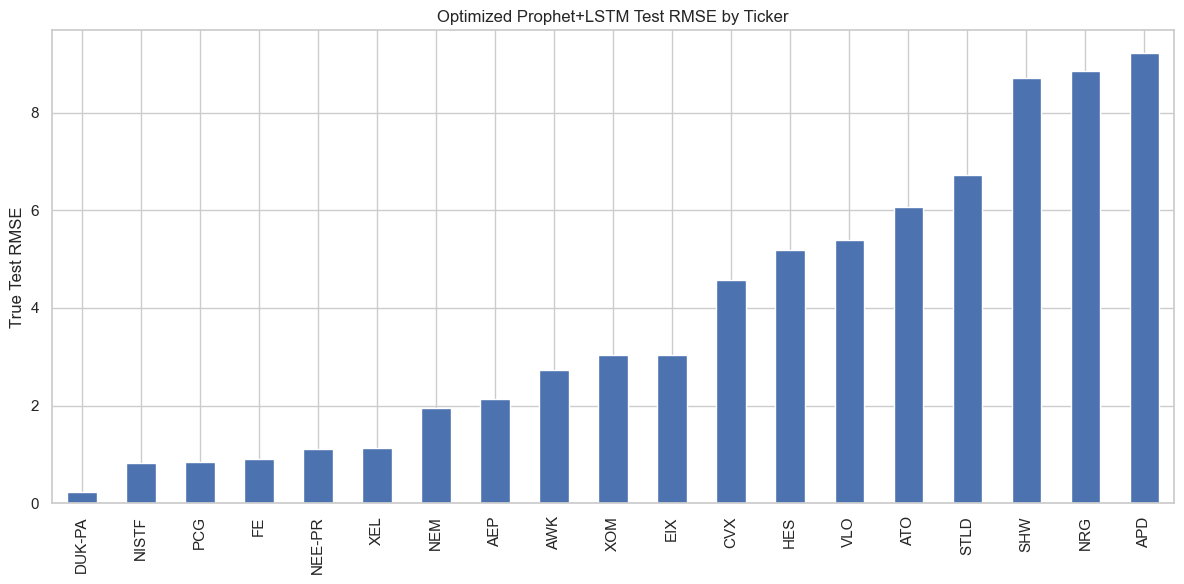

In [195]:
# --- 1) Function to Train + Evaluate at Specific Sequence Length ---
def train_and_evaluate_one_ticker(df, ticker, seq_length, test_split=0.2):
    sub = df[df['Ticker'] == ticker].sort_values('Date')
    sub = sub.dropna()

    if len(sub) < seq_length + 30:
        print(f"[Warning] Not enough data for {ticker} with sequence length {seq_length}. Skipping.")
        return None, None, None

    # Prophet modeling
    prophet_df = sub[['Date', 'Close']].rename(columns={'Date':'ds', 'Close':'y'})
    prophet = Prophet(daily_seasonality=True)
    prophet.fit(prophet_df)

    future = prophet.make_future_dataframe(periods=0)
    forecast = prophet.predict(future)
    prophet_trend = forecast['yhat'].values
    sub['Prophet_Trend'] = prophet_trend

    # Features
    features = ["Close", "Volume", "SMA_20", "EMA_20", "Volatility_14", "RSI_14", "Prophet_Trend"]
    features = [feat for feat in features if feat in sub.columns]

    X_features = sub[features].values
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_features)

    scaler_y = MinMaxScaler()
    y_target = sub['Close'].values.reshape(-1,1)
    y_scaled = scaler_y.fit_transform(y_target)

    # Build sequences
    X, y = [], []
    for i in range(len(X_scaled) - seq_length):
        X.append(X_scaled[i:i+seq_length])
        y.append(y_scaled[i+seq_length])
    X = np.array(X)
    y = np.array(y)

    if len(X) == 0:
        print(f"[Warning] No sequences for {ticker} with seq_length {seq_length}")
        return None, None, None

    split_idx = int((1-test_split)*len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    n_feats = X.shape[2]
    model = Sequential([
        Input(shape=(seq_length, n_feats)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')

    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=32,
        callbacks=[es, reduce_lr],
        verbose=0
    )

    # Predict on test set
    y_pred_scaled = model.predict(X_test, batch_size=32)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
    y_true = scaler_y.inverse_transform(y_test).flatten()

    test_rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return model, prophet, test_rmse

# --- 2) Auto Tune Sequence Length for Each Ticker ---
def auto_tune_sequence_length(df, ticker_list, seq_lengths=[60, 90, 120], test_split=0.2):
    best_models = {}
    best_prophets = {}
    best_rmses = {}
    best_seq_lengths = {}

    for ticker in ticker_list:
        print("="*60)
        print(f"Auto-tuning sequence length for {ticker}")
        print("="*60)

        best_rmse = np.inf
        best_model = None
        best_prophet = None
        best_seq = None

        for seq_length in seq_lengths:
            print(f"Trying sequence length {seq_length}...")
            model, prophet, rmse = train_and_evaluate_one_ticker(df, ticker, seq_length, test_split)

            if model is None:
                continue  # not enough data for this sequence length

            print(f"Sequence {seq_length} → Test RMSE: {rmse:.2f}")

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_prophet = prophet
                best_seq = seq_length

        if best_model is not None:
            best_models[ticker] = best_model
            best_prophets[ticker] = best_prophet
            best_rmses[ticker] = best_rmse
            best_seq_lengths[ticker] = best_seq
            print(f"✅ Best for {ticker}: seq={best_seq}, RMSE={best_rmse:.2f}")

    return best_models, best_prophets, best_rmses, best_seq_lengths

# --- 3) (Optional) Leaderboard Display ---
def create_final_leaderboard(best_rmses, best_seq_lengths):
    leaderboard_df = pd.DataFrame({
        'Best_Seq_Length': pd.Series(best_seq_lengths),
        'True_Test_RMSE': pd.Series(best_rmses)
    })
    leaderboard_df = leaderboard_df.sort_values('True_Test_RMSE')
    return leaderboard_df

# --- 4) Run it all ---

# Step 1: Add indicators
df = add_technical_indicators(market_data)

# Step 2: Get tickers
tickers = df['Ticker'].unique()

# Step 3: Run auto-tuning
best_models, best_prophets, best_rmses, best_seq_lengths = auto_tune_sequence_length(df, tickers)

# Step 4: Create and display final leaderboard
final_leaderboard = create_final_leaderboard(best_rmses, best_seq_lengths)

print("\n🏆 Final Optimized Prophet+LSTM Leaderboard:\n")
print(final_leaderboard)

# Step 5: (Optional) Plot
plt.figure(figsize=(12,6))
final_leaderboard['True_Test_RMSE'].plot(kind='bar')
plt.title("Optimized Prophet+LSTM Test RMSE by Ticker")
plt.ylabel("True Test RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()


18:39:48 - cmdstanpy - INFO - Chain [1] start processing
18:39:49 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
24/24 - 23s - 941ms/step - loss: 0.0572 - val_loss: 0.0988 - learning_rate: 0.0010
Epoch 2/100
24/24 - 3s - 138ms/step - loss: 0.0248 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 3/100
24/24 - 3s - 134ms/step - loss: 0.0232 - val_loss: 0.0396 - learning_rate: 0.0010
Epoch 4/100
24/24 - 4s - 162ms/step - loss: 0.0216 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 5/100
24/24 - 3s - 105ms/step - loss: 0.0214 - val_loss: 0.0222 - learning_rate: 5.0000e-04
Epoch 6/100
24/24 - 2s - 101ms/step - loss: 0.0181 - val_loss: 0.0297 - learning_rate: 5.0000e-04
Epoch 7/100
24/24 - 3s - 107ms/step - loss: 0.0175 - val_loss: 0.0307 - learning_rate: 5.0000e-04
Epoch 8/100
24/24 - 2s - 100ms/step - loss: 0.0172 - val_loss: 0.0166 - learning_rate: 2.5000e-04
Epoch 9/100
24/24 - 3s - 105ms/step - loss: 0.0169 - val_loss: 0.0172 - learning_rate: 2.5000e-04
Epoch 10/100
24/24 - 2s - 102ms/step - loss: 0.0169 - val_loss: 0.0254 - learning_rate: 2.5000e-04
Epoch 11/100
24/24 - 3s - 133ms/st

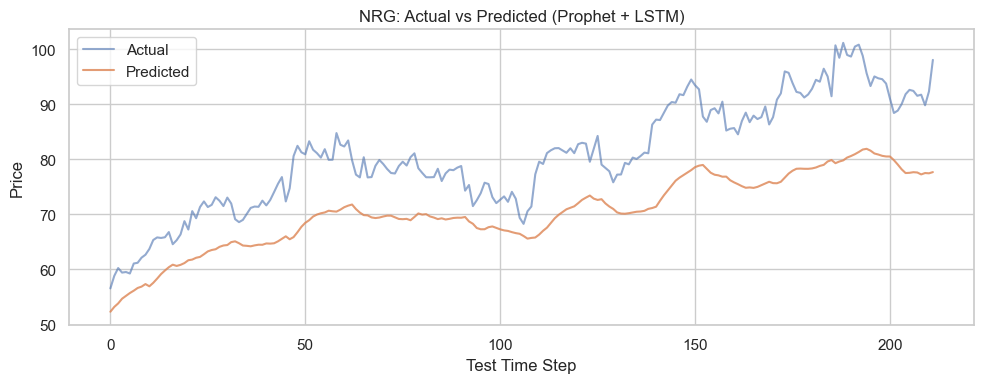

In [197]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from prophet import Prophet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# --- Feature Engineering Function ---
def add_technical_indicators(df):
    df = df.copy()
    df = df.sort_values(["Ticker", "Date"])
    window = 14

    df["SMA_20"] = df.groupby('Ticker')["Close"].transform(lambda x: x.rolling(20).mean())
    df["EMA_20"] = df.groupby('Ticker')["Close"].transform(lambda x: x.ewm(span=20, adjust=False).mean())
    df["Volatility_14"] = df.groupby('Ticker')["Close"].transform(lambda x: x.pct_change().rolling(window).std())

    def compute_rsi(series, window=14):
        delta = series.diff()
        up = delta.clip(lower=0)
        down = -delta.clip(upper=0)
        ma_up = up.rolling(window).mean()
        ma_down = down.rolling(window).mean()
        rsi = 100 - (100 / (1 + ma_up / ma_down))
        return rsi

    df["RSI_14"] = df.groupby('Ticker')["Close"].transform(lambda x: compute_rsi(x, window))
    df = df.dropna(subset=["SMA_20", "EMA_20", "Volatility_14", "RSI_14"])

    return df

# --- Single Stock Prophet+LSTM Training Function ---
def run_prophet_lstm_for_stock(df, ticker, seq_length=90, test_split=0.2): ##can change seq_length according to information above
    sub = df[df['Ticker'] == ticker].sort_values('Date')
    sub = sub.dropna()

    if len(sub) < seq_length + 30:
        print(f"[Warning] Not enough data for {ticker}. Exiting.")
        return None

    # --- Prophet ---
    prophet_df = sub[['Date', 'Close']].rename(columns={'Date':'ds', 'Close':'y'})
    prophet = Prophet(daily_seasonality=True)
    prophet.fit(prophet_df)

    future = prophet.make_future_dataframe(periods=0)
    forecast = prophet.predict(future)
    prophet_trend = forecast['yhat'].values

    # Add Prophet trend as a feature
    sub['Prophet_Trend'] = prophet_trend

    features = ["Close", "Volume", "SMA_20", "EMA_20", "Volatility_14", "RSI_14", "Prophet_Trend"]
    features = [feat for feat in features if feat in sub.columns]

    X_features = sub[features].values
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_features)

    scaler_y = MinMaxScaler()
    y_target = sub['Close'].values.reshape(-1,1)
    y_scaled = scaler_y.fit_transform(y_target)

    # --- Build sequences ---
    X, y = [], []
    for i in range(len(X_scaled) - seq_length):
        X.append(X_scaled[i:i+seq_length])
        y.append(y_scaled[i+seq_length])
    X = np.array(X)
    y = np.array(y)

    if len(X) == 0:
        print(f"[Warning] No sequences created for {ticker}.")
        return None

    split_idx = int((1-test_split)*len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # --- Build LSTM ---
    n_feats = X.shape[2]
    model = Sequential([
        Input(shape=(seq_length, n_feats)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')

    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=32,
        callbacks=[es, reduce_lr],
        verbose=2
    )

    # --- Predict on test set ---
    y_pred_scaled = model.predict(X_test, batch_size=32)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
    y_true = scaler_y.inverse_transform(y_test).flatten()

    # --- Evaluate ---
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n✅ {ticker}: True Test RMSE: {rmse:.2f}")

    # --- Plot ---
    plt.figure(figsize=(10,4))
    plt.plot(y_true, label='Actual', alpha=0.6)
    plt.plot(y_pred, label='Predicted', alpha=0.8)
    plt.title(f"{ticker}: Actual vs Predicted (Prophet + LSTM)")
    plt.xlabel("Test Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, prophet

# --- Example Run ---

# Suppose you already have a DataFrame called market_data
# market_data = pd.read_csv("your_data.csv")

# Step 1: Add indicators
df = add_technical_indicators(market_data)

# Step 2: Train and predict for one stock
model, prophet = run_prophet_lstm_for_stock(df, ticker='NRG', seq_length=90)


21:40:35 - cmdstanpy - INFO - Chain [1] start processing
21:40:36 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
26/26 - 36s - 1s/step - loss: 0.1341 - val_loss: 0.0474 - learning_rate: 0.0010
Epoch 2/100
26/26 - 4s - 153ms/step - loss: 0.0715 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 3/100
26/26 - 5s - 188ms/step - loss: 0.0684 - val_loss: 0.0521 - learning_rate: 0.0010
Epoch 4/100
26/26 - 4s - 150ms/step - loss: 0.0644 - val_loss: 0.0484 - learning_rate: 5.0000e-04


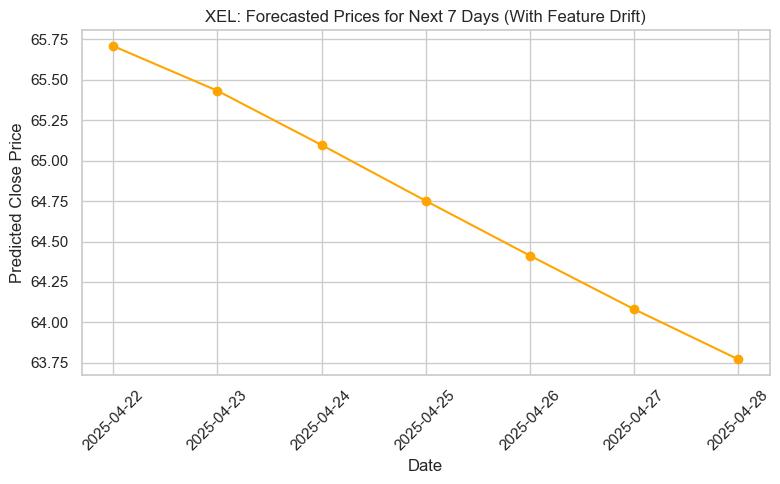

In [223]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from prophet import Prophet
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# --- Feature Engineering ---
def add_technical_indicators(df):
    df = df.copy()
    df = df.sort_values(["Ticker", "Date"])
    window = 14

    df["SMA_20"] = df.groupby('Ticker')["Close"].transform(lambda x: x.rolling(20).mean())
    df["EMA_20"] = df.groupby('Ticker')["Close"].transform(lambda x: x.ewm(span=20, adjust=False).mean())
    df["Volatility_14"] = df.groupby('Ticker')["Close"].transform(lambda x: x.pct_change().rolling(window).std())

    def compute_rsi(series, window=14):
        delta = series.diff()
        up = delta.clip(lower=0)
        down = -delta.clip(upper=0)
        ma_up = up.rolling(window).mean()
        ma_down = down.rolling(window).mean()
        rsi = 100 - (100 / (1 + ma_up / ma_down))
        return rsi

    df["RSI_14"] = df.groupby('Ticker')["Close"].transform(lambda x: compute_rsi(x, window))
    df = df.dropna(subset=["SMA_20", "EMA_20", "Volatility_14", "RSI_14"])

    return df

# --- Main Training + Forecast with Feature Drift ---
def train_and_forecast_with_feature_drift(df, ticker, seq_length=90, forecast_days=7):
    sub = df[df['Ticker'] == ticker].sort_values('Date').dropna()

    # Step 1: Prophet
    prophet_df = sub[['Date', 'Close']].rename(columns={'Date':'ds', 'Close':'y'})
    prophet = Prophet(daily_seasonality=True)
    prophet.fit(prophet_df)

    future = prophet.make_future_dataframe(periods=0)
    forecast = prophet.predict(future)
    sub['Prophet_Trend'] = forecast['yhat'].values

    # Step 2: Features
    features = ["Close", "Volume", "SMA_20", "EMA_20", "Volatility_14", "RSI_14", "Prophet_Trend"]
    X_features = sub[features].values
    y_target = sub['Close'].values.reshape(-1,1)

    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_features)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y_target)

    # Step 3: Sequence building
    X, y = [], []
    for i in range(len(X_scaled) - seq_length):
        X.append(X_scaled[i:i+seq_length])
        y.append(y_scaled[i+seq_length])
    X = np.array(X)
    y = np.array(y)

    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Step 4: LSTM Model
    n_feats = X.shape[2]
    model = Sequential([
        Input(shape=(seq_length, n_feats)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')

    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=32,
        callbacks=[es, reduce_lr],
        verbose=2
    )

    # Step 5: Forecast with simulated feature drift
    last_known = sub.iloc[-seq_length:].copy()
    input_seq = scaler_X.transform(last_known[features].values)
    preds = []

    future_dates = prophet.make_future_dataframe(periods=forecast_days)
    future_forecast = prophet.predict(future_dates)
    future_trend = future_forecast[['ds', 'yhat']].set_index('ds')

    current_features = last_known.iloc[-1].copy()

    for day in range(forecast_days):
        input_batch = np.expand_dims(input_seq, axis=0)
        pred_scaled = model.predict(input_batch, verbose=0)[0,0]
        pred_unscaled = scaler_y.inverse_transform(np.array(pred_scaled).reshape(-1,1)).flatten()[0]

        preds.append(pred_unscaled)

        # --- Simulate feature drift ---
        current_features['Volume'] *= random.uniform(0.995, 1.005)  # ±0.5% volume
        current_features['SMA_20'] *= random.uniform(0.998, 1.002)  # ±0.2% SMA drift
        current_features['EMA_20'] *= random.uniform(0.998, 1.002)  # ±0.2% EMA drift
        current_features['Volatility_14'] *= random.uniform(0.95, 1.05)  # ±5% vol drift
        current_features['RSI_14'] += random.uniform(-0.3, 0.3)  # ±0.3 RSI points
        current_features['RSI_14'] = np.clip(current_features['RSI_14'], 0, 100)  # keep RSI in [0,100]

        current_features['Close'] = pred_unscaled
        current_features['Prophet_Trend'] = future_trend.iloc[day]['yhat']

        new_row_scaled = scaler_X.transform(current_features[features].values.reshape(1, -1))
        input_seq = np.vstack([input_seq, new_row_scaled])
        input_seq = input_seq[-seq_length:, :]

    # Step 6: Build forecast DataFrame
    forecast_dates = pd.date_range(start=sub['Date'].max() + pd.Timedelta(days=1), periods=forecast_days, freq='D')
    pred_df = pd.DataFrame({'Date': forecast_dates, 'Predicted_Close': preds})

    # Step 7: Plot ONLY predicted future
    plt.figure(figsize=(8, 5))
    plt.plot(pred_df['Date'], pred_df['Predicted_Close'], marker='o', linestyle='-', color='orange')
    plt.title(f"{ticker}: Forecasted Prices for Next {forecast_days} Days (With Feature Drift)")
    plt.xlabel("Date")
    plt.ylabel("Predicted Close Price")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, prophet, scaler_X, scaler_y, pred_df

# Preprocess data
df = add_technical_indicators(market_data)

# Train + Forecast + Plot realistic forecast
model, prophet, scaler_X, scaler_y, pred_df = train_and_forecast_with_feature_drift(df, ticker='XEL', seq_length=90, forecast_days=7)

#### ARIMA Modeling Approach
An Auto-Regressive Integrated Moving Average (ARIMA) model:
- Auto-Regressive (AR): regresses on its own past values (lags)
- Integrated (I): differences the series d times to achieve stationarity
- Moving Average (MA): models the error term as a linear combination of past error terms

It’s fast, interpretable, and—on stationary series like returns—often quite effective for short-term forecasts

An **ARIMA**(p, d, q) model blends three components:

1. **AR(p)** (Auto-Regressive): today’s value is a linear combination of the past p values.  
2. **I(d)** (Integrated): we difference the series d times to remove trends / achieve stationarity.  
3. **MA(q)** (Moving Average): model today’s error as a linear combination of the past q error terms.  

On **stationary** time series (no persistent trend or changing variance), ARMA/ARIMA can excel at short-term forecasts because it explicitly models autocorrelation and noise structure .

---

##### 2. From Prices to Stationary Returns

Financial time series like raw **prices** are almost always non‐stationary (they wander, trend, or have changing volatility). ARIMA requires stationarity, so we:

1. **Log-transform** (optional) to stabilize volatility:  
   ```python
   log_price = np.log(sub['Close'])
   ```
2. **Difference** once to get log-returns (which are typically stationary):  
   ```python
   log_ret = log_price.diff().dropna()
   ```
   Or simple percentage returns:  
   ```python
   ret = sub['Close'].pct_change().dropna()
   ```
3. **Visual check**: plot the series and its rolling mean/variance to see if they stabilize.

---

##### 3. Stationarity Test (ADF)

We use the **Augmented Dickey-Fuller (ADF)** test to confirm stationarity:

```python
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    stat, pval, *_ = adfuller(series)
    print(f"ADF Statistic: {stat:.4f},  p-value: {pval:.4f}")
```

- **Null hypothesis**: the series has a unit root (i.e. is non-stationary).  
- **If p-value < 0.05**, we reject the null ⇒ series is stationary ⇒ set **d = 0** in ARIMA.  
- Otherwise, difference the series again (`d += 1`) and re-test.

---

##### 4. Choosing (p, d, q)

- **d** is determined by the ADF test (number of differences needed for stationarity).  
- **p** and **q** control how many lagged values and lagged errors you include.  

###### 4.1. Autocorrelation & Partial Autocorrelation

- **ACF plot**: shows correlation of the series with its own lagged values ⇒ helps choose **q** (MA order).  
- **PACF plot**: shows correlation of the series with lagged values *after* removing intermediate correlations ⇒ helps choose **p** (AR order).

```python
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(returns, lags=30);  plt.show()
plot_pacf(returns, lags=30); plt.show()
```

Look for the lag beyond which correlation cuts off (“significant spike”).

###### 4.2. Information Criterion Grid Search

If ACF/PACF is unclear, we can automate a small grid search over p and q:

```python
import itertools
import numpy as np

best_aic, best_cfg = np.inf, None
for p, q in itertools.product(range(0,5), range(0,5)):
    try:
        model = ARIMA(returns, order=(p, d, q)).fit()
        if model.aic < best_aic:
            best_aic, best_cfg = model.aic, (p, d, q)
    except:
        continue

print("Best order:", best_cfg, "AIC:", best_aic)
```

- **AIC** (Akaike Information Criterion) balances goodness-of-fit against model complexity.  
- We pick the `(p,d,q)` with the **lowest AIC**.

---

##### 5. Train/Test Split

We simulate “live” forecasting by:

```python
split = int(0.8 * len(returns))
train, test = returns.iloc[:split], returns.iloc[split:]
```

- Fit the ARIMA solely on **train** data.  
- Reserve **test** for out‐of‐sample evaluation.

---

##### 6. Fit & Forecast

```python
from statsmodels.tsa.arima.model import ARIMA

p_opt, d_opt, q_opt = best_cfg
model = ARIMA(train, order=(p_opt, d_opt, q_opt)).fit()
forecast = model.forecast(steps=len(test))
```

- `model.forecast(n)` produces the next **n** predicted values of the differenced series (i.e. returns).

---

##### 7. Convert Returns → Price Forecast

To map predicted returns back to price levels:

```python
last_train_price = sub['Close'].iloc[split]    # the final price in train set
price_forecast = last_train_price * (1 + forecast).cumprod()
true_prices    = sub['Close'].iloc[split+1:]
```

- We start from the last *known* price, then sequentially apply the predicted returns.

---

##### 8. Evaluation & Visualization

###### 8.1. RMSE on Returns

```python
from sklearn.metrics import mean_squared_error
rmse_ret = np.sqrt(mean_squared_error(test, forecast))
print(f"Return-RMSE: {rmse_ret:.4f}")
```

###### 8.2. Price-Level RMSE

```python
rmse_price = np.sqrt(mean_squared_error(true_prices, price_forecast))
print(f"Price-level RMSE: ${rmse_price:.2f}")
```

###### 8.3. Plot Actual vs Forecast

```python
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(true_prices.index, true_prices, label='Actual Price')
plt.plot(true_prices.index, price_forecast, label='ARIMA Forecast', alpha=0.8)
plt.title(f"{ticker} ARIMA({p_opt},{d_opt},{q_opt}) Forecast")
plt.legend()
plt.show()
```

This lets you visually compare how closely the ARIMA price path tracks reality.


In [250]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 1) Choose one symbol
ticker = 'YOU'
sub = market_data[market_data['Ticker']==ticker].sort_values('Date')

# 2) Compute Close-to-Close returns (stationary by design)
sub['Return'] = sub['Close'].pct_change().dropna()
returns = sub['Return'].dropna()

In [266]:
def adf_test(series, name="Series"):
    """
    Run Augmented Dickey–Fuller and print p-value.
    If p < 0.05 → reject unit root → series is (likely) stationary.
    """
    result = adfuller(series, autolag='AIC')
    pval = result[1]
    print(f"ADF test on {name}: p-value = {pval:.4f}")

# assume `sub` is your per-ticker DataFrame sorted by Date
returns = sub['Close'].pct_change().dropna()

adf_test(returns, name="1st-difference returns")


ADF test on 1st-difference returns: p-value = 0.0000


In [270]:
log_price = np.log(sub['Close'])
log_returns = log_price.diff().dropna()
adf_test(log_returns, name="log-returns")

# if still non-stationary, difference again:
log_ret_diff2 = log_returns.diff().dropna()
adf_test(log_ret_diff2, name="2nd-difference log-returns")


ADF test on log-returns: p-value = 0.0000
ADF test on 2nd-difference log-returns: p-value = 0.0000


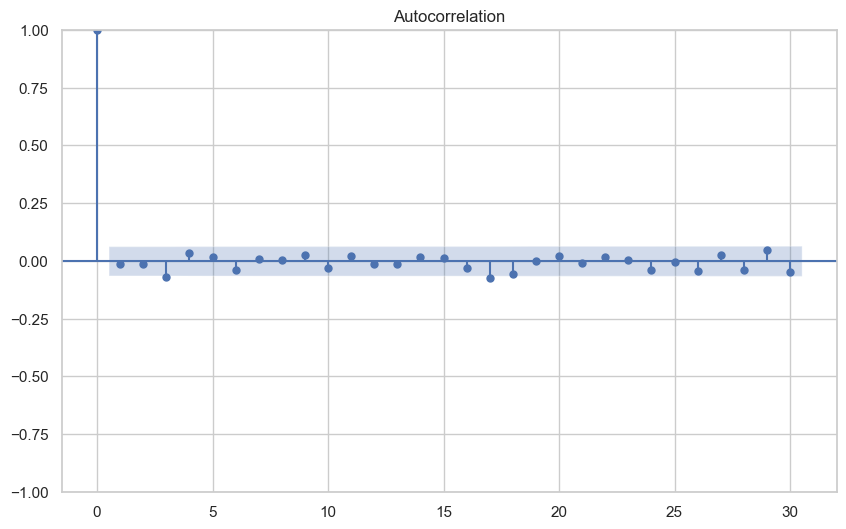

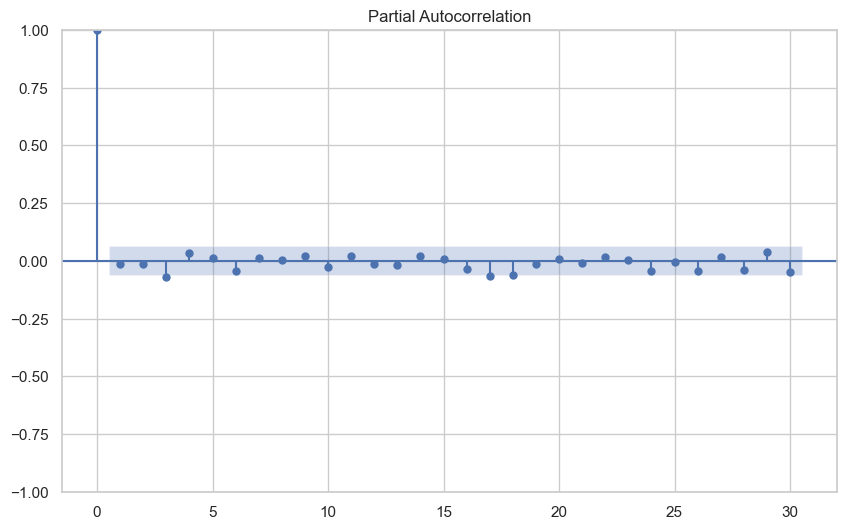

In [272]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(returns, lags=30);  plt.show()
plot_pacf(returns, lags=30); plt.show()

What Are ACF & PACF?
- ACF (Autocorrelation Function) plots the correlation between the series and itself at different lags.
- PACF (Partial Autocorrelation Function) plots the correlation between the series and itself at lag k, after removing all correlations explained by lags 1 through k–1.

Both come with the blue-shaded “95% confidence bands”—any bar that sticks clearly outside that band is considered a significant autocorrelation.
The return series has no linear time-lag structure—at least up to 30 days—so a pure AR/MA model can’t do better than the constant mean.

In [254]:
import itertools

# define ranges
p = q = range(0, 5)
d = 0  # from your ADF test above

best_aic = np.inf
best_cfg = None

for pi, di, qi in itertools.product(p, [d], q):
    try:
        model = ARIMA(returns, order=(pi, di, qi)).fit()
        if model.aic < best_aic:
            best_aic, best_cfg = model.aic, (pi, di, qi)
    except:
        continue

print("Best ARIMA order:", best_cfg, "AIC=", best_aic)


C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

Best ARIMA order: (0, 0, 0) AIC= -3454.9451847882274


C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [256]:
# split into train & test (e.g. last 20% as test)
split = int(0.8 * len(returns))
train, test = returns.iloc[:split], returns.iloc[split:]

# fit on train
p_opt, d_opt, q_opt = best_cfg
model = ARIMA(train, order=(p_opt, d_opt, q_opt)).fit()

# forecast next len(test) steps
forecast = model.forecast(steps=len(test))


C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\anupr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

ARIMA(0,0,0) Return‐RMSE: 0.0367
Price‐level RMSE: $7.78


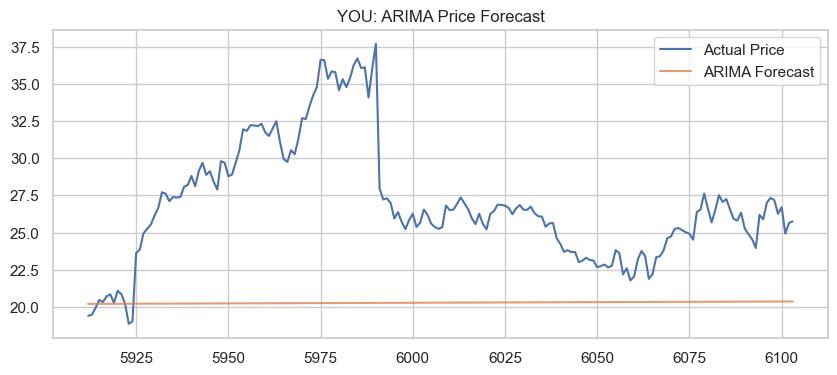

In [258]:
# RMSE on returns
rmse_ret = np.sqrt(mean_squared_error(test, forecast))
print(f"ARIMA({p_opt},{d_opt},{q_opt}) Return‐RMSE: {rmse_ret:.4f}")

# Convert returns → price forecast (starting from last train price)
last_price = sub['Close'].iloc[split]
price_forecast = last_price * (1 + forecast).cumprod()
true_prices   = sub['Close'].iloc[split+1:]

# Price‐level RMSE
rmse_price = np.sqrt(mean_squared_error(true_prices, price_forecast))
print(f"Price‐level RMSE: ${rmse_price:.2f}")

# Plot
plt.figure(figsize=(10,4))
plt.plot(true_prices.index, true_prices, label='Actual Price')
plt.plot(true_prices.index, price_forecast, label='ARIMA Forecast', alpha=0.8)
plt.title(f"{ticker}: ARIMA Price Forecast")
plt.legend()
plt.show()

Because the returns series showed:

1. **No significant autocorrelations** – the ACF bars after lag 0 all stayed within the confidence bands.  
2. **No meaningful partial autocorrelations** – the PACF likewise dropped straight to zero past lag 0.  
3. **Stationarity at first difference** – your returns were already “white noise,” so no extra differencing was needed.

An ARIMA(p, d, q) with **p=0**, **d=0**, **q=0** collapses to the simplest possible forecast:

> **Forecast = the historical mean (constant) + white-noise error**

In other words, if there’s no evidence of linear dependency on past lags (AR terms) or past errors (MA terms), the model’s best guess for tomorrow is just the long-run average of the series. That’s exactly what ARIMA(0,0,0) does—it returns the constant mean of your returns.

*Bottom Line: Since your return series doesn’t show any reliable day-to-day patterns (no linear autocorrelation or seasonality), the ARIMA machinery defaults to the simplest forecast: “tomorrow’s return = the historical average return.”*

#### Facebook PROPHET 

Prophet looks at how your price has moved over months and years, spots the regular bumps (weeks, seasons, holidays), fits a smooth curve through the rest, and then extends that curve to tell you where it thinks prices will go next.

##### 1) Data Preparation

Prophet expects a DataFrame with exactly two columns:

| Column name | Meaning                          |
|-------------|----------------------------------|
| `ds`        | datestamp (must be `datetime64`) |
| `y`         | the numeric value to forecast    |

###### 1.1. Filter your ticker

If you have many stocks in `market_data`, choose one:

```python
ticker = "YOU"
df = market_data[market_data["Ticker"] == ticker].copy()
```

###### 1.2. Rename for Prophet

```python
df_prophet = df[["Date", "Close"]] \
                .rename(columns={"Date": "ds", "Close": "y"})
```

###### 1.3. Clean & Type-cast

```python
df_prophet = df_prophet.dropna()              
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])
```

- **`dropna()`** removes any rows missing a date or close price.  
- **`pd.to_datetime()`** ensures the `ds` column is in datetime format.

---

##### 2) Instantiate & Configure the Model

```python
m = Prophet(
    growth="linear",          # assume close price grows roughly linearly
    daily_seasonality=False,  
    weekly_seasonality=True,  # captures Monday/Friday biases
    yearly_seasonality=True,  # captures calendar seasonality
)
# (Optional) Add known holidays, e.g. US market closures:
m.add_country_holidays(country_name='US')
```

- **`growth`** controls whether the trend is linear or logistic. Stocks often behave roughly linearly over short horizons.  
- **`daily_seasonality`** turned off because markets don’t trade 24 × 7.  
- **`weekly_seasonality`** captures patterns like “Mondays tend to open lower,” etc.  
- **`yearly_seasonality`** captures effects like year-end rallies.  
- **Holidays**: Prophet has built-in calendars; including them can help explain non‐trading days or predictable price movements around holidays.

---

##### 3) Fit the Model

```python
m.fit(df_prophet)
```

- Prophet internally:
  1. Detects trend breakpoints (where the slope of your price series changes).  
  2. Learns the parameters for weekly & yearly seasonal curves.  
  3. Estimates holiday effects if you’ve added them.

This step can take a few seconds on a handful of years of daily data.

---

##### 4) Prepare Future Dates & Forecast

###### 4.1. Make a “future” DataFrame

```python
horizon_days = 30
future = m.make_future_dataframe(periods=horizon_days, freq="B")
```

- **`periods=30`** requests 30 new points beyond your training data.  
- **`freq="B"`** ensures only business days (i.e. Monday–Friday).

###### 4.2. Run the Forecast

```python
forecast = m.predict(future)
```

- Prophet returns a DataFrame with these key columns:
  - **`ds`**: the date  
  - **`yhat`**: the forecasted value  
  - **`yhat_lower`**, **`yhat_upper`**: 80% uncertainty interval  
  - plus columns for trend, seasonal components, holiday effects, etc.

---

##### 5) Visualize the Results

###### 5.1. Full Forecast Plot

```python
fig1 = m.plot(forecast, xlabel="Date", ylabel="Close Price")
plt.title(f"{ticker} Close Price Forecast")
plt.show()
```

- **Black dots**: your historical data points.  
- **Blue line**: the predicted trend & seasonality combined.  
- **Light-blue band**: the model’s uncertainty window.

###### 5.2. Decomposed Components

```python
fig2 = m.plot_components(forecast)
plt.show()
```

Prophet will automatically show separate subplots for:  
1. **Trend** (the long-term direction)  
2. **Weekly seasonality** (e.g. patterns by weekday)  
3. **Yearly seasonality** (calendar effects)  
4. **Holiday effects** if enabled

---

##### 6) In-Sample Evaluation (Optional)

You can check how well Prophet fits your training data by comparing `yhat` to the true `y` on dates you already know:

```python
df_eval = forecast.set_index("ds")[["yhat"]] \
                  .join(df_prophet.set_index("ds")) \
                  .dropna()
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(df_eval["y"], df_eval["yhat"]))
print(f"In-sample RMSE: {rmse:.2f}")
```

- This **does not** guarantee out‐of‐sample performance but gives a sanity check that Prophet is learning meaningful patterns.

---

##### 7) Tips & Next Steps

1. **Cross‐Validation**  
   ```python
   from prophet.diagnostics import cross_validation
   df_cv = cross_validation(m, initial="365 days", period="180 days", horizon="30 days")
   ```
   - Tests how well the model would have performed on unseen data in a rolling fashion.

2. **Hyperparameter Tuning**  
   - **`changepoint_prior_scale`**: controls trend flexibility (default ≈0.05).  
   - **`seasonality_prior_scale`**: controls smoothness of seasonal curves.  

3. **Batch Mode**  
   Wrap the entire flow in a loop over `market_data['Ticker'].unique()` to forecast each stock in your universe.

4. **Combining with Other Models**  
   - Compare Prophet’s forecasts to your LSTM predictions & ARIMA benchmarks.  
   - Ensemble approaches often yield more robust signals.

---

In [161]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 15.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.9/917.9 kB 22.7 MB/s eta 0:00:0000:01


In [285]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# 1) Pick your ticker and prepare the DataFrame
ticker = "YOU"
df = market_data[market_data["Ticker"] == ticker].copy()

# Prophet expects exactly two columns: 
#   ds = date,  y = target variable (Close price)
df_prophet = df[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"})
df_prophet = df_prophet.dropna()           # drop any missing closes
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])  # ensure datetime

print(f"{ticker} data for Prophet:\n", df_prophet.head())

YOU data for Prophet:
              ds          y
5146 2021-06-30  36.181355
5147 2021-07-01  43.345257
5148 2021-07-02  43.417614
5149 2021-07-06  40.423607
5150 2021-07-07  37.094925


In [287]:
# 2) Instantiate & fit the model
m = Prophet(
    growth="linear",      # assume no exponential trend
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
)
m.add_country_holidays(country_name='US')    # optional: include US market holidays

m.fit(df_prophet)

20:05:29 - cmdstanpy - INFO - Chain [1] start processing
20:05:29 - cmdstanpy - INFO - Chain [1] done processing


In [289]:
# 3) Create a future‐dates DataFrame & forecast
horizon_days = 30
future = m.make_future_dataframe(periods=horizon_days, freq="B")  # “B”=business days
forecast = m.predict(future)

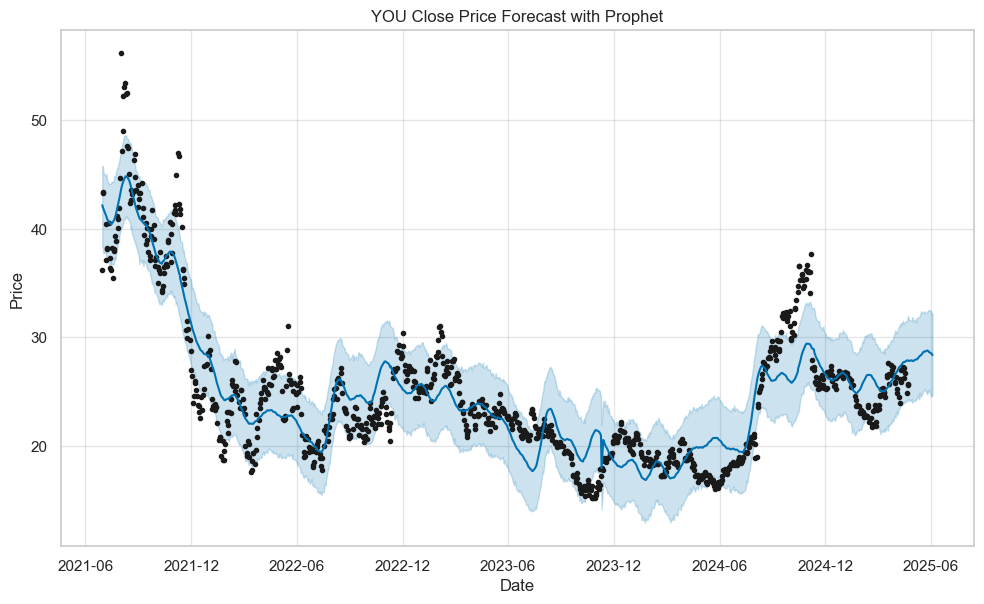

In [291]:
# 4) Plot the forecast
fig1 = m.plot(forecast, xlabel="Date", ylabel="Price")
plt.title(f"{ticker} Close Price Forecast with Prophet")
plt.show()

The plot above shows three things in one view:
1. Black dots – the actual historical closing prices for YOU that you fed into Prophet.
2. Solid blue line – the model’s best estimate of the underlying price trend + seasonality, fit to that historical data.
3. Light-blue band – the model’s uncertainty interval (by default an 80% credible interval), telling you “we’re X confident the true price will lie somewhere in this shaded region.”

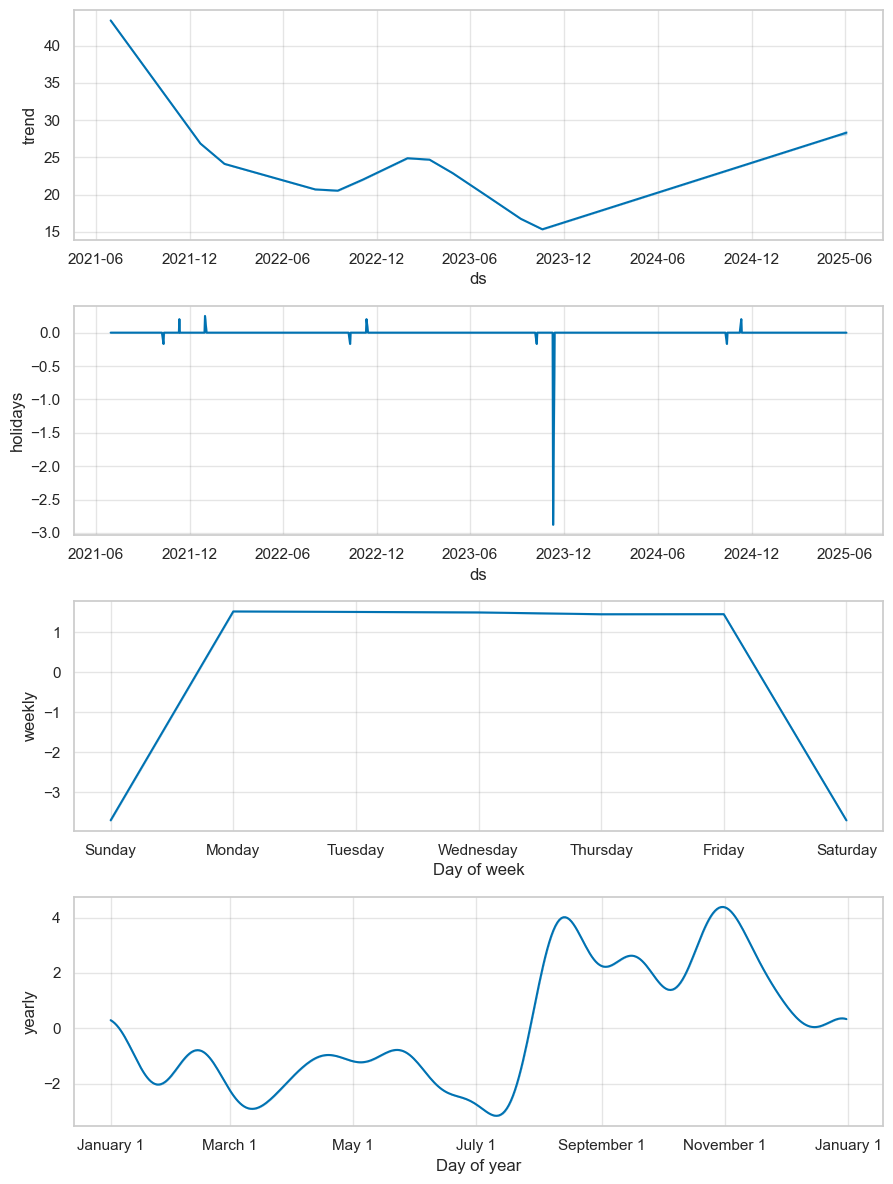

In [293]:
# 5) Components (trend + seasonality + holidays)
fig2 = m.plot_components(forecast)
plt.show()

1) **Trend:** The smooth, “long-term” trajectory Prophet fit to your data, with automatic breakpoints where the slope changes.  
- This is the baseline on which all seasonal and holiday effects get added.

2) **Holidays:** Prophet’s learned “spikes” or “dips” on specific calendar dates you asked it to include (here: U.S. market holidays).  
- Stocks often jump or drop around scheduled closures or earnings dates; Prophet models those as known exogenous effects.

3) **Weekly Seasonality:** The average “day-of-week” effect, computed across your entire training period.  
- It captures consistent patterns like “Monday open is usually slightly lower” or “Friday sometimes rallies.”

4) **Yearly Seasonality:** The recurring pattern within a year—that is, how “time of year” influences price.  
- Many equities exhibit calendar effects (e.g. “sell in May and go away,” year-end rallies).

Prophet’s final forecast =  
```
trend(t)  
+ weekly_seasonality(day_of_week t)  
+ yearly_seasonality(day_of_year t)  
+ holiday_effect(t)
```
Each subplot shows one of those components as a function of time (or day-of-week / day-of-year). By examining them:

- You see **why** the forecast moves up or down at certain times.  
- You can verify whether the model learned sensible seasonality (e.g. did July really tend to be a peak?).  
- You can spot if any holiday effect is overly large or unintuitive and adjust your model configuration accordingly.

In short, these “components plots” make Prophet fully transparent: you don’t just get “here’s a blue line prediction,” you see **exactly** how trend, weekly cycles, yearly cycles, and holidays combine to form that line.

In [295]:
# 6) Evaluate historical performance (optional)
#    You can compare `forecast.yhat` on the training period back to `df_prophet.y`
#    by merging them and computing an RMSE, etc.

df_forecasted = forecast.set_index("ds")[["yhat"]].join(df_prophet.set_index("ds"))
df_forecasted = df_forecasted.dropna()

from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(df_forecasted["y"], df_forecasted["yhat"]))
print(f"{ticker} in-sample RMSE: {rmse:.2f}")

YOU in-sample RMSE: 2.91
